# I/ Importing libraries and reading data

In [135]:
# Importing all required libraries and datasets
if(!require("dplyr")) install.packages("dplyr")
if(!require('leaps')) install.packages('leaps')
if(!require('MASS')) install.packages('MASS')
if(!require('randomForest')) install.packages('randomForest')
if(!require('gbm')) install.packages('gbm')
if(!require('tree')) install.packages('tree')
if(!require('caret')) install.packages('caret')

library(dplyr)
library(leaps)
library(MASS)
library(randomForest)  # Bagging and RF
library(gbm)           # Boosting tree
library(tree)          # CART model
library(caret)


In [136]:
# Reading in the credit default csv
credit_default <- read.csv('./Dataset 2 - Credit Card Default/credit_default_train.csv')

In [137]:
table(credit_default$default.payment.next.month)


    0     1 
15586  4414 

In [138]:
# Display unique values for each column
apply(credit_default, 2, function(x) length(unique(x)))

cust_id                  LIMIT_BAL 
                     20000                         82 
                       SEX                  EDUCATION 
                         3                          8 
                  MARRIAGE                        AGE 
                         5                         56 
                     PAY_0                      PAY_2 
                        12                         12 
                     PAY_3                      PAY_4 
                        12                         12 
                     PAY_5                      PAY_6 
                        11                         11 
                 BILL_AMT1                  BILL_AMT2 
                     15771                      15450 
                 BILL_AMT3                  BILL_AMT4 
                     15296                      14962 
                 BILL_AMT5                  BILL_AMT6 
                     14653                      14407 
                  PAY_AMT1                   PAY_AMT2 
                      6076                       6082 
                  PAY_AMT3                   PAY_AMT4 
                      5727                       5384 
                  PAY_AMT5                   PAY_AMT6 
                      5315                       5317 
default.payment.next.month 
                         2

In [139]:
# determine the indepedent and dependent variables
iv_vars <- colnames(credit_default)[2:(ncol(credit_default)-1)]
dv_var <- colnames(credit_default)[ncol(credit_default)]

# II/ Identifying missing values and filling them

In [140]:
# Count total number of missing values
paste("Total NAs:", sum(apply(is.na(credit_default[iv_vars]), 2,sum)), "out of:", nrow(credit_default), "rows")

# Count missing values per column
apply(is.na(credit_default), 2, sum)

[1] "Total NAs: 4448 out of: 20000 rows"

cust_id                  LIMIT_BAL 
                         0                        202 
                       SEX                  EDUCATION 
                       161                        199 
                  MARRIAGE                        AGE 
                       170                        214 
                     PAY_0                      PAY_2 
                       195                        219 
                     PAY_3                      PAY_4 
                       217                        199 
                     PAY_5                      PAY_6 
                       185                        203 
                 BILL_AMT1                  BILL_AMT2 
                       185                        209 
                 BILL_AMT3                  BILL_AMT4 
                       175                        165 
                 BILL_AMT5                  BILL_AMT6 
                       181                        197 
                  PAY_AMT1                   PAY_AMT2 
                       204                        184 
                  PAY_AMT3                   PAY_AMT4 
                       212                        197 
                  PAY_AMT5                   PAY_AMT6 
                       179                        196 
default.payment.next.month 
                         0

### II.1. Replacing missing values : categorical values

In [141]:
# List the names of the categorical columns:
cat_vars <- colnames(credit_default[0,c('SEX','EDUCATION','MARRIAGE','PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6','default.payment.next.month')])
cat_vars

[1] "SEX"                        "EDUCATION"                 
 [3] "MARRIAGE"                   "PAY_0"                     
 [5] "PAY_2"                      "PAY_3"                     
 [7] "PAY_4"                      "PAY_5"                     
 [9] "PAY_6"                      "default.payment.next.month"

In [142]:
replacements <- apply(credit_default[cat_vars], 2, median, na.rm =  TRUE)
replacements

SEX                  EDUCATION 
                         2                          2 
                  MARRIAGE                      PAY_0 
                         2                          0 
                     PAY_2                      PAY_3 
                         0                          0 
                     PAY_4                      PAY_5 
                         0                          0 
                     PAY_6 default.payment.next.month 
                         0                          0

In [143]:
# Replace missing categorical values with the number 333
#  for (v in cat_vars) {
#      credit_default[is.na(credit_default[v]), v] <- credit_default[calc_mode(v)]
# }  

for (v in cat_vars) {
    credit_default[is.na(credit_default[v]), v] <- replacements[v]
    
    
#     apply(credit_default[cat_vars], 2, median, na.rm =  TRUE)
}  



# credit_default %>% 
#   mutate(across(everything(credit_default[cat_vars]), ~replace_na(.x, calc_mode(.x))))
# if (!require("tidyverse")) install.packages("tidyverse")

# credit_default %>% 
#   mutate(across(everything(), ~replace_na(.cat_vars, calc_mode(.cat_vars))))

# for (column in cat_vars) {
#     credit_default[column].fillna(credit_default[column].mode()[0], inplace=True)}

In [144]:
# # Convert the categorical values into factors
# credit_default[,cat_vars] <- lapply(credit_default[,cat_vars] , factor)
str(credit_default)

'data.frame':	20000 obs. of  25 variables:
 $ cust_id                   : int  18895 25102 28867 1842 3371 29925 29940 11638 4761 6746 ...
 $ LIMIT_BAL                 : int  70000 390000 60000 140000 50000 20000 50000 250000 320000 300000 ...
 $ SEX                       : num  1 2 1 2 1 1 1 1 2 1 ...
 $ EDUCATION                 : num  3 2 1 2 1 2 3 2 2 1 ...
 $ MARRIAGE                  : num  2 2 2 1 2 2 2 2 2 1 ...
 $ AGE                       : int  34 26 27 55 29 37 44 30 36 35 ...
 $ PAY_0                     : num  0 2 0 0 2 0 0 0 -2 0 ...
 $ PAY_2                     : num  0 2 0 0 2 0 0 0 -2 0 ...
 $ PAY_3                     : num  0 2 0 0 2 0 0 0 -2 0 ...
 $ PAY_4                     : num  0 0 0 0 0 0 2 -1 -2 0 ...
 $ PAY_5                     : num  0 0 0 0 0 0 0 2 -2 0 ...
 $ PAY_6                     : num  0 0 2 0 -2 0 0 -1 -2 0 ...
 $ BILL_AMT1                 : int  53972 185111 21387 108038 7881 20009 NA 5724 29862 91282 ...
 $ BILL_AMT2                 : int  2314

In [145]:
# Re - check missing values in categorical columns
paste("Total NAs in the categorical columns:", sum(apply(is.na(credit_default[cat_vars]), 2,sum)))

[1] "Total NAs in the categorical columns: 0"

### II.2. Splitting the data

In [146]:
set.seed(1)
split <- sample(c(rep(0, 0.7 * nrow(credit_default)), rep(1, 0.3 * nrow(credit_default))))
train <- credit_default[split == 0, ]    
test <- credit_default[split == 1, ]  

### II.3. Replacing missing values : numerical values

In [147]:
# List the names of the numerical columns:
num_vars <- colnames(credit_default[, -which(names(credit_default) %in% cat_vars)])
num_vars <- num_vars[num_vars != "cust_id"]
num_vars

[1] "LIMIT_BAL" "AGE"       "BILL_AMT1" "BILL_AMT2" "BILL_AMT3" "BILL_AMT4"
 [7] "BILL_AMT5" "BILL_AMT6" "PAY_AMT1"  "PAY_AMT2"  "PAY_AMT3"  "PAY_AMT4" 
[13] "PAY_AMT5"  "PAY_AMT6"

In [148]:
# Replace missing numerical values with the mean of the train set in the train set 
for(v in num_vars){
    train[is.na(train[,v]), v] <- mean(train[,v], na.rm = TRUE)
}

# Replace missing numerical values with the mean of the train set in the test set 
for(v in num_vars){
    test[is.na(test[,v]), v] <- mean(train[,v], na.rm = TRUE)
}

#### Reduce the nb of values for AGE

In [149]:
train <- train %>% 
  mutate(
    # Create categories
    age_group = dplyr::case_when(
      AGE >= 20 & AGE < 30 ~ "20",
      AGE >= 30 & AGE < 40 ~ "30",
      AGE >= 40 & AGE < 50 ~ "40",
      AGE >= 50 & AGE < 60 ~ "50",
      AGE >= 60 & AGE < 70 ~ "60",
      AGE >= 70            ~ "70"
    ),
#     # Convert to factor
#     age_group = factor(
#       age_group,
#       level = c("20", "30", "40", "50", "60", "70")
#     )
  )

test <- test %>% 
  mutate(
    # Create categories
    age_group = dplyr::case_when(
      AGE >= 20 & AGE < 30 ~ "20",
      AGE >= 30 & AGE < 40 ~ "30",
      AGE >= 40 & AGE < 50 ~ "40",
      AGE >= 50 & AGE < 60 ~ "50",
      AGE >= 60 & AGE < 70 ~ "60",
      AGE >= 70            ~ "70"
    ),
#     # Convert to factor
#     age_group = factor(
#       age_group,
#       level = c("20", "30", "40", "50", "60", "70")
#     )
  )

In [150]:
train$age_group <- as.numeric(train$age_group)
test$age_group <- as.numeric(test$age_group)

In [151]:
# Remove the column AGE
train <- subset(train, select = -AGE)
test <- subset(test, select = -AGE)

In [152]:
str(train)

'data.frame':	14000 obs. of  25 variables:
 $ cust_id                   : int  25102 28867 1842 3371 29925 29940 11638 4761 2757 21491 ...
 $ LIMIT_BAL                 : num  390000 60000 140000 50000 20000 50000 250000 320000 80000 30000 ...
 $ SEX                       : num  2 1 2 1 1 1 1 2 2 2 ...
 $ EDUCATION                 : num  2 1 2 1 2 3 2 2 2 2 ...
 $ MARRIAGE                  : num  2 2 1 2 2 2 2 2 2 2 ...
 $ PAY_0                     : num  2 0 0 2 0 0 0 -2 0 0 ...
 $ PAY_2                     : num  2 0 0 2 0 0 0 -2 0 0 ...
 $ PAY_3                     : num  2 0 0 2 0 0 0 -2 0 0 ...
 $ PAY_4                     : num  0 0 0 0 0 2 -1 -2 2 2 ...
 $ PAY_5                     : num  0 0 0 0 0 0 2 -2 2 0 ...
 $ PAY_6                     : num  0 2 0 -2 0 0 -1 -2 0 0 ...
 $ BILL_AMT1                 : num  185111 21387 108038 7881 20009 ...
 $ BILL_AMT2                 : num  172865 22416 110216 10415 20602 ...
 $ BILL_AMT3                 : num  153795 23444 84516 3997 21255

# III/ Handling outliers

### III.1. Outliers in : LIMIT_BAL

[1] 1e+06
[1] 780000


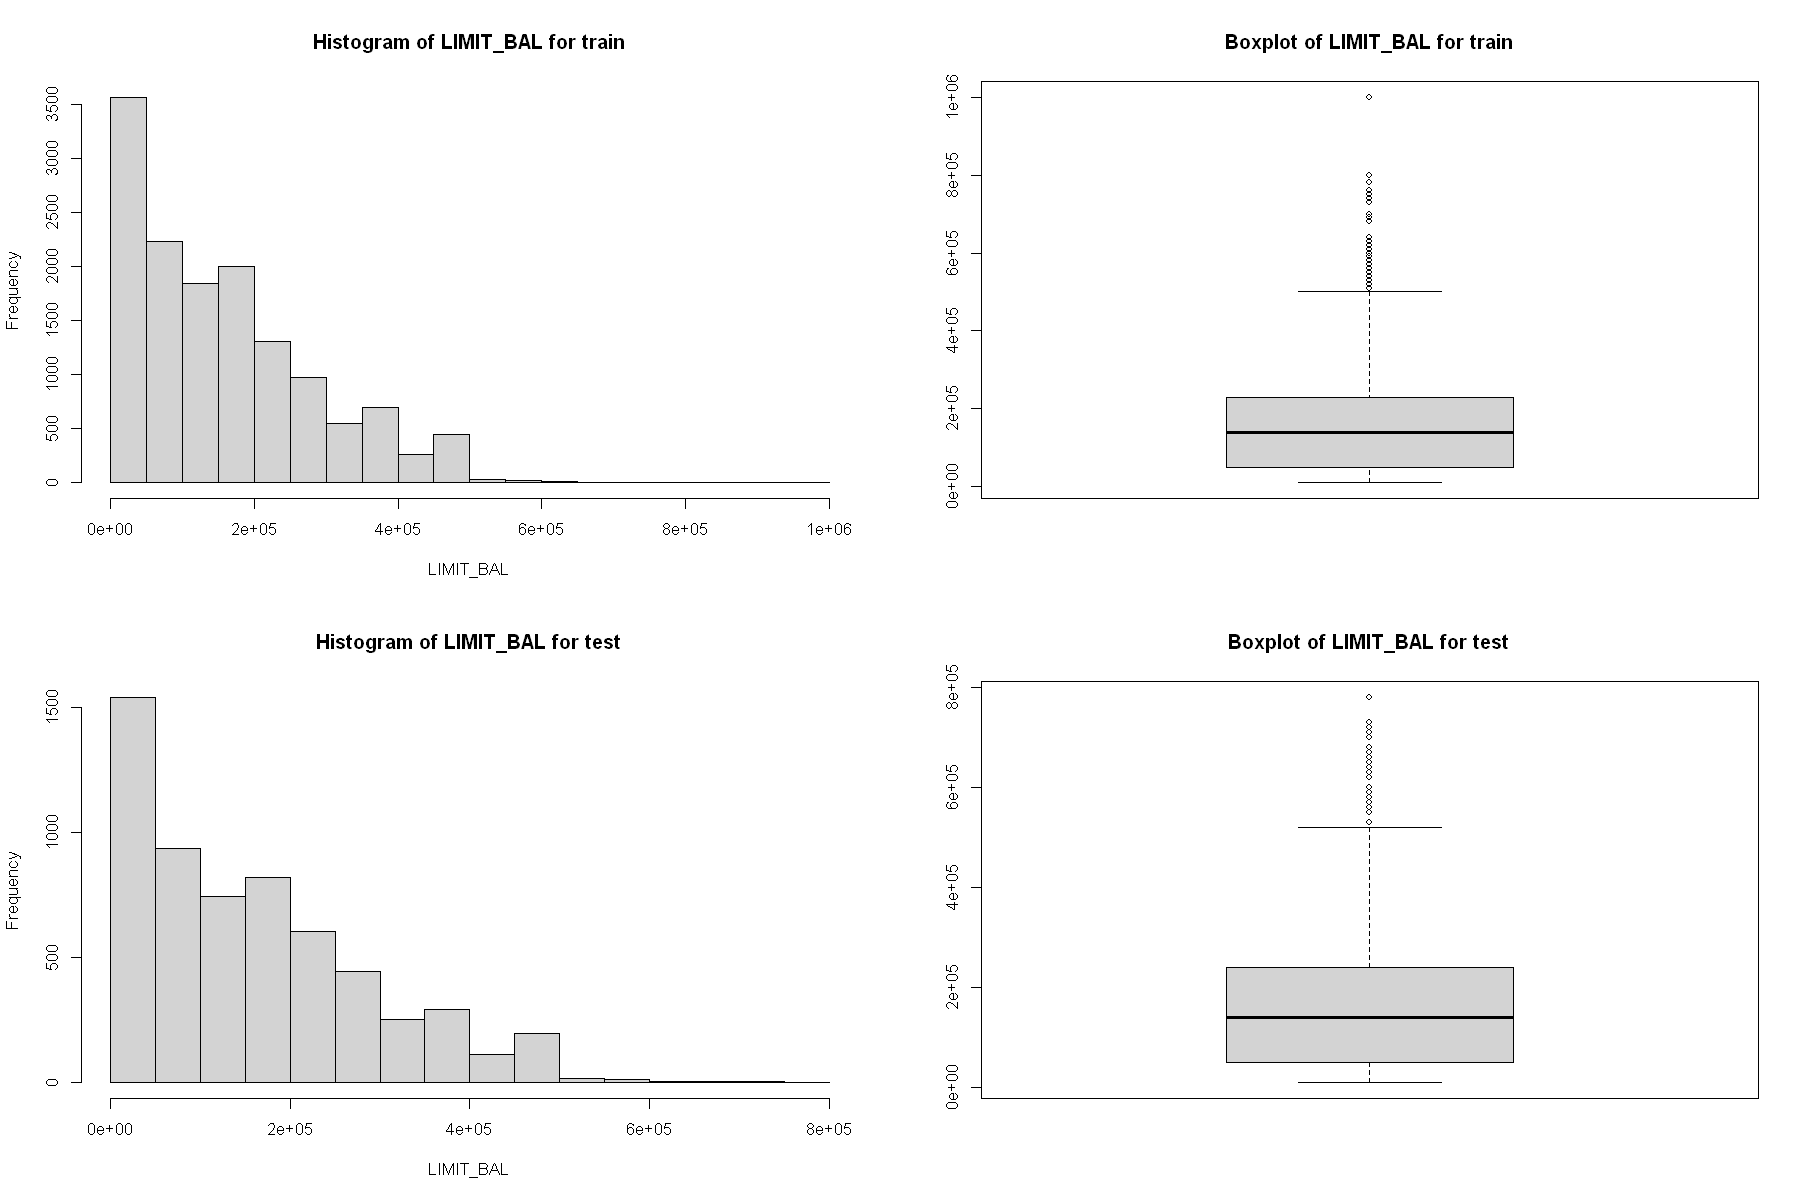

In [153]:
par(mfrow=c(2,2))

hist(train$LIMIT_BAL,xlab = "LIMIT_BAL",main = "Histogram of LIMIT_BAL for train")
boxplot(train$LIMIT_BAL, horizontal=FALSE,main = "Boxplot of LIMIT_BAL for train")

hist(test$LIMIT_BAL,xlab = "LIMIT_BAL",main = "Histogram of LIMIT_BAL for test")
boxplot(test$LIMIT_BAL, horizontal=FALSE,main = "Boxplot of LIMIT_BAL for test")

print(max(train$LIMIT_BAL))
print(max(test$LIMIT_BAL))

In [154]:
summary(train$LIMIT_BAL)
summary(test$LIMIT_BAL)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  10000   50000  140000  165963  230000 1000000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  10000   50000  140000  168402  240000  780000 

In [155]:
# The 3rd Quartile (75%)
third_quart_LIMIT_BAL <- summary(train$LIMIT_BAL)[5]

# Setting a benchmark 
benchark_LIMIT_BAL <- third_quart_LIMIT_BAL + 1.5*IQR(train$LIMIT_BAL) # Q3 + 1.5 * IQR

# Winsorizing the train set
train$LIMIT_BAL[train$LIMIT_BAL > benchark_LIMIT_BAL] <- benchark_LIMIT_BAL

# Winsorizing the test set
test$LIMIT_BAL[test$LIMIT_BAL > benchark_LIMIT_BAL] <- benchark_LIMIT_BAL

In [156]:
summary(train$LIMIT_BAL)
summary(test$LIMIT_BAL)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  10000   50000  140000  165278  230000  500000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  10000   50000  140000  167568  240000  500000 

[1] 5e+05
[1] 5e+05


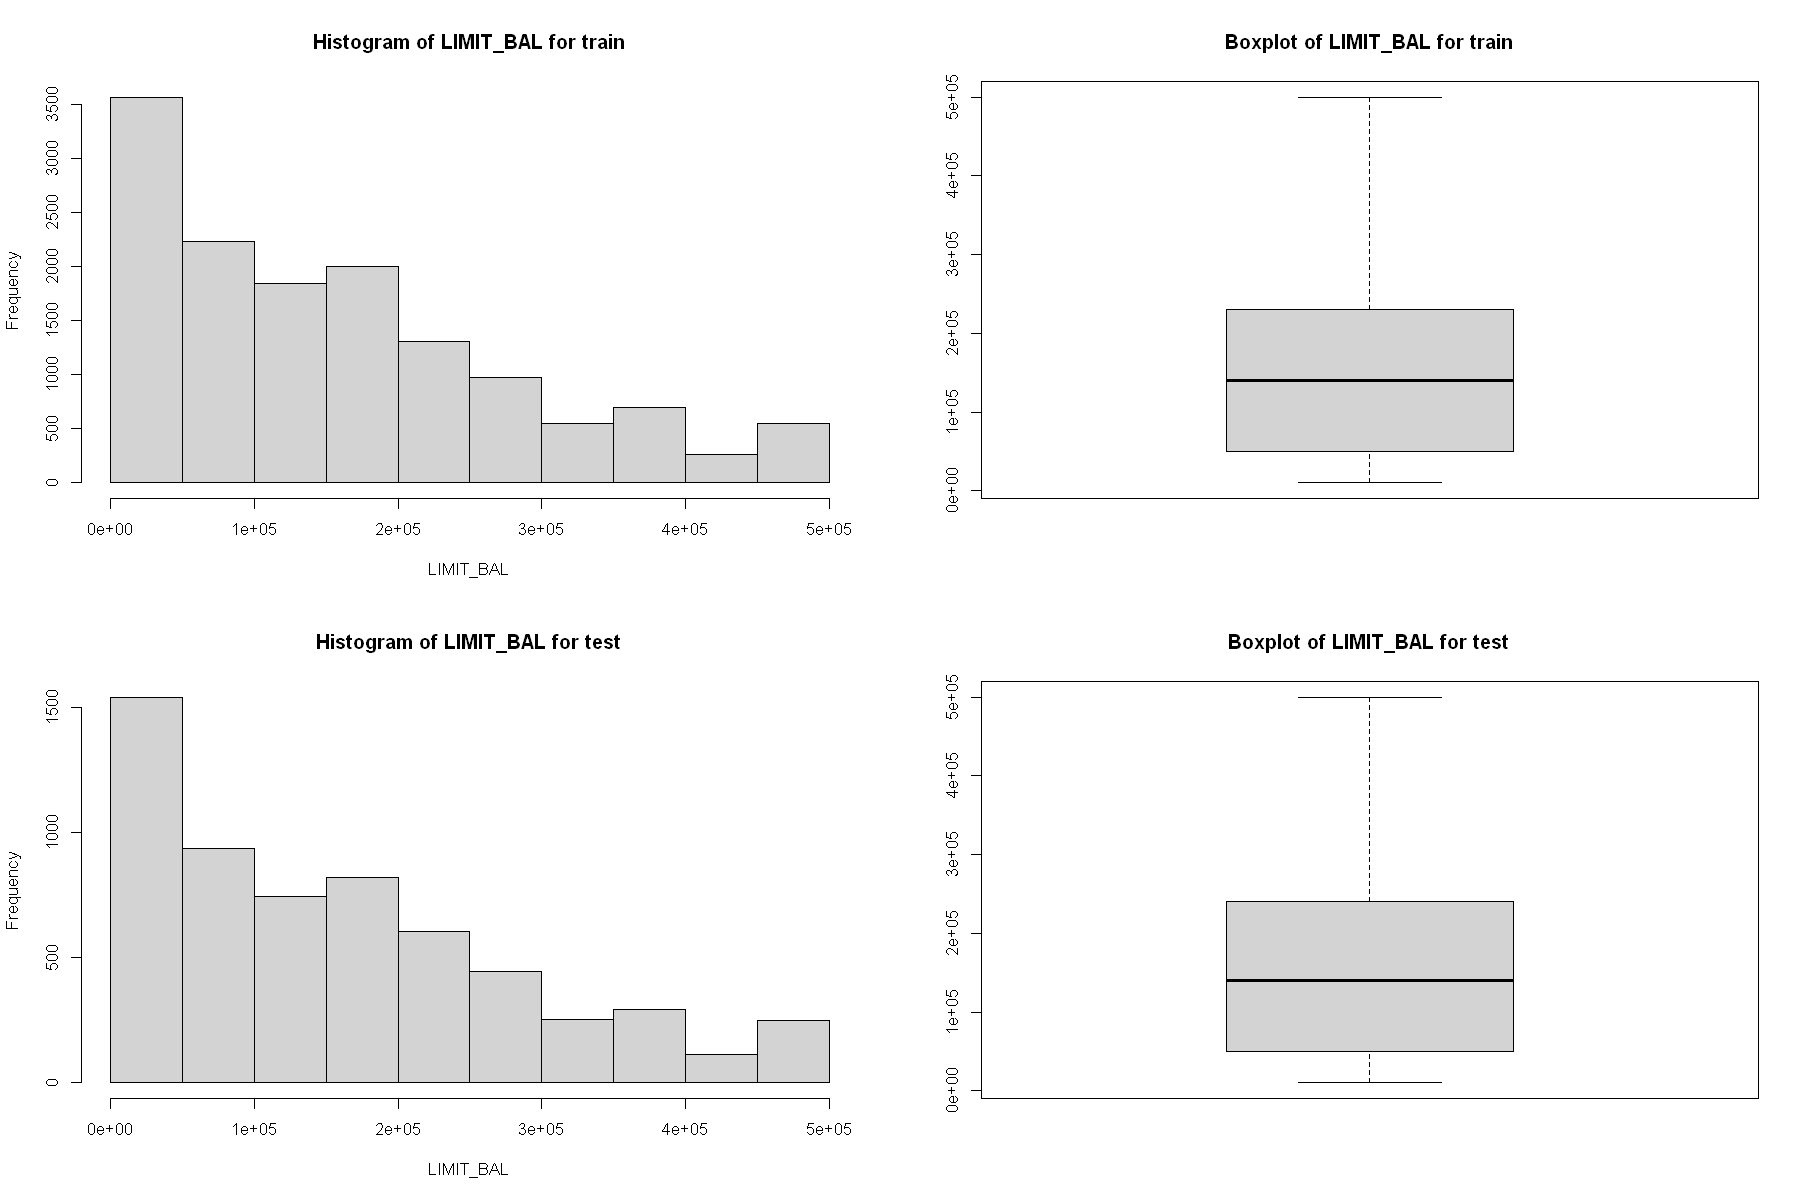

In [157]:
par(mfrow=c(2,2))

hist(train$LIMIT_BAL,xlab = "LIMIT_BAL",main = "Histogram of LIMIT_BAL for train")
boxplot(train$LIMIT_BAL, horizontal=FALSE,main = "Boxplot of LIMIT_BAL for train")

hist(test$LIMIT_BAL,xlab = "LIMIT_BAL",main = "Histogram of LIMIT_BAL for test")
boxplot(test$LIMIT_BAL, horizontal=FALSE,main = "Boxplot of LIMIT_BAL for test")

print(max(train$LIMIT_BAL))
print(max(test$LIMIT_BAL))

### III.2. Outliers in : BILL_AMT1, BILL_AMT2, BILL_AMT3, BILL_AMT4, BILL_AMT5, BILL_AMT6

##### BILL_AMT1

In [158]:
summary(train$BILL_AMT1)
summary(test$BILL_AMT1)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-165580    3718   23397   51154   66471  964511 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -14386    3266   21370   50781   63229  746814 

[1] 964511
[1] 746814
[1] -165580
[1] -14386


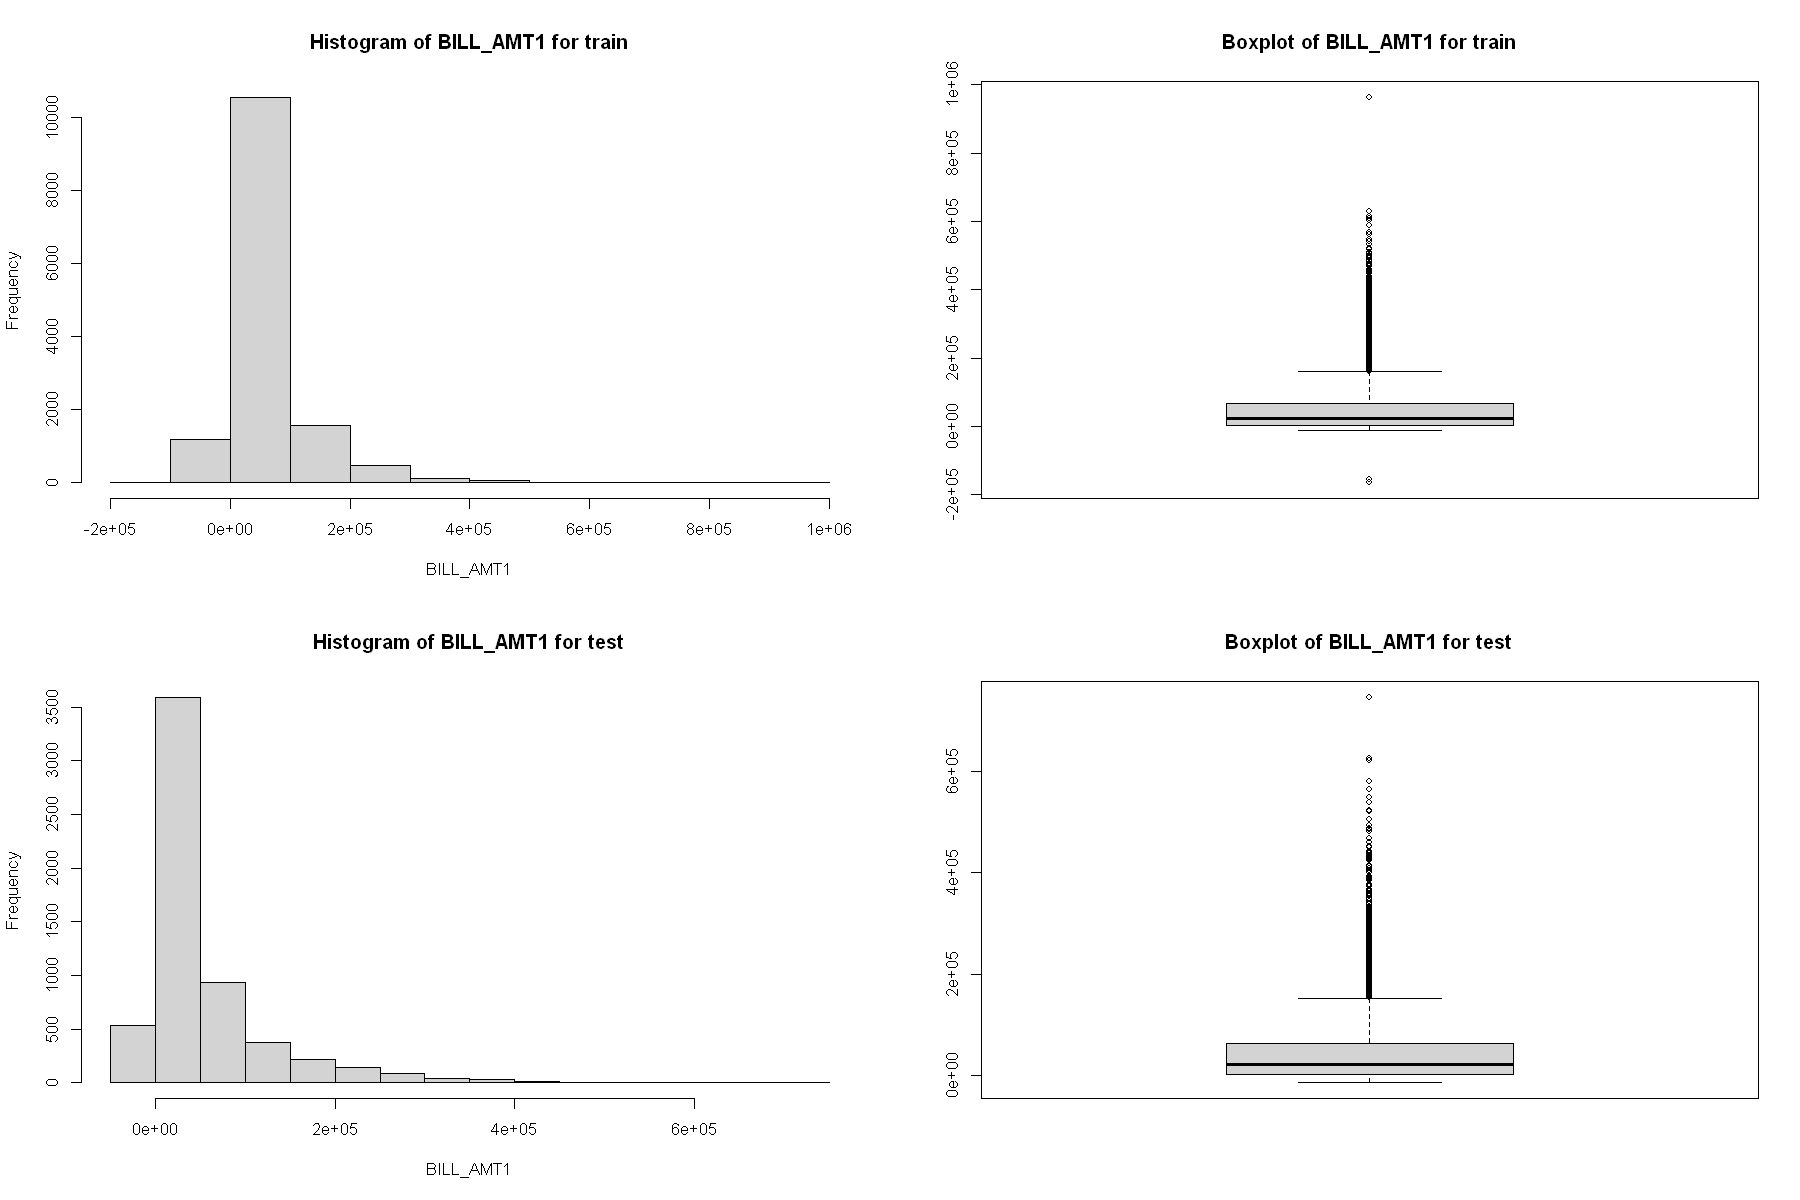

In [159]:
par(mfrow=c(2,2))

hist(train$BILL_AMT1,xlab = "BILL_AMT1",main = "Histogram of BILL_AMT1 for train")
boxplot(train$BILL_AMT1, horizontal=FALSE,main = "Boxplot of BILL_AMT1 for train")

hist(test$BILL_AMT1,xlab = "BILL_AMT1",main = "Histogram of BILL_AMT1 for test")
boxplot(test$BILL_AMT1, horizontal=FALSE,main = "Boxplot of BILL_AMT1 for test")

print(max(train$BILL_AMT1))
print(max(test$BILL_AMT1))

print(min(train$BILL_AMT1))
print(min(test$BILL_AMT1))

In [160]:
# The 1st Quartile (25%)
first_quart_BILL_AMT1 <- summary(train$BILL_AMT1)[2]

# The 3rd Quartile (75%)
third_quart_BILL_AMT1 <- summary(train$BILL_AMT1)[5]

# Setting a benchmark 
neg_benchark_BILL_AMT1 <- first_quart_BILL_AMT1 - 1.5*IQR(train$BILL_AMT1) # Q1 - 1.5 * IQR
pos_benchark_BILL_AMT1 <- third_quart_BILL_AMT1 + 1.5*IQR(train$BILL_AMT1) # Q3 + 1.5 * IQR

# Winsorizing the train set
train$BILL_AMT1[train$BILL_AMT1 > pos_benchark_BILL_AMT1] <- pos_benchark_BILL_AMT1
train$BILL_AMT1[train$BILL_AMT1 < neg_benchark_BILL_AMT1] <- neg_benchark_BILL_AMT1

# Winsorizing the test set
test$BILL_AMT1[test$BILL_AMT1 > pos_benchark_BILL_AMT1] <- pos_benchark_BILL_AMT1
test$BILL_AMT1[test$BILL_AMT1 < neg_benchark_BILL_AMT1] <- neg_benchark_BILL_AMT1

In [161]:
summary(train$BILL_AMT1)
summary(test$BILL_AMT1)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -90410    3718   23397   44260   66471  160599 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -14386    3266   21370   43131   63229  160599 

##### BILL_AMT2

In [162]:
summary(train$BILL_AMT2)
summary(test$BILL_AMT2)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -69777    3166   22310   49028   62661  983931 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -24702    2834   20172   48795   60439  743970 

[1] 983931
[1] 743970
[1] -69777
[1] -24702


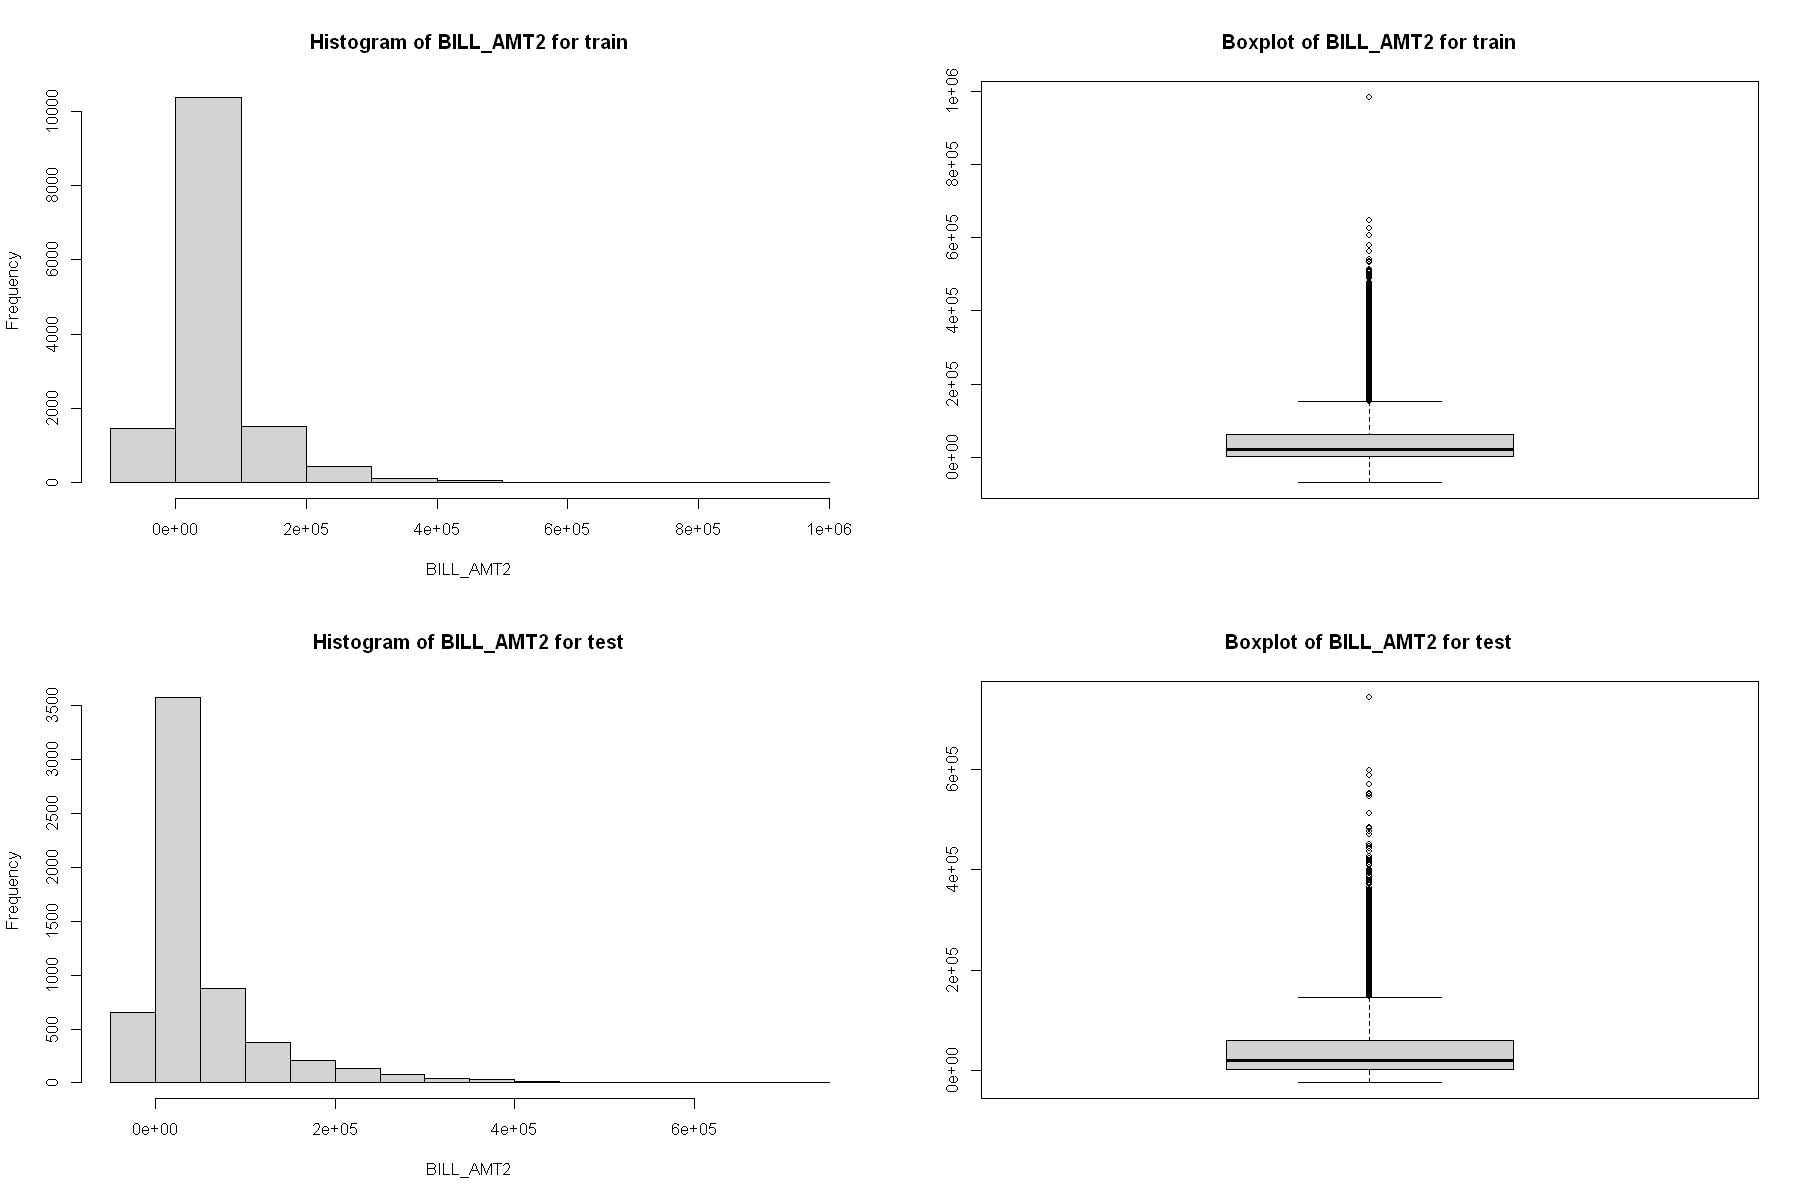

In [163]:
par(mfrow=c(2,2))

hist(train$BILL_AMT2,xlab = "BILL_AMT2",main = "Histogram of BILL_AMT2 for train")
boxplot(train$BILL_AMT2, horizontal=FALSE,main = "Boxplot of BILL_AMT2 for train")

hist(test$BILL_AMT2,xlab = "BILL_AMT2",main = "Histogram of BILL_AMT2 for test")
boxplot(test$BILL_AMT2, horizontal=FALSE,main = "Boxplot of BILL_AMT2 for test")

print(max(train$BILL_AMT2))
print(max(test$BILL_AMT2))

print(min(train$BILL_AMT2))
print(min(test$BILL_AMT2))

In [164]:
# The 1st Quartile (25%)
first_quart_BILL_AMT2 <- summary(train$BILL_AMT2)[2]

# The 3rd Quartile (75%)
third_quart_BILL_AMT2 <- summary(train$BILL_AMT2)[5]

# Setting a benchmark 
neg_benchark_BILL_AMT2 <- first_quart_BILL_AMT2 - 1.5*IQR(train$BILL_AMT2) # Q1 - 1.5 * IQR
pos_benchark_BILL_AMT2 <- third_quart_BILL_AMT2 + 1.5*IQR(train$BILL_AMT2) # Q3 + 1.5 * IQR

# Winsorizing the train set
train$BILL_AMT2[train$BILL_AMT2 > pos_benchark_BILL_AMT2] <- pos_benchark_BILL_AMT2
train$BILL_AMT2[train$BILL_AMT2 < neg_benchark_BILL_AMT2] <- neg_benchark_BILL_AMT2

# Winsorizing the test set
test$BILL_AMT2[test$BILL_AMT2 > pos_benchark_BILL_AMT2] <- pos_benchark_BILL_AMT2
test$BILL_AMT2[test$BILL_AMT2 < neg_benchark_BILL_AMT2] <- neg_benchark_BILL_AMT2

In [165]:
summary(train$BILL_AMT2)
summary(test$BILL_AMT2)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -69777    3166   22310   42172   62661  151903 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -24702    2834   20172   41067   60439  151903 

##### BILL_AMT3

In [166]:
summary(train$BILL_AMT3)
summary(test$BILL_AMT3)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -25443    2928   20555   47029   60063 1664089 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -61506    2419   19560   46605   56763  689643 

[1] 1664089
[1] 689643
[1] -25443
[1] -61506


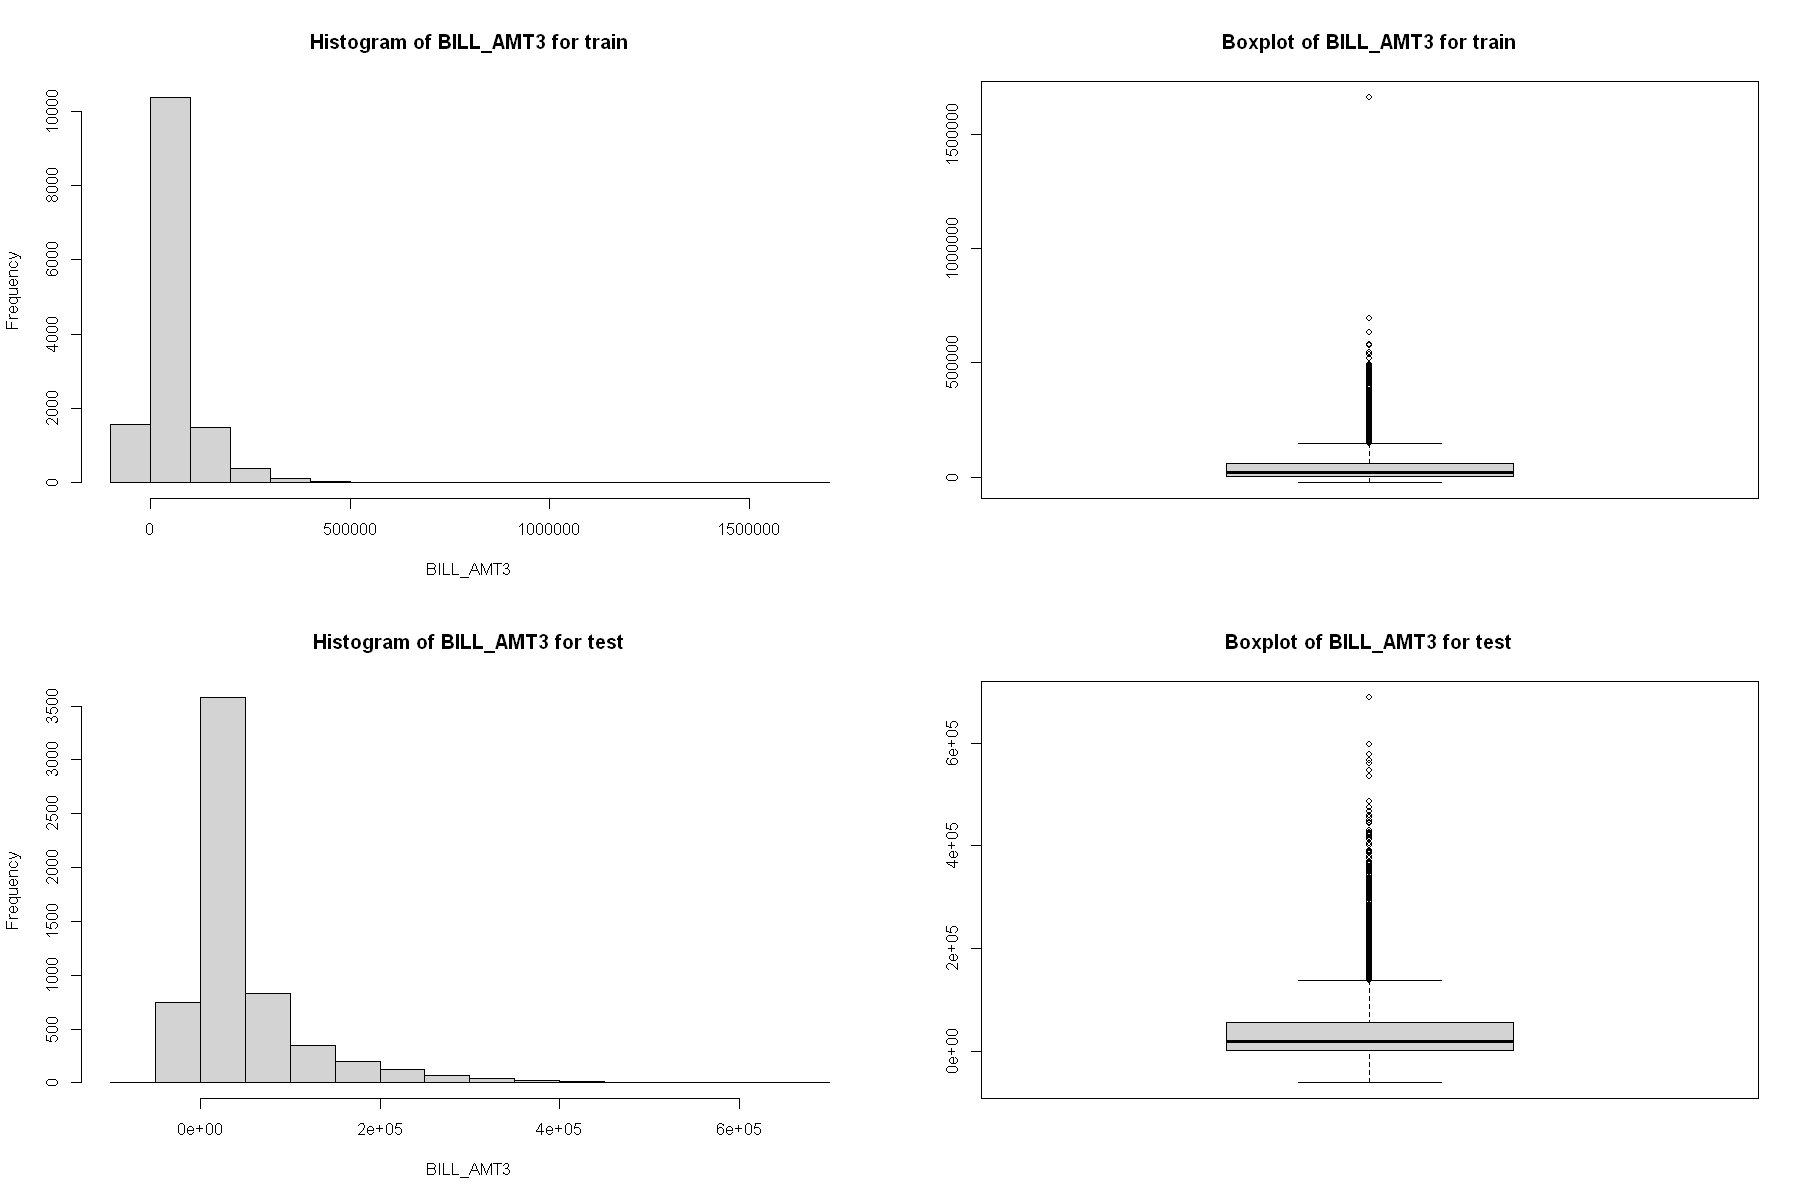

In [167]:
par(mfrow=c(2,2))

hist(train$BILL_AMT3,xlab = "BILL_AMT3",main = "Histogram of BILL_AMT3 for train")
boxplot(train$BILL_AMT3, horizontal=FALSE,main = "Boxplot of BILL_AMT3 for train")

hist(test$BILL_AMT3,xlab = "BILL_AMT3",main = "Histogram of BILL_AMT3 for test")
boxplot(test$BILL_AMT3, horizontal=FALSE,main = "Boxplot of BILL_AMT3 for test")

print(max(train$BILL_AMT3))
print(max(test$BILL_AMT3))

print(min(train$BILL_AMT3))
print(min(test$BILL_AMT3))

In [168]:
# The 1st Quartile (25%)
first_quart_BILL_AMT3 <- summary(train$BILL_AMT3)[2]

# The 3rd Quartile (75%)
third_quart_BILL_AMT3 <- summary(train$BILL_AMT3)[5]

# Setting a benchmark 
neg_benchark_BILL_AMT3 <- first_quart_BILL_AMT3 - 1.5*IQR(train$BILL_AMT3) # Q1 - 1.5 * IQR
pos_benchark_BILL_AMT3 <- third_quart_BILL_AMT3 + 1.5*IQR(train$BILL_AMT3) # Q3 + 1.5 * IQR

# Winsorizing the train set
train$BILL_AMT3[train$BILL_AMT3 > pos_benchark_BILL_AMT3] <- pos_benchark_BILL_AMT3
train$BILL_AMT3[train$BILL_AMT3 < neg_benchark_BILL_AMT3] <- neg_benchark_BILL_AMT3

# Winsorizing the test set
test$BILL_AMT3[test$BILL_AMT3 > pos_benchark_BILL_AMT3] <- pos_benchark_BILL_AMT3
test$BILL_AMT3[test$BILL_AMT3 < neg_benchark_BILL_AMT3] <- neg_benchark_BILL_AMT3

In [169]:
summary(train$BILL_AMT3)
summary(test$BILL_AMT3)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -25443    2928   20555   40325   60063  145766 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -61506    2419   19560   39056   56763  145766 

##### BILL_AMT4

In [170]:
summary(train$BILL_AMT4)
summary(test$BILL_AMT4)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -81334    2452   19463   43077   54489  891586 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-170000    2013   18427   42984   51629  572805 

[1] 891586
[1] 572805
[1] -81334
[1] -170000


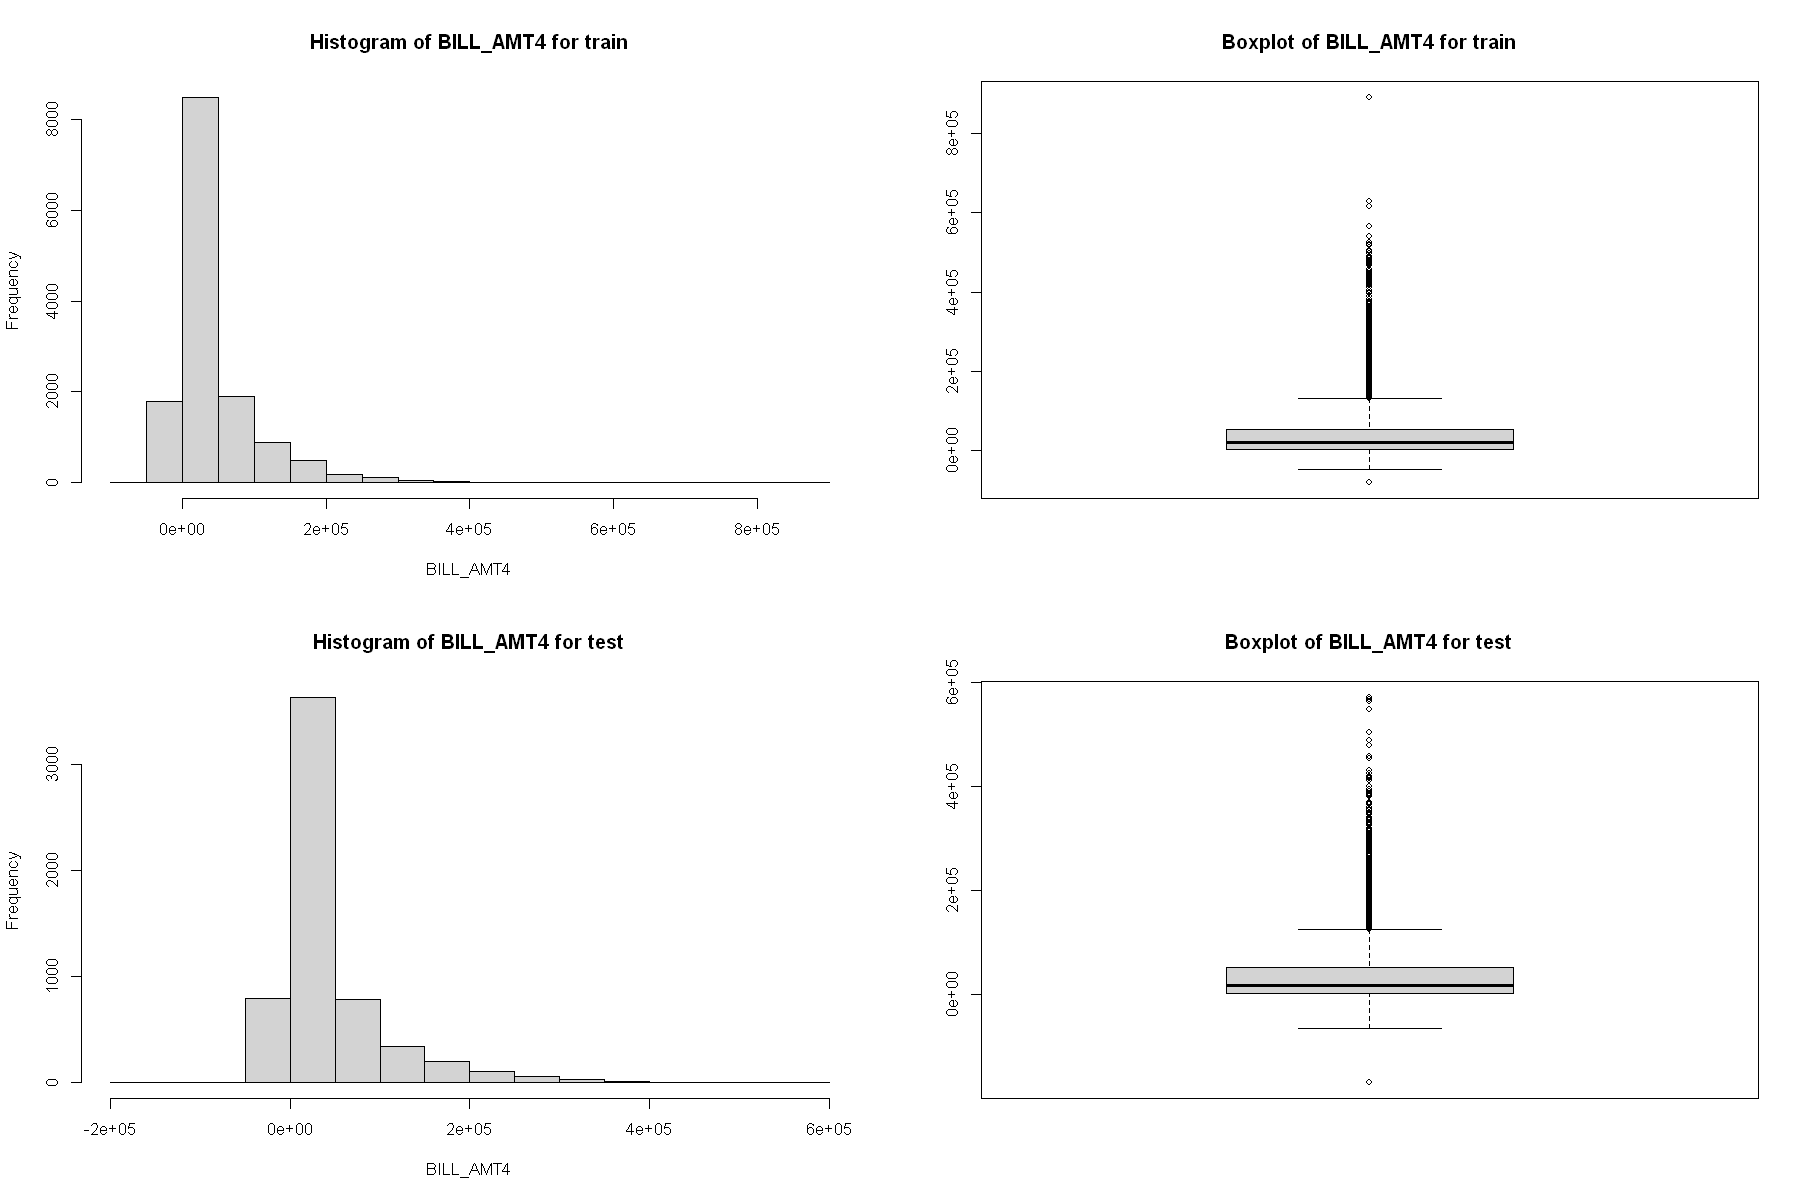

In [171]:
par(mfrow=c(2,2))

hist(train$BILL_AMT4,xlab = "BILL_AMT4",main = "Histogram of BILL_AMT4 for train")
boxplot(train$BILL_AMT4, horizontal=FALSE,main = "Boxplot of BILL_AMT4 for train")

hist(test$BILL_AMT4,xlab = "BILL_AMT4",main = "Histogram of BILL_AMT4 for test")
boxplot(test$BILL_AMT4, horizontal=FALSE,main = "Boxplot of BILL_AMT4 for test")

print(max(train$BILL_AMT4))
print(max(test$BILL_AMT4))

print(min(train$BILL_AMT4))
print(min(test$BILL_AMT4))

In [172]:
# The 1st Quartile (25%)
first_quart_BILL_AMT4 <- summary(train$BILL_AMT4)[2]

# The 3rd Quartile (75%)
third_quart_BILL_AMT4 <- summary(train$BILL_AMT4)[5]

# Setting a benchmark 
neg_benchark_BILL_AMT4 <- first_quart_BILL_AMT4 - 1.5*IQR(train$BILL_AMT4) # Q1 - 1.5 * IQR
pos_benchark_BILL_AMT4 <- third_quart_BILL_AMT4 + 1.5*IQR(train$BILL_AMT4) # Q3 + 1.5 * IQR

# Winsorizing the train set
train$BILL_AMT4[train$BILL_AMT4 > pos_benchark_BILL_AMT4] <- pos_benchark_BILL_AMT4
train$BILL_AMT4[train$BILL_AMT4 < neg_benchark_BILL_AMT4] <- neg_benchark_BILL_AMT4

# Winsorizing the test set
test$BILL_AMT4[test$BILL_AMT4 > pos_benchark_BILL_AMT4] <- pos_benchark_BILL_AMT4
test$BILL_AMT4[test$BILL_AMT4 < neg_benchark_BILL_AMT4] <- neg_benchark_BILL_AMT4

In [173]:
summary(train$BILL_AMT4)
summary(test$BILL_AMT4)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -75603    2452   19463   36643   54489  132544 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -75603    2013   18427   35827   51629  132544 

##### BILL_AMT5

In [174]:
summary(train$BILL_AMT5)
summary(test$BILL_AMT5)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -81334    1913   18541   40261   50247  927171 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -53007    1516   17738   40093   48713  823540 

[1] 927171
[1] 823540
[1] -81334
[1] -53007


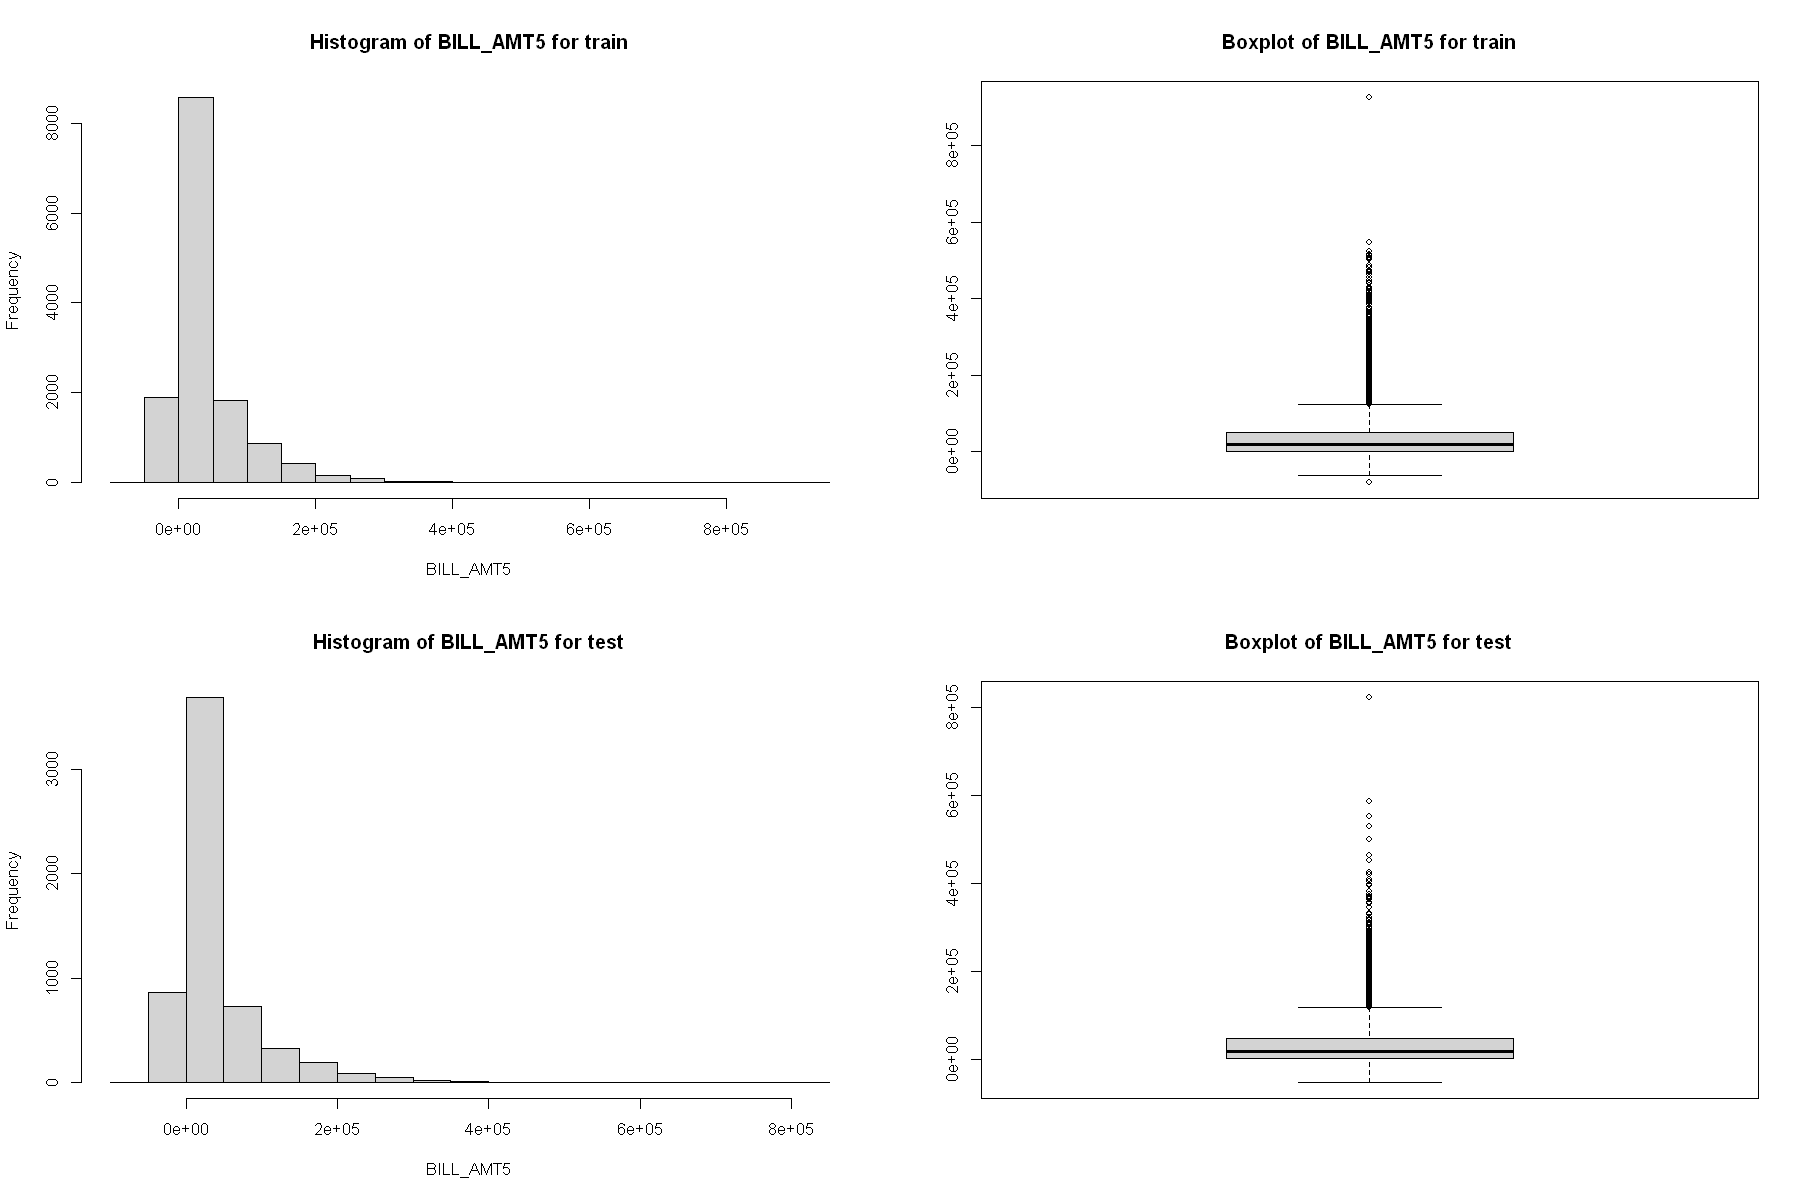

In [175]:
par(mfrow=c(2,2))

hist(train$BILL_AMT5,xlab = "BILL_AMT5",main = "Histogram of BILL_AMT5 for train")
boxplot(train$BILL_AMT5, horizontal=FALSE,main = "Boxplot of BILL_AMT5 for train")

hist(test$BILL_AMT5,xlab = "BILL_AMT5",main = "Histogram of BILL_AMT5 for test")
boxplot(test$BILL_AMT5, horizontal=FALSE,main = "Boxplot of BILL_AMT5 for test")

print(max(train$BILL_AMT5))
print(max(test$BILL_AMT5))

print(min(train$BILL_AMT5))
print(min(test$BILL_AMT5))

In [176]:
# The 1st Quartile (25%)
first_quart_BILL_AMT5 <- summary(train$BILL_AMT5)[2]

# The 3rd Quartile (75%)
third_quart_BILL_AMT5 <- summary(train$BILL_AMT5)[5]

# Setting a benchmark 
neg_benchark_BILL_AMT5 <- first_quart_BILL_AMT5 - 1.5*IQR(train$BILL_AMT5) # Q1 - 1.5 * IQR
pos_benchark_BILL_AMT5 <- third_quart_BILL_AMT5 + 1.5*IQR(train$BILL_AMT5) # Q3 + 1.5 * IQR

# Winsorizing the train set
train$BILL_AMT5[train$BILL_AMT5 > pos_benchark_BILL_AMT5] <- pos_benchark_BILL_AMT5
train$BILL_AMT5[train$BILL_AMT5 < neg_benchark_BILL_AMT5] <- neg_benchark_BILL_AMT5

# Winsorizing the test set
test$BILL_AMT5[test$BILL_AMT5 > pos_benchark_BILL_AMT5] <- pos_benchark_BILL_AMT5
test$BILL_AMT5[test$BILL_AMT5 < neg_benchark_BILL_AMT5] <- neg_benchark_BILL_AMT5

In [177]:
summary(train$BILL_AMT5)
summary(test$BILL_AMT5)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -70589    1913   18541   33967   50247  122749 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -53007    1516   17738   33123   48713  122749 

##### BILL_AMT6

In [178]:
summary(train$BILL_AMT6)
summary(test$BILL_AMT6)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-209051    1383   17585   38835   48933  961664 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-339603    1132   16888   38715   47622  699944 

[1] 961664
[1] 699944
[1] -209051
[1] -339603


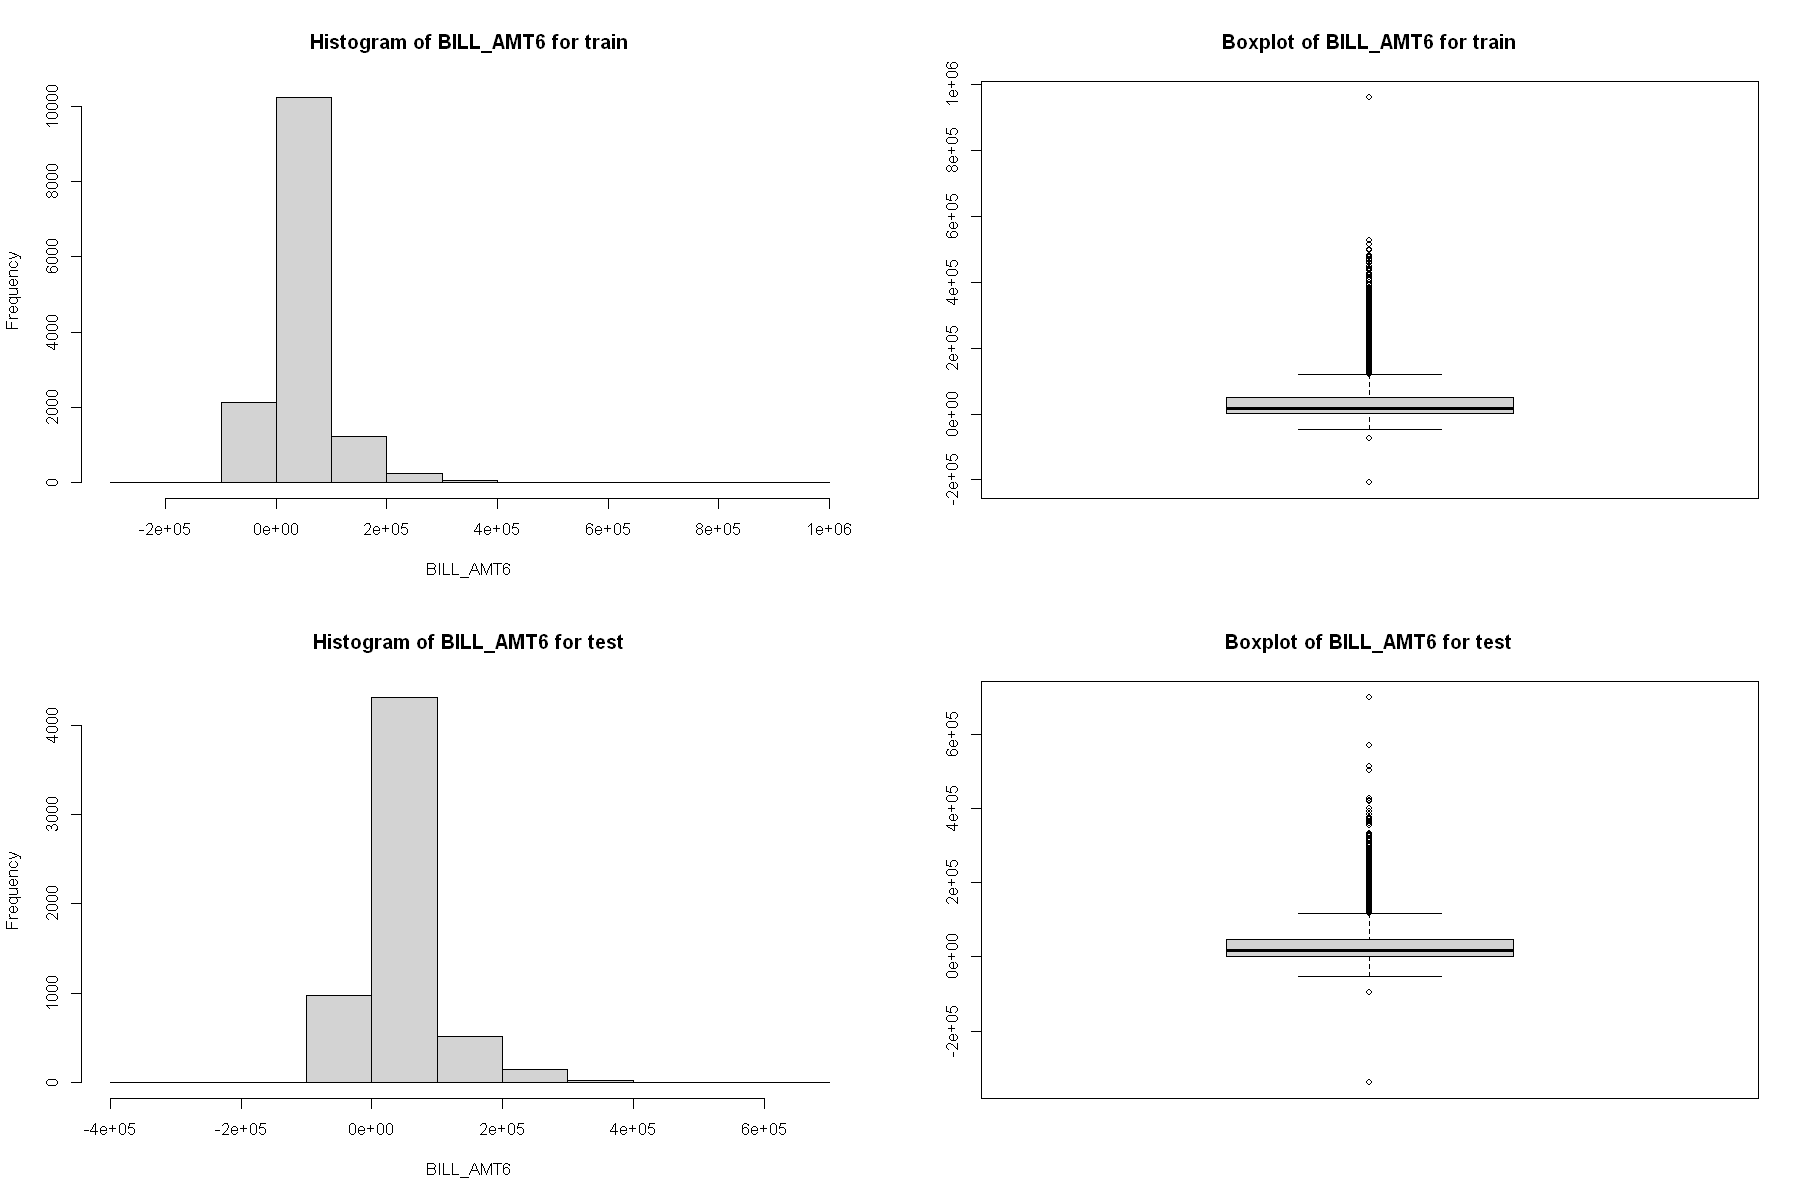

In [179]:
par(mfrow=c(2,2))

hist(train$BILL_AMT6,xlab = "BILL_AMT6",main = "Histogram of BILL_AMT6 for train")
boxplot(train$BILL_AMT6, horizontal=FALSE,main = "Boxplot of BILL_AMT6 for train")

hist(test$BILL_AMT6,xlab = "BILL_AMT6",main = "Histogram of BILL_AMT6 for test")
boxplot(test$BILL_AMT6, horizontal=FALSE,main = "Boxplot of BILL_AMT6 for test")

print(max(train$BILL_AMT6))
print(max(test$BILL_AMT6))

print(min(train$BILL_AMT6))
print(min(test$BILL_AMT6))

In [180]:
# The 1st Quartile (25%)
first_quart_BILL_AMT6 <- summary(train$BILL_AMT6)[2]

# The 3rd Quartile (75%)
third_quart_BILL_AMT6 <- summary(train$BILL_AMT6)[5]

# Setting a benchmark 
neg_benchark_BILL_AMT6 <- first_quart_BILL_AMT6 - 1.5*IQR(train$BILL_AMT6) # Q1 - 1.5 * IQR
pos_benchark_BILL_AMT6 <- third_quart_BILL_AMT6 + 1.5*IQR(train$BILL_AMT6) # Q3 + 1.5 * IQR

# Winsorizing the train set
train$BILL_AMT6[train$BILL_AMT6 > pos_benchark_BILL_AMT6] <- pos_benchark_BILL_AMT6
train$BILL_AMT6[train$BILL_AMT6 < neg_benchark_BILL_AMT4] <- neg_benchark_BILL_AMT6

# Winsorizing the test set
test$BILL_AMT6[test$BILL_AMT6 > pos_benchark_BILL_AMT6] <- pos_benchark_BILL_AMT6
test$BILL_AMT6[test$BILL_AMT6 < neg_benchark_BILL_AMT6] <- neg_benchark_BILL_AMT6

In [181]:
summary(train$BILL_AMT6)
summary(test$BILL_AMT6)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -73895    1383   17585   32642   48933  120258 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -69942    1132   16888   32070   47622  120258 

### III.3. Outliers in : PAY_AMT1, PAY_AMT2, PAY_AMT3, PAY_AMT4, PAY_AMT5, PAY_AMT6

##### PAY_AMT1

In [182]:
summary(train$PAY_AMT1)
summary(test$PAY_AMT1)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0    1000    2109    5468    5066  505000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0     896    2098    5560    5141  493358 

[1] 505000
[1] 493358
[1] 0
[1] 0


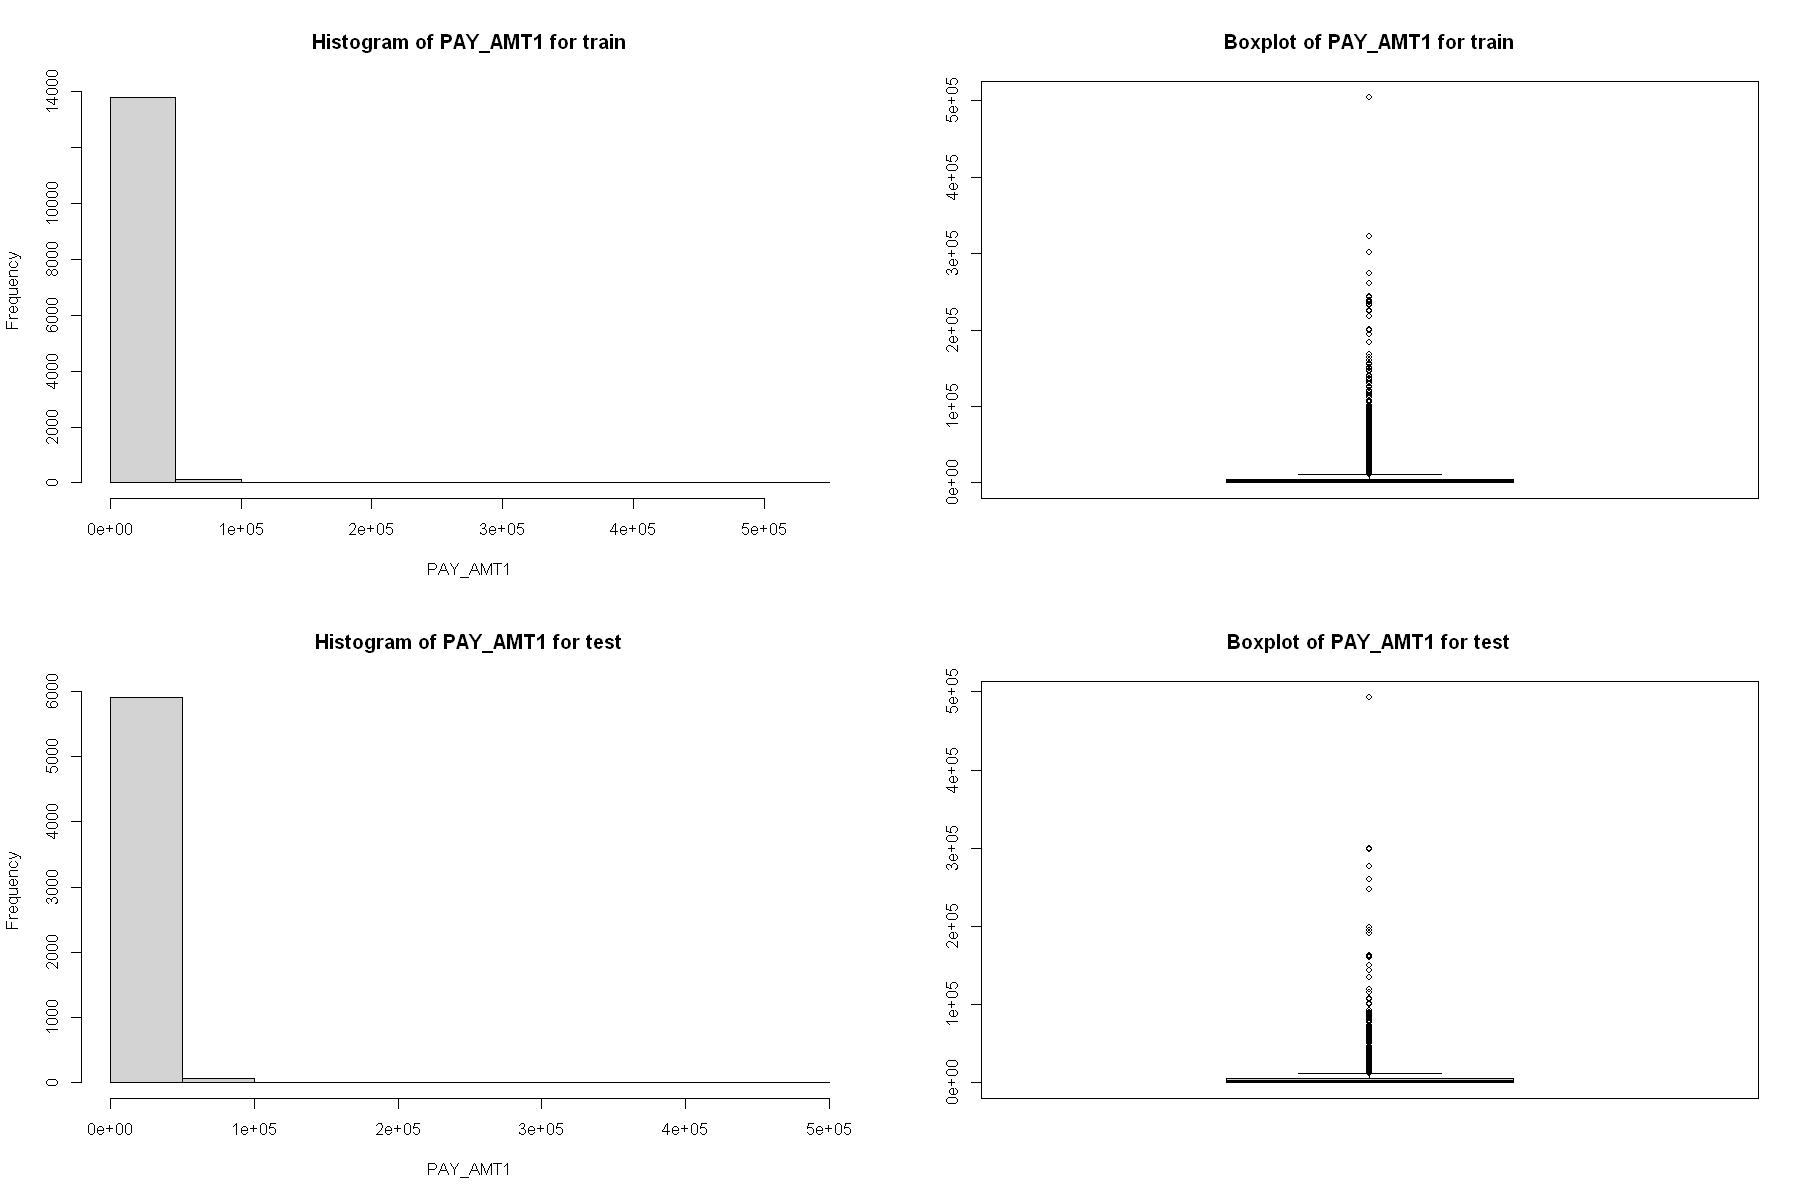

In [183]:
par(mfrow=c(2,2))

hist(train$PAY_AMT1,xlab = "PAY_AMT1",main = "Histogram of PAY_AMT1 for train")
boxplot(train$PAY_AMT1, horizontal=FALSE,main = "Boxplot of PAY_AMT1 for train")

hist(test$PAY_AMT1,xlab = "PAY_AMT1",main = "Histogram of PAY_AMT1 for test")
boxplot(test$PAY_AMT1, horizontal=FALSE,main = "Boxplot of PAY_AMT1 for test")

print(max(train$PAY_AMT1))
print(max(test$PAY_AMT1))

print(min(train$PAY_AMT1))
print(min(test$PAY_AMT1))

In [184]:
# The 1st Quartile (25%)
first_quart_PAY_AMT1 <- summary(train$PAY_AMT1)[2]

# The 3rd Quartile (75%)
third_quart_PAY_AMT1 <- summary(train$PAY_AMT1)[5]

# Setting a benchmark 
neg_benchark_PAY_AMT1 <- first_quart_PAY_AMT1 - 1.5*IQR(train$PAY_AMT1) # Q1 - 1.5 * IQR
pos_benchark_PAY_AMT1 <- third_quart_PAY_AMT1 + 1.5*IQR(train$PAY_AMT1) # Q3 + 1.5 * IQR

# Winsorizing the train set
train$PAY_AMT1[train$PAY_AMT1 > pos_benchark_PAY_AMT1] <- pos_benchark_PAY_AMT1
train$PAY_AMT1[train$PAY_AMT1 < neg_benchark_PAY_AMT1] <- neg_benchark_PAY_AMT1

# Winsorizing the test set
test$PAY_AMT1[test$PAY_AMT1 > pos_benchark_PAY_AMT1] <- pos_benchark_PAY_AMT1
test$PAY_AMT1[test$PAY_AMT1 < neg_benchark_PAY_AMT1] <- neg_benchark_PAY_AMT1

In [185]:
summary(train$PAY_AMT1)
summary(test$PAY_AMT1)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0    1000    2109    3501    5066   11166 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0     896    2098    3529    5141   11166 

##### PAY_AMT2

In [186]:
summary(train$PAY_AMT2)
summary(test$PAY_AMT2)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
      0.0     969.2    2037.0    5774.4    5000.0 1684259.0 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0     792    2002    5891    5015 1227082 

[1] 1684259
[1] 1227082
[1] 0
[1] 0


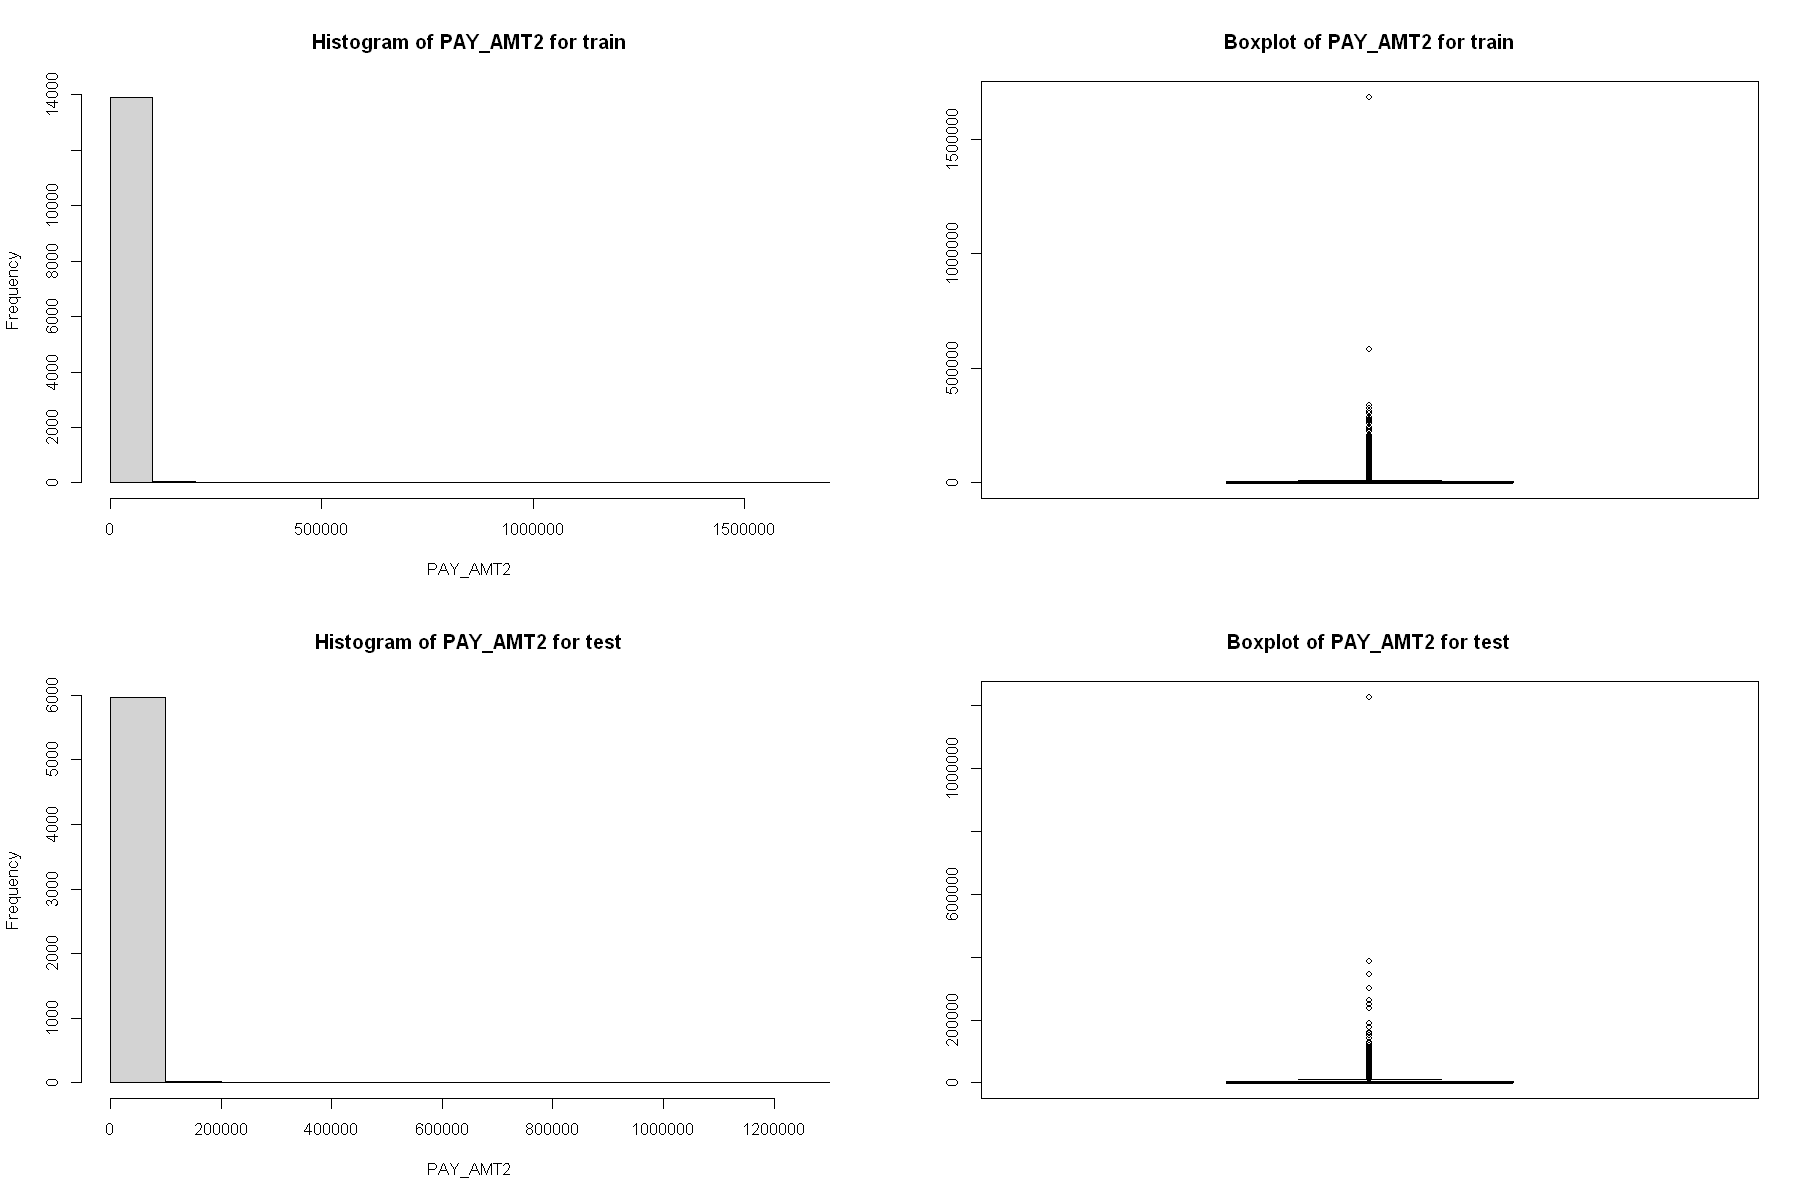

In [187]:
par(mfrow=c(2,2))

hist(train$PAY_AMT2,xlab = "PAY_AMT2",main = "Histogram of PAY_AMT2 for train")
boxplot(train$PAY_AMT2, horizontal=FALSE,main = "Boxplot of PAY_AMT2 for train")

hist(test$PAY_AMT2,xlab = "PAY_AMT2",main = "Histogram of PAY_AMT2 for test")
boxplot(test$PAY_AMT2, horizontal=FALSE,main = "Boxplot of PAY_AMT2 for test")

print(max(train$PAY_AMT2))
print(max(test$PAY_AMT2))

print(min(train$PAY_AMT2))
print(min(test$PAY_AMT2))

In [188]:
# The 1st Quartile (25%)
first_quart_PAY_AMT2 <- summary(train$PAY_AMT2)[2]

# The 3rd Quartile (75%)
third_quart_PAY_AMT2 <- summary(train$PAY_AMT2)[5]

# Setting a benchmark 
neg_benchark_PAY_AMT2 <- first_quart_PAY_AMT2 - 1.5*IQR(train$PAY_AMT2) # Q1 - 1.5 * IQR
pos_benchark_PAY_AMT2 <- third_quart_PAY_AMT2 + 1.5*IQR(train$PAY_AMT2) # Q3 + 1.5 * IQR

# Winsorizing the train set
train$PAY_AMT2[train$PAY_AMT2 > pos_benchark_PAY_AMT2] <- pos_benchark_PAY_AMT2
train$PAY_AMT2[train$PAY_AMT2 < neg_benchark_PAY_AMT2] <- neg_benchark_PAY_AMT2

# Winsorizing the test set
test$PAY_AMT2[test$PAY_AMT2 > pos_benchark_PAY_AMT2] <- pos_benchark_PAY_AMT2
test$PAY_AMT2[test$PAY_AMT2 < neg_benchark_PAY_AMT2] <- neg_benchark_PAY_AMT2

In [189]:
summary(train$PAY_AMT2)
summary(test$PAY_AMT2)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0   969.2  2037.0  3422.0  5000.0 11046.1 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0     792    2002    3457    5015   11046 

##### PAY_AMT3

In [190]:
summary(train$PAY_AMT3)
summary(test$PAY_AMT3)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0     400    1862    5139    4627  896040 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0     390    1800    5367    4709  400972 

[1] 896040
[1] 400972
[1] 0
[1] 0


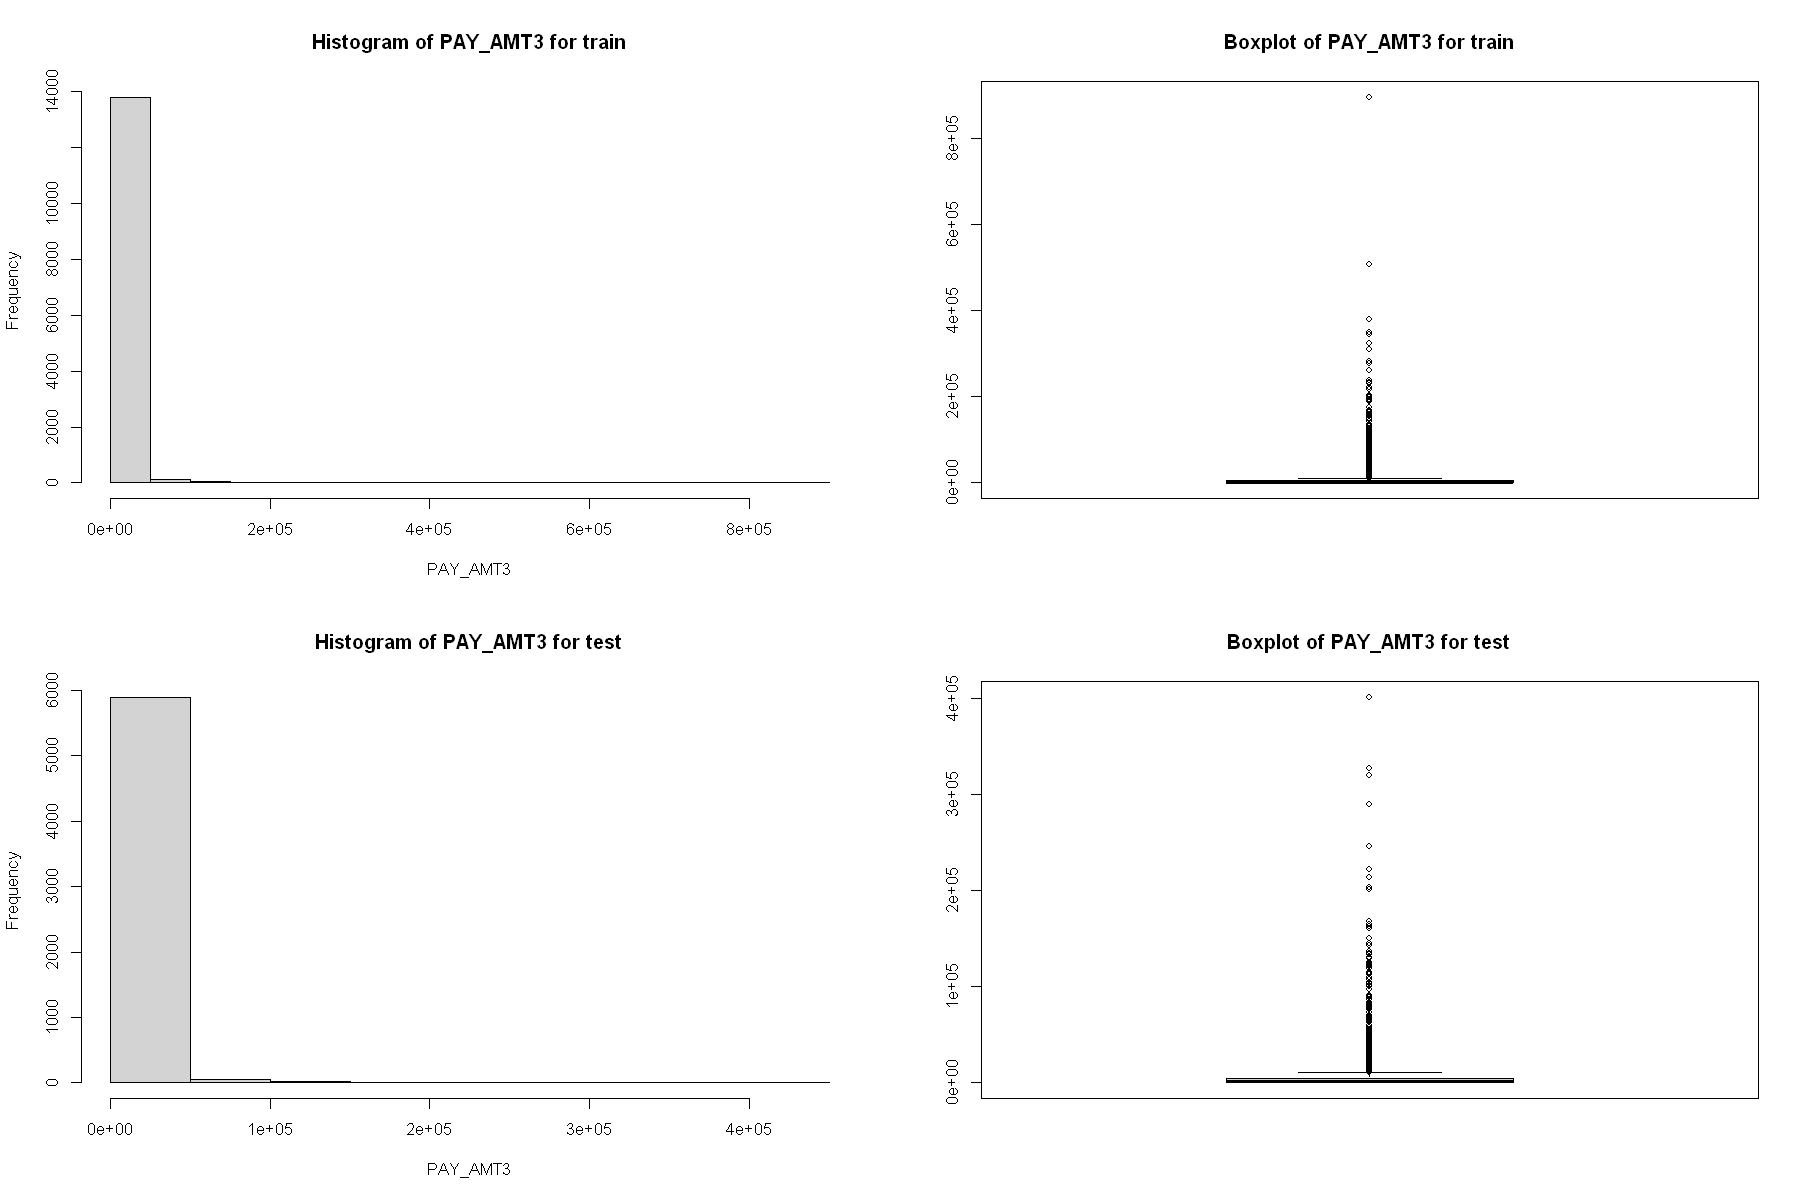

In [191]:
par(mfrow=c(2,2))

hist(train$PAY_AMT3,xlab = "PAY_AMT3",main = "Histogram of PAY_AMT3 for train")
boxplot(train$PAY_AMT3, horizontal=FALSE,main = "Boxplot of PAY_AMT3 for train")

hist(test$PAY_AMT3,xlab = "PAY_AMT3",main = "Histogram of PAY_AMT3 for test")
boxplot(test$PAY_AMT3, horizontal=FALSE,main = "Boxplot of PAY_AMT3 for test")

print(max(train$PAY_AMT3))
print(max(test$PAY_AMT3))

print(min(train$PAY_AMT3))
print(min(test$PAY_AMT3))

In [192]:
# The 1st Quartile (25%)
first_quart_PAY_AMT3 <- summary(train$PAY_AMT3)[2]

# The 3rd Quartile (75%)
third_quart_PAY_AMT3 <- summary(train$PAY_AMT3)[5]

# Setting a benchmark 
neg_benchark_PAY_AMT3 <- first_quart_PAY_AMT3 - 1.5*IQR(train$PAY_AMT3) # Q1 - 1.5 * IQR
pos_benchark_PAY_AMT3 <- third_quart_PAY_AMT3 + 1.5*IQR(train$PAY_AMT3) # Q3 + 1.5 * IQR

# Winsorizing the train set
train$PAY_AMT3[train$PAY_AMT3 > pos_benchark_PAY_AMT3] <- pos_benchark_PAY_AMT3
train$PAY_AMT3[train$PAY_AMT3 < neg_benchark_PAY_AMT3] <- neg_benchark_PAY_AMT3

# Winsorizing the test set
test$PAY_AMT3[test$PAY_AMT3 > pos_benchark_PAY_AMT3] <- pos_benchark_PAY_AMT3
test$PAY_AMT3[test$PAY_AMT3 < neg_benchark_PAY_AMT3] <- neg_benchark_PAY_AMT3

In [193]:
summary(train$PAY_AMT3)
summary(test$PAY_AMT3)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0     400    1862    3050    4627   10968 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0     390    1800    3060    4709   10968 

##### PAY_AMT4

In [194]:
summary(train$PAY_AMT4)
summary(test$PAY_AMT4)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
     0.0    306.8   1514.5   4743.8   4200.0 528897.0 

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
     0.0    267.8   1500.0   4917.3   4100.0 497000.0 

[1] 528897
[1] 497000
[1] 0
[1] 0


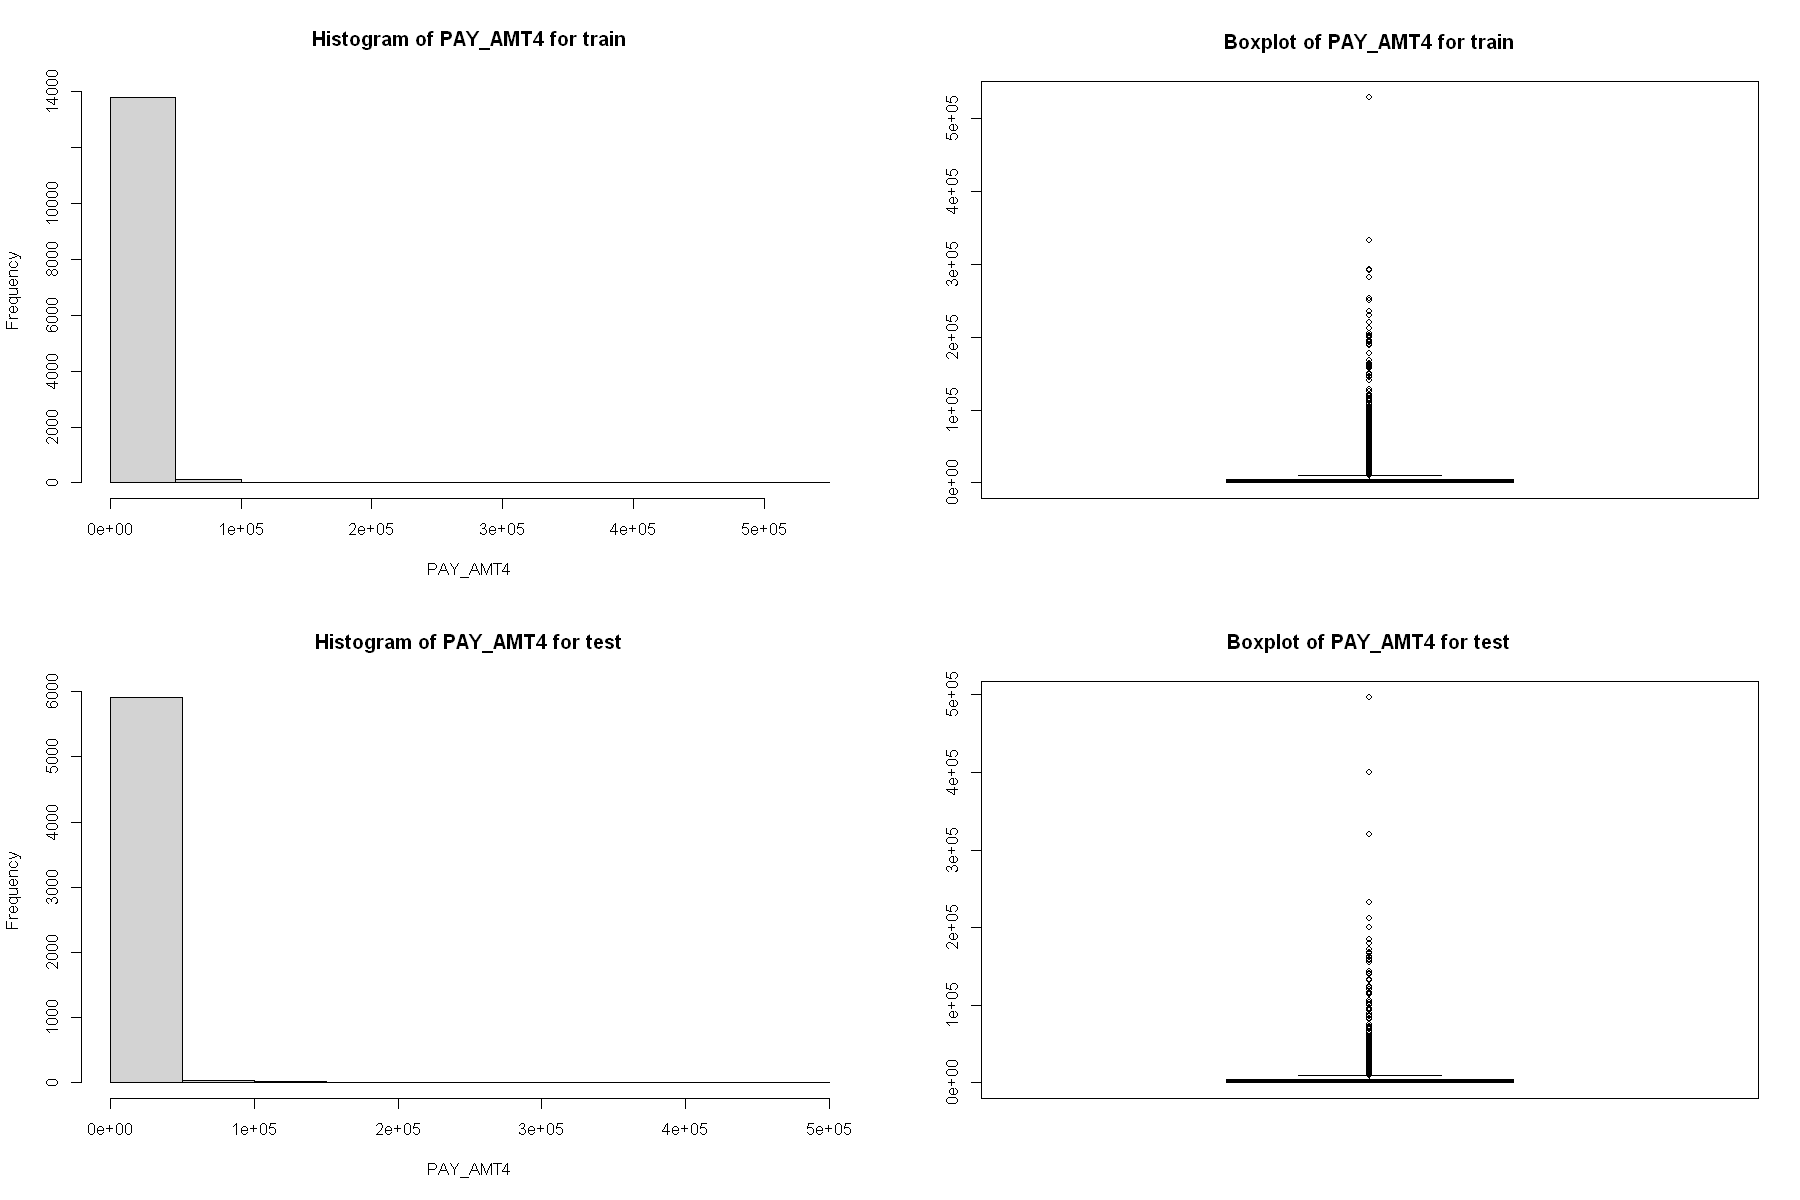

In [195]:
par(mfrow=c(2,2))

hist(train$PAY_AMT4,xlab = "PAY_AMT4",main = "Histogram of PAY_AMT4 for train")
boxplot(train$PAY_AMT4, horizontal=FALSE,main = "Boxplot of PAY_AMT4 for train")

hist(test$PAY_AMT4,xlab = "PAY_AMT4",main = "Histogram of PAY_AMT4 for test")
boxplot(test$PAY_AMT4, horizontal=FALSE,main = "Boxplot of PAY_AMT4 for test")

print(max(train$PAY_AMT4))
print(max(test$PAY_AMT4))

print(min(train$PAY_AMT4))
print(min(test$PAY_AMT4))

In [196]:
# The 1st Quartile (25%)
first_quart_PAY_AMT4 <- summary(train$PAY_AMT4)[2]

# The 3rd Quartile (75%)
third_quart_PAY_AMT4 <- summary(train$PAY_AMT4)[5]

# Setting a benchmark 
neg_benchark_PAY_AMT4 <- first_quart_PAY_AMT4 - 1.5*IQR(train$PAY_AMT4) # Q1 - 1.5 * IQR
pos_benchark_PAY_AMT4 <- third_quart_PAY_AMT4 + 1.5*IQR(train$PAY_AMT4) # Q3 + 1.5 * IQR

# Winsorizing the train set
train$PAY_AMT4[train$PAY_AMT4 > pos_benchark_PAY_AMT4] <- pos_benchark_PAY_AMT4
train$PAY_AMT4[train$PAY_AMT4 < neg_benchark_PAY_AMT4] <- neg_benchark_PAY_AMT4

# Winsorizing the test set
test$PAY_AMT4[test$PAY_AMT4 > pos_benchark_PAY_AMT4] <- pos_benchark_PAY_AMT4
test$PAY_AMT4[test$PAY_AMT4 < neg_benchark_PAY_AMT4] <- neg_benchark_PAY_AMT4

In [197]:
summary(train$PAY_AMT4)
summary(test$PAY_AMT4)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0   306.8  1514.5  2777.2  4200.0 10039.9 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0   267.8  1500.0  2763.7  4100.0 10039.9 

##### PAY_AMT5

In [198]:
summary(train$PAY_AMT5)
summary(test$PAY_AMT5)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0     300    1544    4748    4168  388071 

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
     0.0    227.5   1536.0   5013.6   4274.8 326889.0 

[1] 388071
[1] 326889
[1] 0
[1] 0


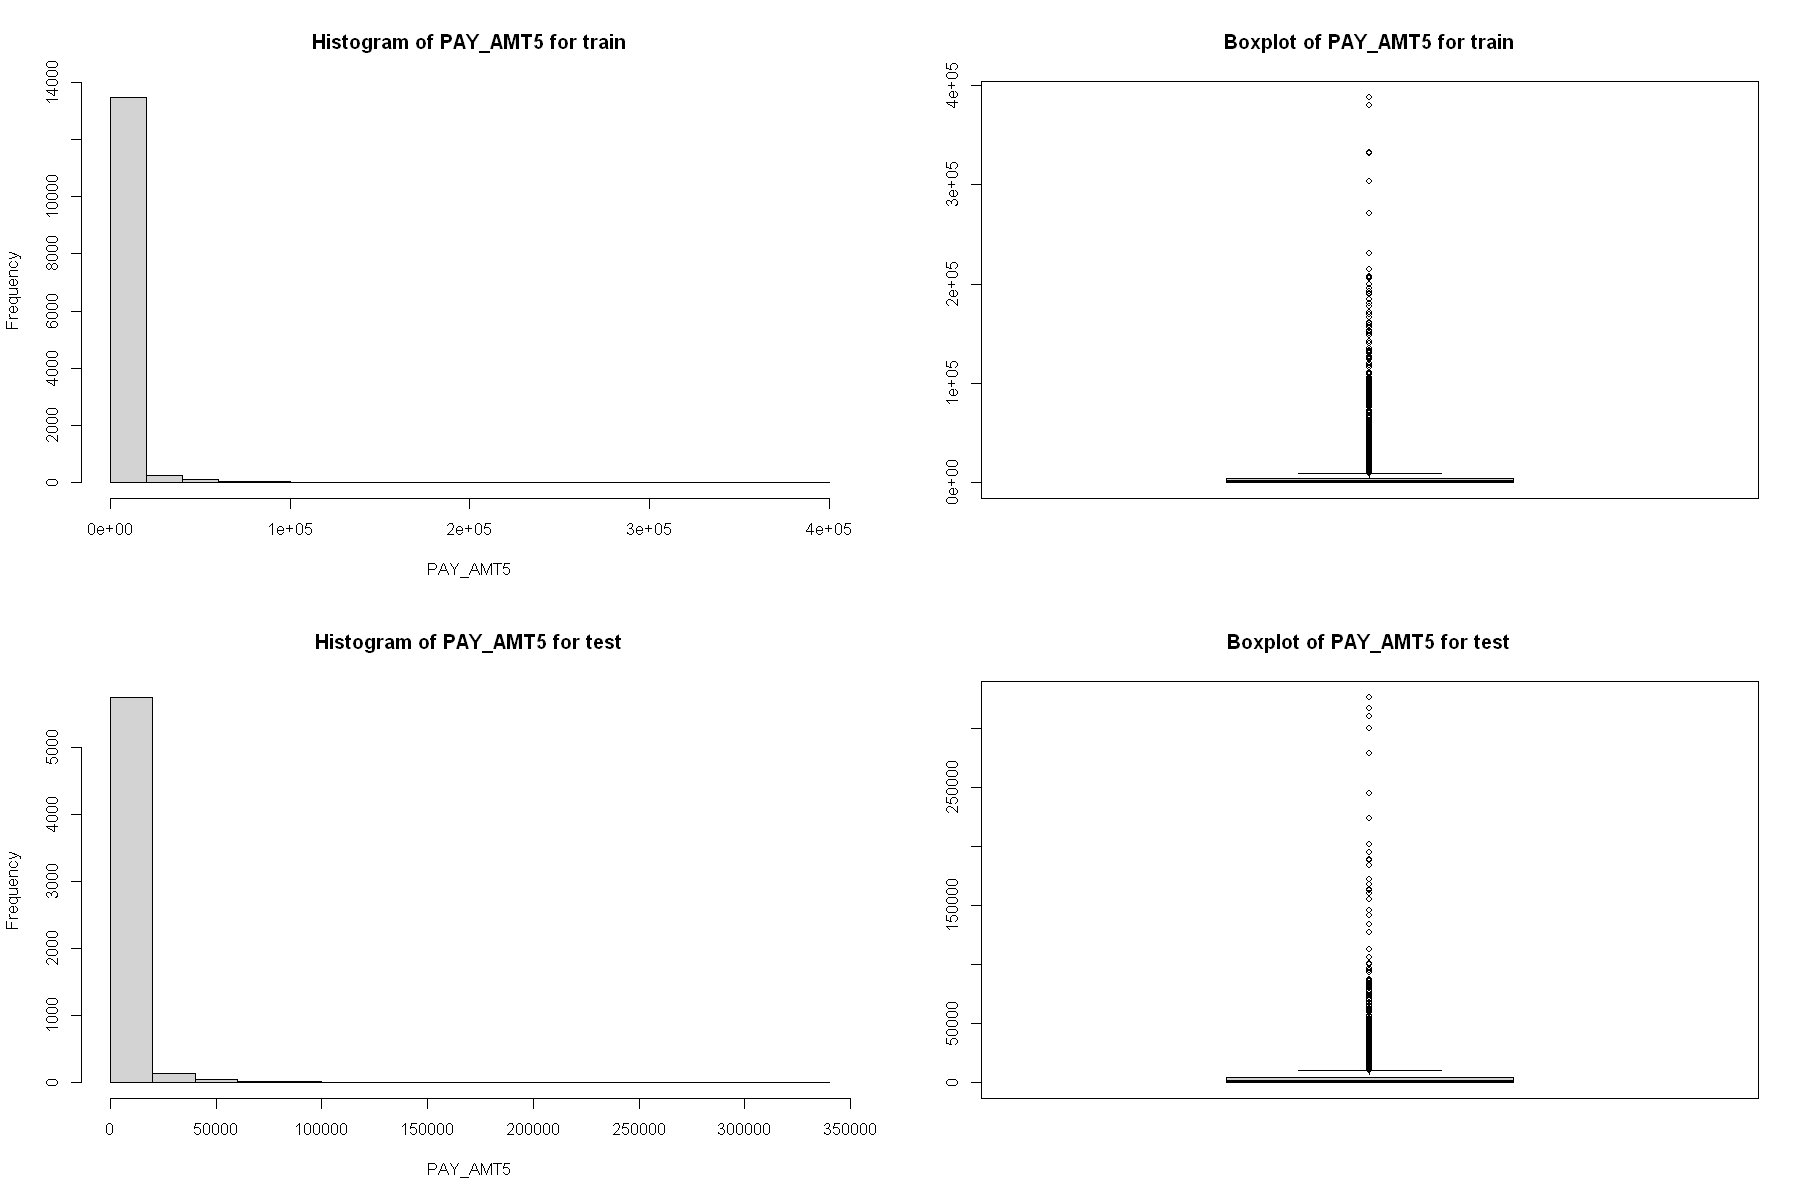

In [199]:
par(mfrow=c(2,2))

hist(train$PAY_AMT5,xlab = "PAY_AMT5",main = "Histogram of PAY_AMT5 for train")
boxplot(train$PAY_AMT5, horizontal=FALSE,main = "Boxplot of PAY_AMT5 for train")

hist(test$PAY_AMT5,xlab = "PAY_AMT5",main = "Histogram of PAY_AMT5 for test")
boxplot(test$PAY_AMT5, horizontal=FALSE,main = "Boxplot of PAY_AMT5 for test")

print(max(train$PAY_AMT5))
print(max(test$PAY_AMT5))

print(min(train$PAY_AMT5))
print(min(test$PAY_AMT5))

In [200]:
# The 1st Quartile (25%)
first_quart_PAY_AMT5 <- summary(train$PAY_AMT5)[2]

# The 3rd Quartile (75%)
third_quart_PAY_AMT5 <- summary(train$PAY_AMT5)[5]

# Setting a benchmark 
neg_benchark_PAY_AMT5 <- first_quart_PAY_AMT5 - 1.5*IQR(train$PAY_AMT5) # Q1 - 1.5 * IQR
pos_benchark_PAY_AMT5 <- third_quart_PAY_AMT5 + 1.5*IQR(train$PAY_AMT5) # Q3 + 1.5 * IQR

# Winsorizing the train set
train$PAY_AMT5[train$PAY_AMT5 > pos_benchark_PAY_AMT5] <- pos_benchark_PAY_AMT5
train$PAY_AMT5[train$PAY_AMT5 < neg_benchark_PAY_AMT5] <- neg_benchark_PAY_AMT5

# Winsorizing the test set
test$PAY_AMT5[test$PAY_AMT5 > pos_benchark_PAY_AMT5] <- pos_benchark_PAY_AMT5
test$PAY_AMT5[test$PAY_AMT5 < neg_benchark_PAY_AMT5] <- neg_benchark_PAY_AMT5

In [201]:
summary(train$PAY_AMT5)
summary(test$PAY_AMT5)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0     300    1544    2763    4168    9971 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0   227.5  1536.0  2811.5  4274.8  9970.6 

##### PAY_AMT6

In [202]:
summary(train$PAY_AMT6)
summary(test$PAY_AMT6)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0     165    1500    5313    4200  528666 

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
     0.0     36.5   1500.0   5059.5   4028.8 422000.0 

[1] 528666
[1] 422000
[1] 0
[1] 0


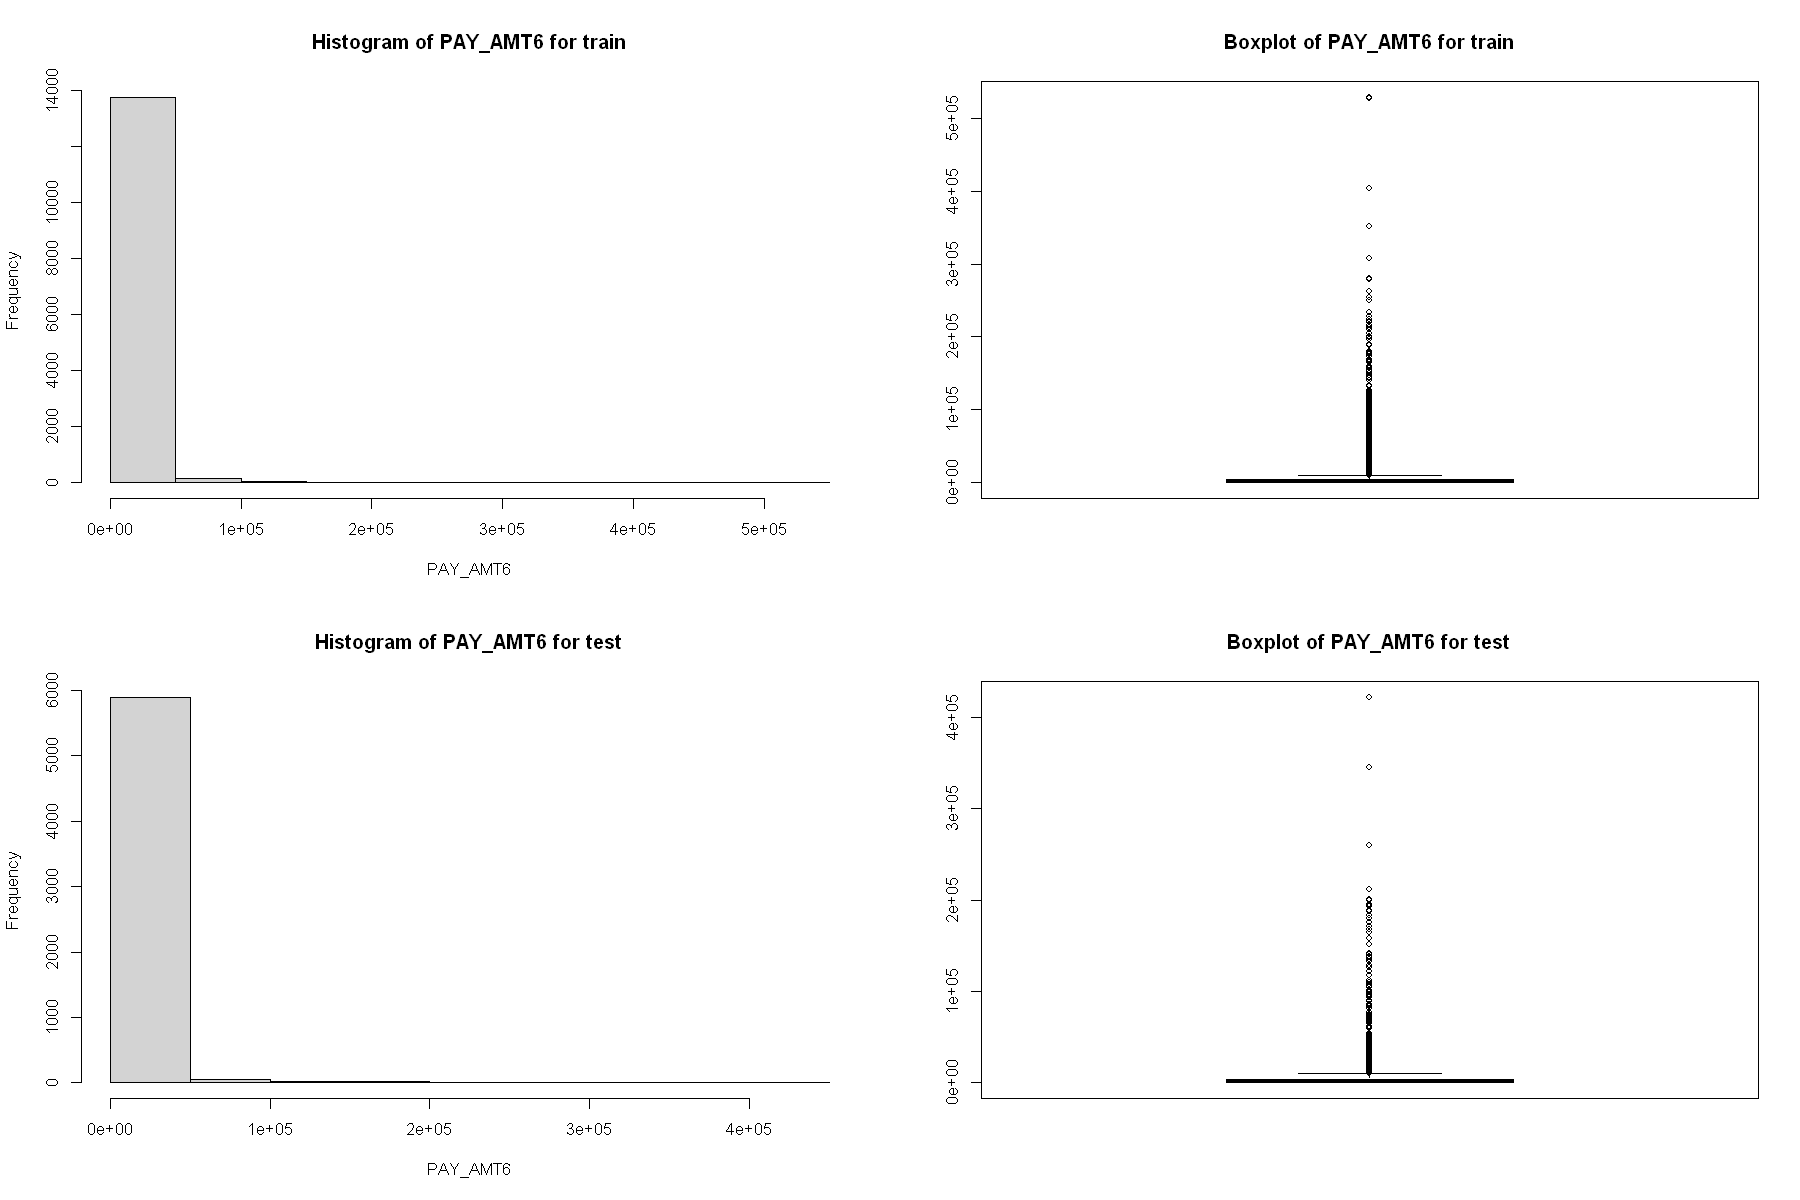

In [203]:
par(mfrow=c(2,2))

hist(train$PAY_AMT6,xlab = "PAY_AMT6",main = "Histogram of PAY_AMT6 for train")
boxplot(train$PAY_AMT6, horizontal=FALSE,main = "Boxplot of PAY_AMT6 for train")

hist(test$PAY_AMT6,xlab = "PAY_AMT6",main = "Histogram of PAY_AMT6 for test")
boxplot(test$PAY_AMT6, horizontal=FALSE,main = "Boxplot of PAY_AMT6 for test")

print(max(train$PAY_AMT6))
print(max(test$PAY_AMT6))

print(min(train$PAY_AMT6))
print(min(test$PAY_AMT6))

In [204]:
# The 1st Quartile (25%)
first_quart_PAY_AMT6 <- summary(train$PAY_AMT6)[2]

# The 3rd Quartile (75%)
third_quart_PAY_AMT6 <- summary(train$PAY_AMT6)[5]

# Setting a benchmark 
neg_benchark_PAY_AMT6 <- first_quart_PAY_AMT6 - 1.5*IQR(train$PAY_AMT6) # Q1 - 1.5 * IQR
pos_benchark_PAY_AMT6 <- third_quart_PAY_AMT6 + 1.5*IQR(train$PAY_AMT6) # Q3 + 1.5 * IQR

# Winsorizing the train set
train$PAY_AMT6[train$PAY_AMT6 > pos_benchark_PAY_AMT6] <- pos_benchark_PAY_AMT6
train$PAY_AMT6[train$PAY_AMT6 < neg_benchark_PAY_AMT6] <- neg_benchark_PAY_AMT6

# Winsorizing the test set
test$PAY_AMT6[test$PAY_AMT6 > pos_benchark_PAY_AMT6] <- pos_benchark_PAY_AMT6
test$PAY_AMT6[test$PAY_AMT6 < neg_benchark_PAY_AMT6] <- neg_benchark_PAY_AMT6

In [205]:
summary(train$PAY_AMT6)
summary(test$PAY_AMT6)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0     165    1500    2770    4200   10252 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0    36.5  1500.0  2750.4  4028.8 10252.5 

In [206]:
# Fit LR model on train with the best variable transformation
logreg_train <- glm(default.payment.next.month ~., data=train, family='binomial')
summary(logreg_train)


Call:
glm(formula = default.payment.next.month ~ ., family = "binomial", 
    data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.2033  -0.7089  -0.5355  -0.2791   2.8452  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -3.475e-01  1.694e-01  -2.052 0.040186 *  
cust_id     -2.299e-06  2.529e-06  -0.909 0.363412    
LIMIT_BAL   -1.570e-07  2.285e-07  -0.687 0.491860    
SEX         -1.120e-01  4.506e-02  -2.485 0.012969 *  
EDUCATION   -1.266e-01  3.099e-02  -4.085 4.41e-05 ***
MARRIAGE    -1.159e-01  4.642e-02  -2.497 0.012515 *  
PAY_0        5.427e-01  2.621e-02  20.708  < 2e-16 ***
PAY_2        7.091e-02  3.040e-02   2.332 0.019685 *  
PAY_3        7.612e-02  3.532e-02   2.155 0.031128 *  
PAY_4        3.073e-02  3.828e-02   0.803 0.422146    
PAY_5        4.788e-02  4.018e-02   1.192 0.233386    
PAY_6        4.045e-02  3.328e-02   1.215 0.224197    
BILL_AMT1   -5.708e-06  1.472e-06  -3.879 0.000105 ***
BILL_AMT

In [207]:
# Make prediction on test
logreg_test <- predict(logreg_train, newdata=test, type='response')
pred_class <- ifelse(logreg_test > 0.5, 'Up', 'Down')

In [208]:
# Confusion matrix
conf_mat <- table(pred_class, test$default.payment.next.month)
TP = conf_mat[2, 2]
FP = conf_mat[2, 1]
TN = conf_mat[1, 1]
FN = conf_mat[1, 2]

# Overall accuracy
acc <- (TP + TN) / (TP + FP + TN + FN)
print(paste('Accuracy =', acc))

[1] "Accuracy = 0.811"


In [209]:
# Remove the column cust_id
train <- subset(train, select = -cust_id)
test <- subset(test, select = -cust_id)

In [210]:
nvar <- ncol(train)-1
nvar

[1] 23

# Feature Selection

### 1. Subset Selection

#### 1.a Forward Stepwise Selection

In [211]:
# new_credit_default <- rbind(train, test)
# new_credit_default <- subset(new_credit_default, select = -cust_id)

In [212]:
# Forward selection, with regsubsets from the leaps package
FWD = regsubsets(default.payment.next.month∼., data = train, nvmax = nvar, method = "forward")
FWD.summary = summary(FWD)

[1] "Adjr R2:  20 variables"

[1] "BIC:  10 variables"

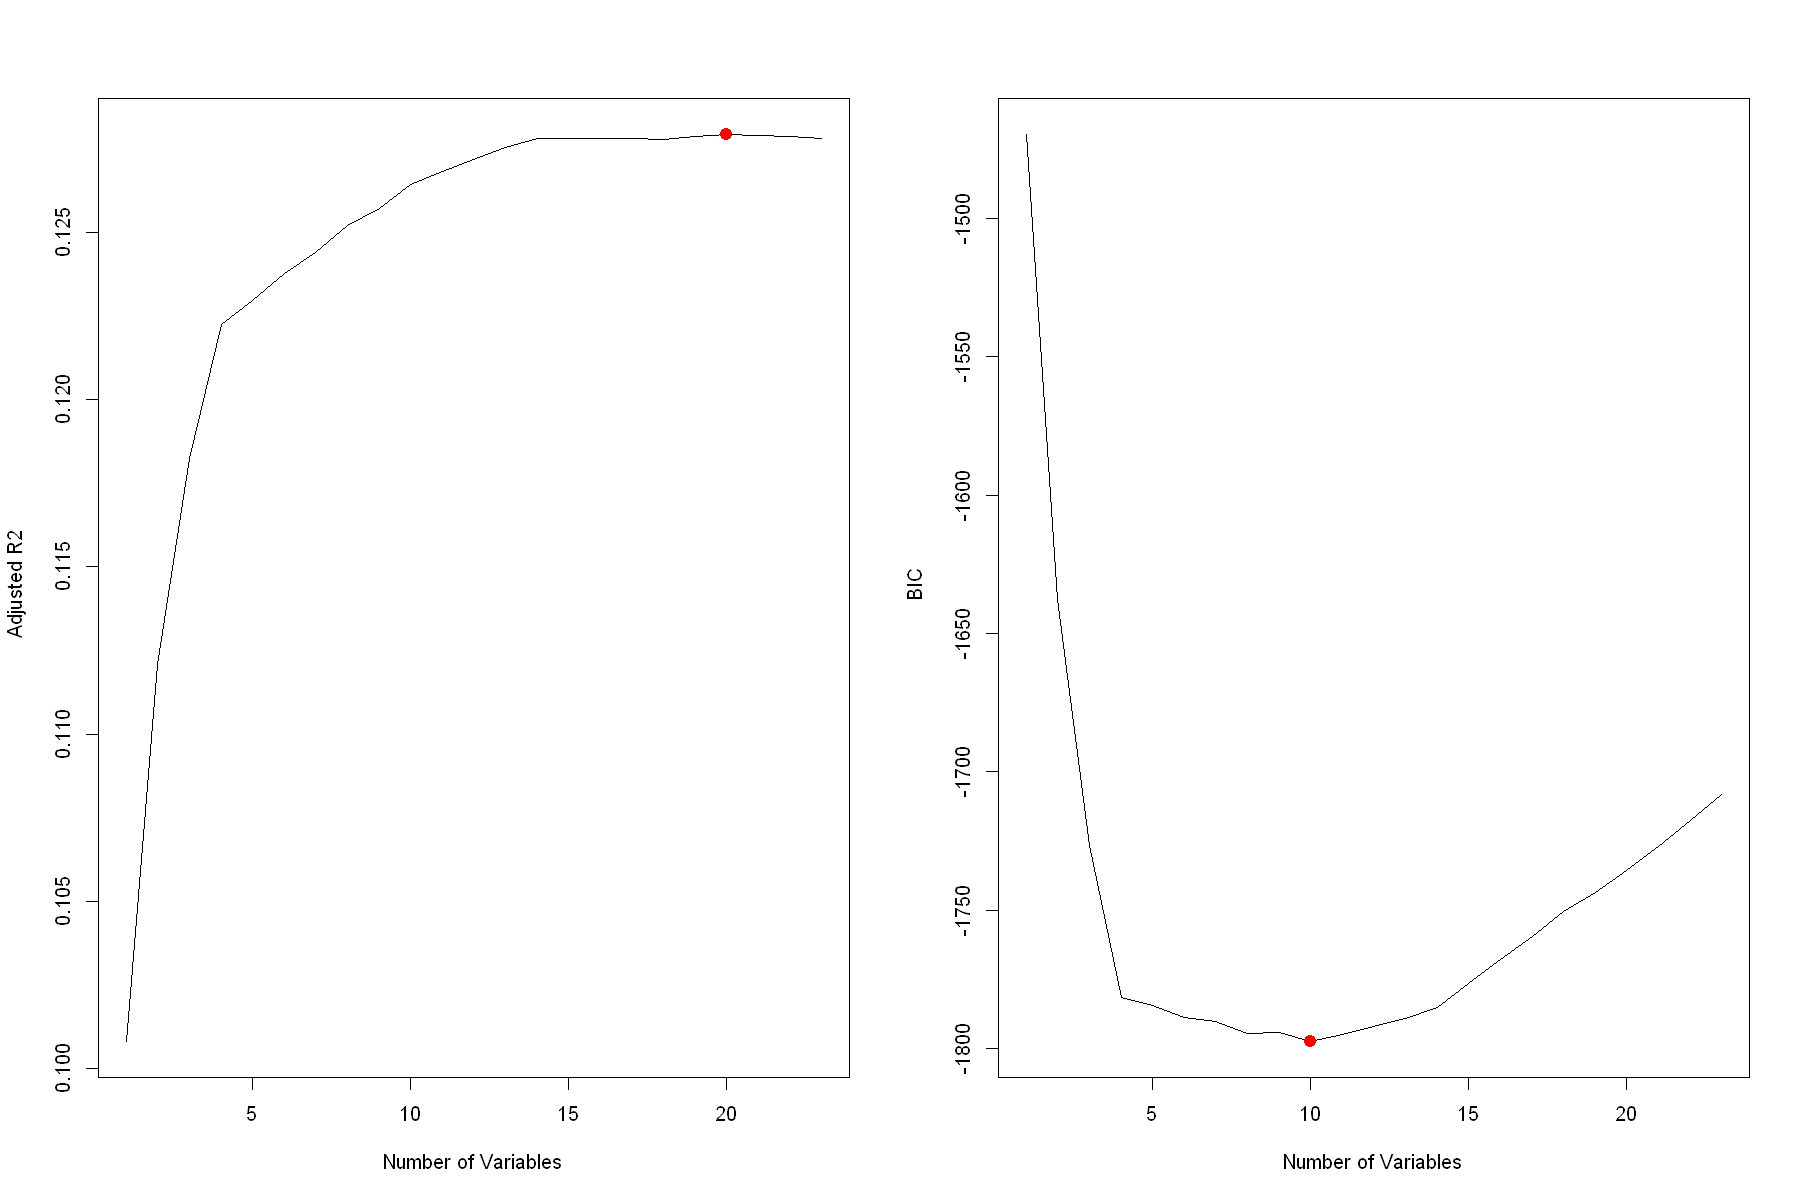

In [213]:
# Displaying the plots
par(mfrow = c(1,2))

# Adjusted R2
plot(FWD.summary$adjr2 ,xlab =" Number of Variables ", ylab=" Adjusted R2",type="l")
adjr2.max_FWD_adjr2 <- which.max(FWD.summary$adjr2)
points(adjr2.max_FWD_adjr2, FWD.summary$adjr2[adjr2.max_FWD_adjr2], col="red",cex=2, pch=20)
paste("Adjr R2: ", adjr2.max_FWD_adjr2, "variables")

# BIC
plot(FWD.summary$bic ,xlab =" Number of Variables ", ylab=" BIC",type="l")
bic.min_FWD_BIC <- which.min(FWD.summary$bic)
points(bic.min_FWD_BIC, FWD.summary$bic[bic.min_FWD_BIC], col="red",cex=2, pch=20)
paste("BIC: ", bic.min_FWD_BIC, "variables")

In [214]:
# FWD_adjr2_vars <- data.frame(coef(FWD, adjr2.max))
# names(FWD_adjr2_vars)[names(FWD_adjr2_vars) == "coef.FWD..adjr2.max."] <- "Forward Adjr2 Variables"
# FWD_adjr2_vars

In [215]:
# FWD_BIC_vars <- data.frame(coef(FWD, bic.min_FWD_BIC))
# names(FWD_BIC_vars)[names(FWD_BIC_vars) == "coef.FWD..bic.min."] <- "Forward BIC Variables"
# FWD_BIC_vars

Cross Validation for the Forward Selection

[1] "Best k = 21 , Average MSE = 0.150830559919057"


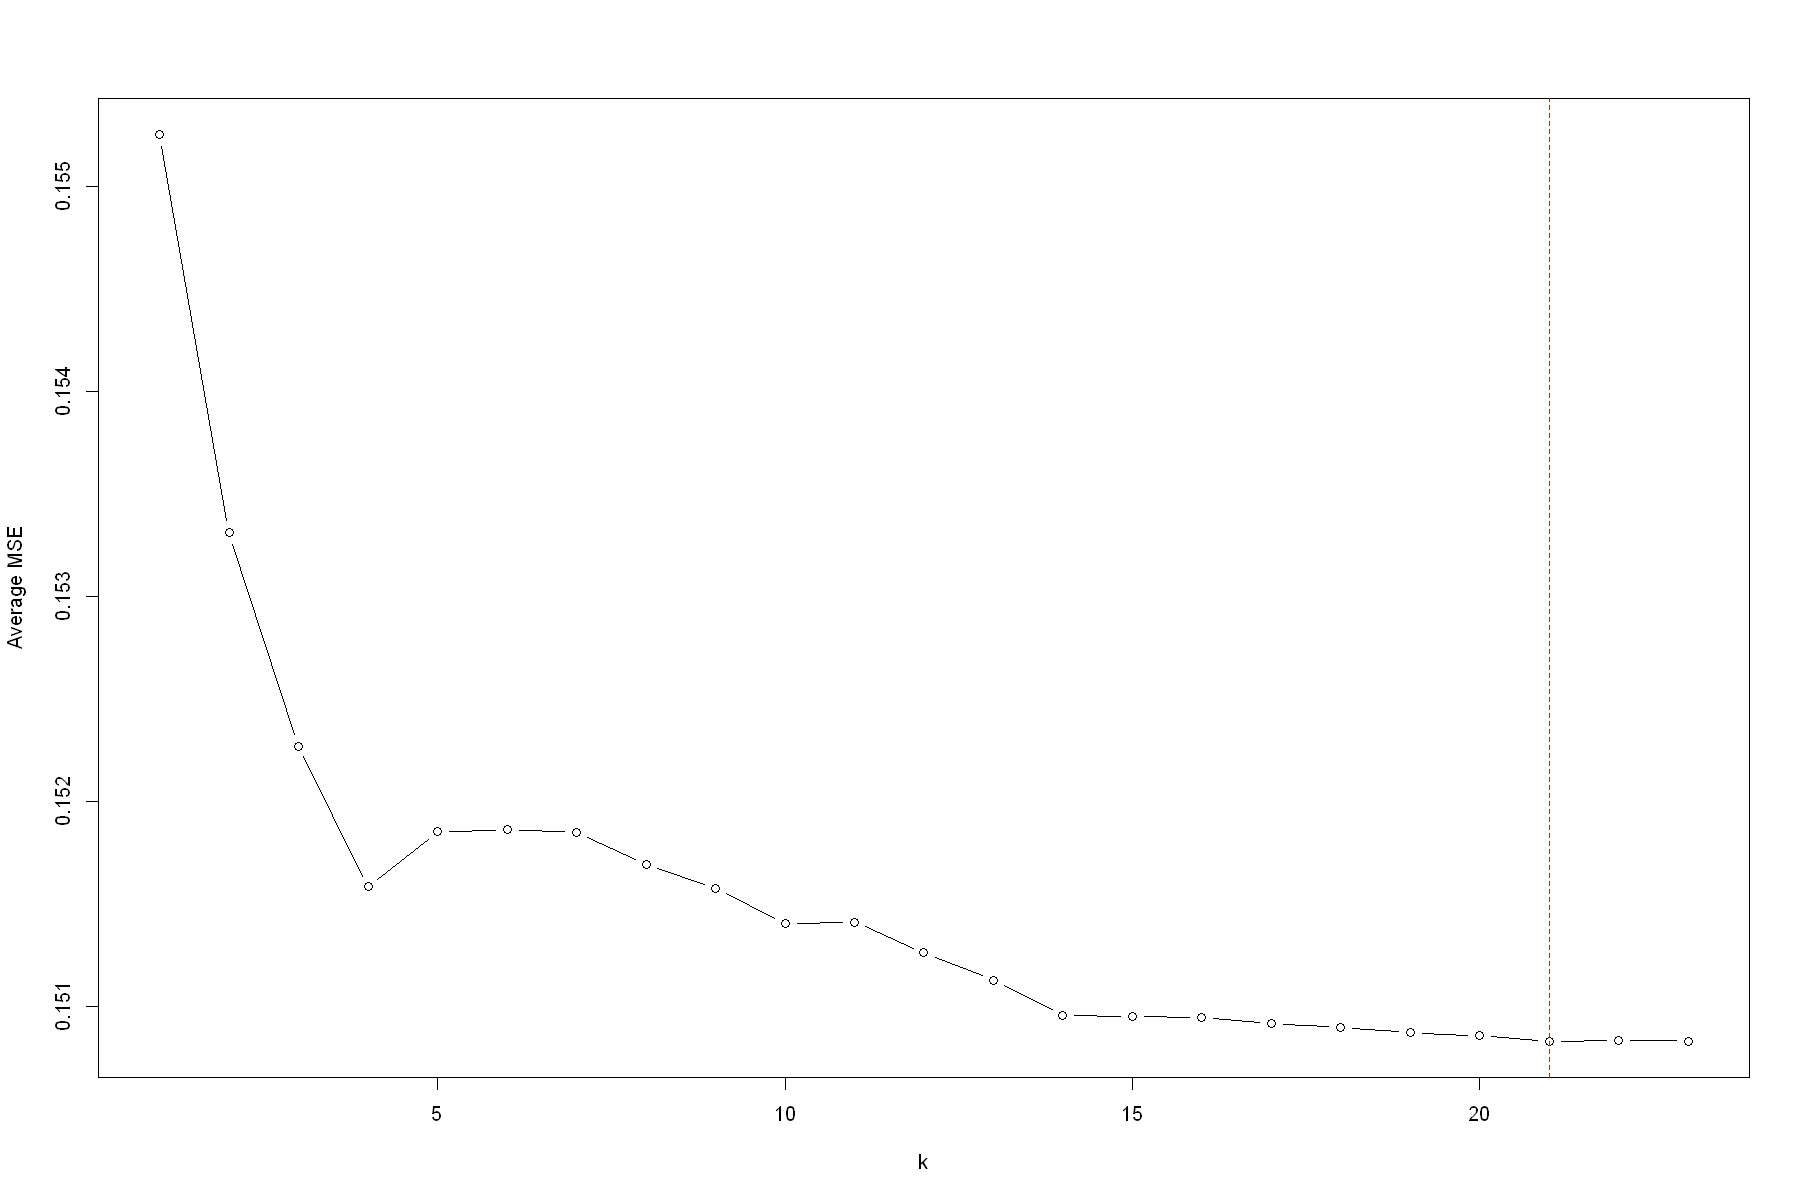

In [216]:
# Function to predict with object regsubsets (p.249)
predict.regsubsets <- function (object, newdata, id, ...) {
    form <- as.formula(object$call[[2]])
    mat <- model.matrix(form, newdata)
    coefi <- coef(object, id=id)
    xvars <- names(coefi)
    mat[, xvars] %*% coefi
}

k=10
set.seed(1)
folds <- sample(1:k, nrow(train), replace = TRUE)
cv.errors <- matrix(NA, k, nvar, dimnames = list(NULL, paste(1:nvar)))

for(j in 1:k){
    FWD_CV = regsubsets(default.payment.next.month~.,train[folds != j,],nvmax = nvar, method='forward')
    for (i in 1:nvar){
        pred = predict(FWD_CV, train[folds==j,], id=i)
        cv.errors[j,i] = mean((train$default.payment.next.month[folds==j] - pred)^2)
    }
}

# Visualize the mean error and select the best k
avg_cv.errors <- apply(cv.errors, 2, mean)
plot(avg_cv.errors, type='b', xlab='k', ylab='Average MSE')
abline(v=which.min(avg_cv.errors), col='red', lty=2)
print(paste('Best k =', which.min(avg_cv.errors), ', Average MSE =', min(avg_cv.errors)))

In [217]:
# Forward stepwise on train with the best k
lr_forward <- regsubsets(default.payment.next.month ~ ., data=train, nvmax=nvar, method='forward')
# data.frame(coef(FWD, 24))

#### 1.b Backward Stepwise Selection

In [218]:
# Backward selection, also with regsubsets from the leaps package
BWD = regsubsets(default.payment.next.month∼., data = train, nvmax = nvar, method = "backward")
BWD.summary = summary(BWD)

[1] "Adjr R2:  17 variables"

[1] "BIC:  9 variables"

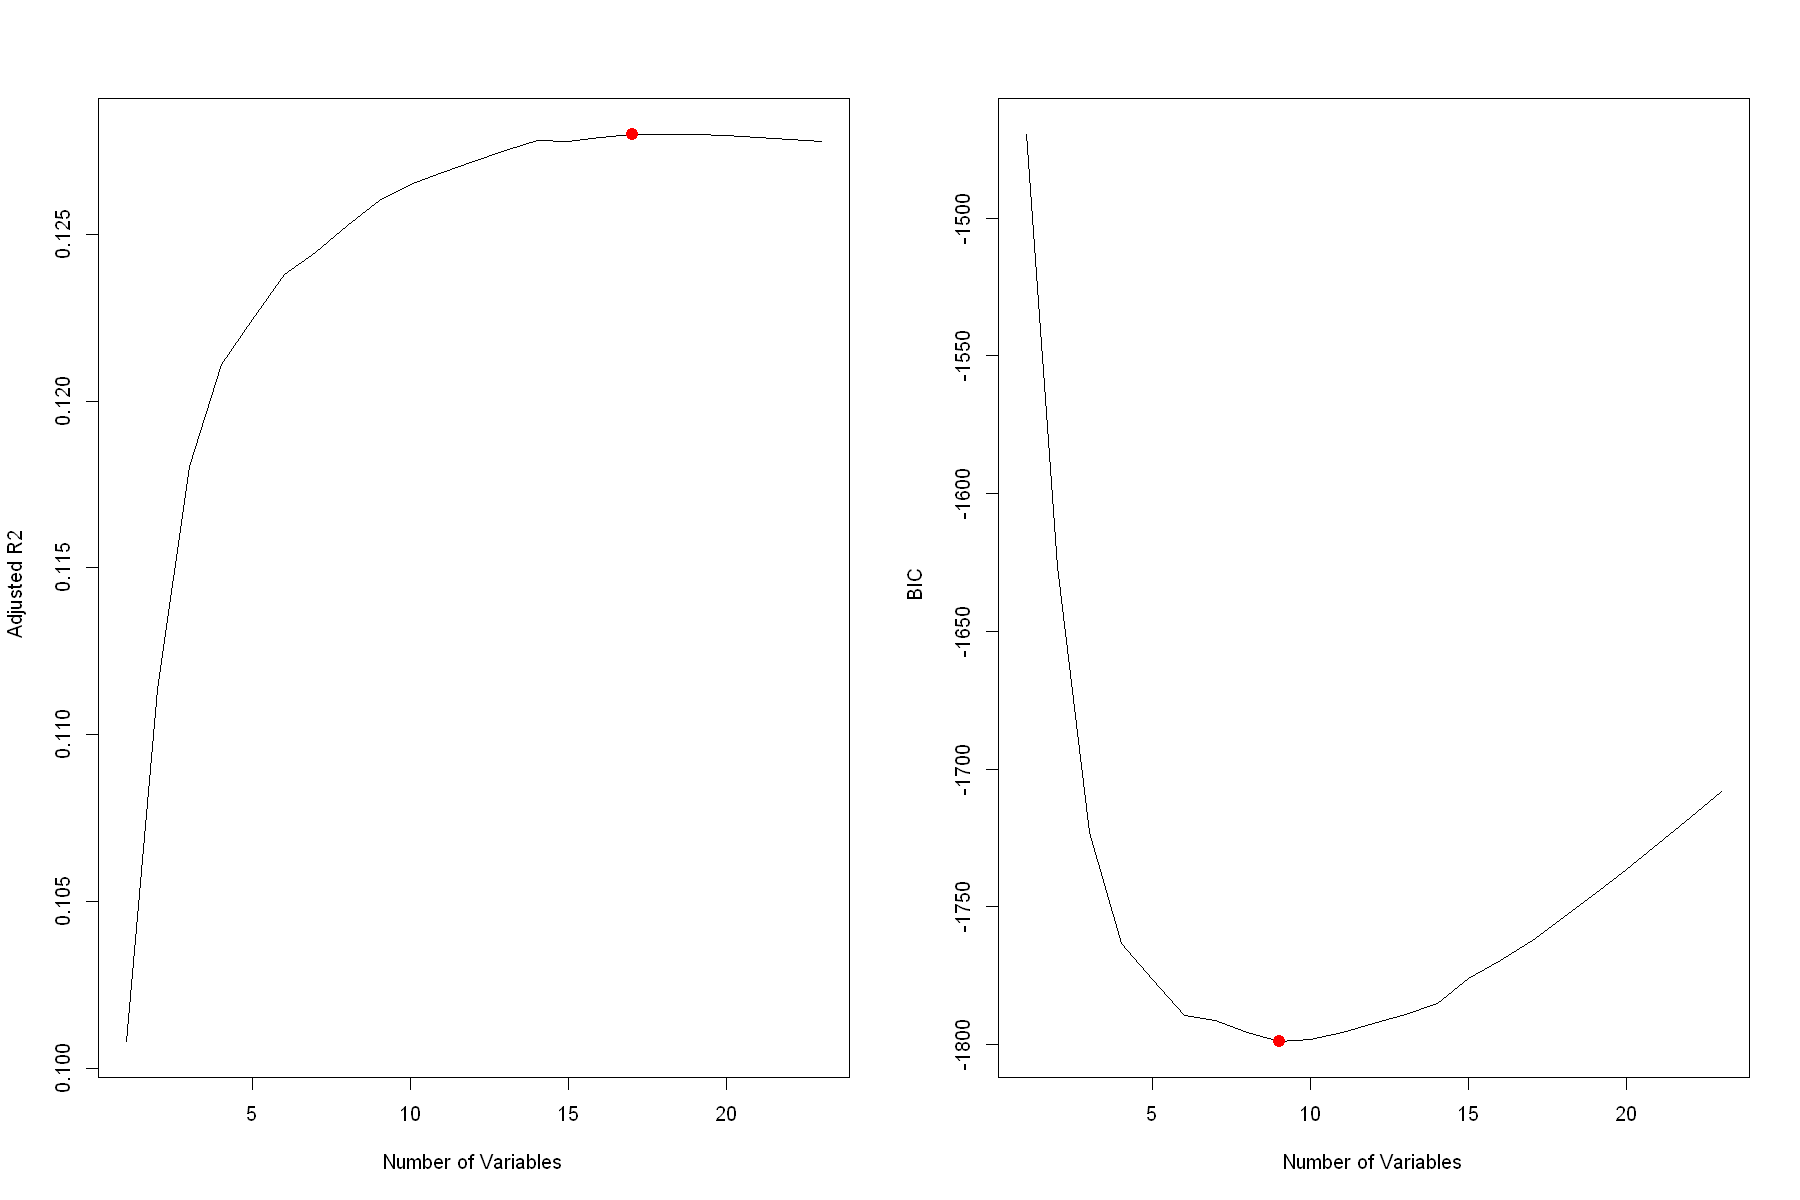

In [219]:
# Displaying the plots
par(mfrow = c(1,2))

# Adjusted R2
plot(BWD.summary$adjr2 ,xlab =" Number of Variables ", ylab=" Adjusted R2",type="l")
adjr2.max_BWD_adjr2 <- which.max(BWD.summary$adjr2)
points(adjr2.max_BWD_adjr2, BWD.summary$adjr2[adjr2.max_BWD_adjr2], col="red",cex=2, pch=20)
paste("Adjr R2: ", adjr2.max_BWD_adjr2, "variables")

# BIC
plot(BWD.summary$bic ,xlab =" Number of Variables ", ylab=" BIC",type="l")
bic.min_BWD_BIC <- which.min(BWD.summary$bic)
points(bic.min_BWD_BIC, BWD.summary$bic[bic.min_BWD_BIC], col="red",cex=2, pch=20)
paste("BIC: ", bic.min_BWD_BIC, "variables")

In [220]:
# BWD_adjr2_vars <- data.frame(coef(BWD, adjr2.max))
# names(FWD_adjr2_vars)[names(BWD_adjr2_vars) == "coef.BWD..adjr2.max."] <- "Backward Adjr2 Variables"
# BWD_adjr2_vars

In [221]:
# BWD_BIC_vars <- data.frame(coef(BWD, bic.min))
# names(BWD_BIC_vars)[names(BWD_BIC_vars) == "coef.BWD..bic.min."] <- "Forward BIC Variables"
# BWD_BIC_vars

#### 1.c Best Subset Selection

... On the train set

In [222]:
regfit.best <- regsubsets(default.payment.next.month~., train, nvmax = nvar)

In [223]:
test.mat <- model.matrix(default.payment.next.month~., test)

In [224]:
val.errors <- rep(NA, nvar)

for (i in 1:nvar) {coefi = coef(regfit.best, id=i)
                 pred <- test.mat[,names(coefi)]%*%coefi
                 val.errors[i] = mean((test$default.payment.next.month - pred)^2)}

which.min(val.errors)

[1] 13

In [225]:
# BSS_train_vars <- data.frame(coef(regfit.best,which.min(val.errors)))
# names(BSS_train_vars)[names(BSS_train_vars) == "coef.regfit.best..which.min.val.errors.."] <- "BSS Train Variables"
# BSS_train_vars

### Evaluating the feature selection models

In [226]:
# Evaluate the Forward Selection model Adjusted R2
pred_FWD_AJR2 <- predict(FWD, newdata=test, adjr2.max_FWD_adjr2)
mean((pred_FWD_AJR2 - test$default.payment.next.month)^2)


[1] 0.1505473

In [227]:
# Evaluate the Forward Selection model BIC
pred_FWD_BIC <- predict(FWD, newdata=test, bic.min_FWD_BIC)
mean((pred_FWD_BIC - test$default.payment.next.month)^2)

[1] 0.15058

In [228]:
# Evaluate the Forward Selection model after Cross Validation
pred_lr_forward <- predict(lr_forward, newdata=test,  which.min(avg_cv.errors))
mean((pred_lr_forward - test$default.payment.next.month)^2)

[1] 0.1505651

In [229]:
# Evaluate the Backward Selection model Adjusted R2
pred_BWD_AJR2 <- predict(BWD, newdata=test, adjr2.max_BWD_adjr2)
mean((pred_BWD_AJR2 - test$default.payment.next.month)^2)

[1] 0.1505461

In [230]:
# Evaluate the Backward Selection model BIC
pred_BWD_BIC <- predict(BWD, newdata=test, bic.min_BWD_BIC)
mean((pred_BWD_BIC - test$default.payment.next.month)^2)

[1] 0.1508329

In [231]:
# Evaluate the Best Subset Selection model
pred_BSS <- predict(regfit.best, newdata=test, which.min(val.errors))
mean((pred_BSS - test$default.payment.next.month)^2)

[1] 0.1504855

In [232]:
Model <- c("Forward Selection adjr2", "Forward Selection BIC", "Forward Selection CV", 
                  "Backward Selection adjr2", "Backward Selection BIC", "Best Subset Selection")
Evaluation <- c(mean((pred_FWD_AJR2 - test$default.payment.next.month)^2), 
                  mean((pred_FWD_BIC - test$default.payment.next.month)^2),
                  mean((pred_lr_forward - test$default.payment.next.month)^2),
                  mean((pred_BWD_AJR2 - test$default.payment.next.month)^2),
                  mean((pred_BWD_BIC - test$default.payment.next.month)^2),
                  mean((pred_BSS - test$default.payment.next.month)^2))

df <- data.frame(Model, Evaluation)
df

Model,Evaluation
<chr>,<dbl>
Forward Selection adjr2,0.1505473
Forward Selection BIC,0.1505800
Forward Selection CV,0.1505651
Backward Selection adjr2,0.1505461
Backward Selection BIC,0.1508329
Best Subset Selection,0.1504855


In [233]:
## The Forward selection with the BIC has the best performance. 

In [234]:
BSS_vars <- data.frame(coef(regfit.best,which.min(val.errors)))
names(BSS_vars)[names(BSS_vars) == "coef.regfit.best..which.min.val.errors.."] <- "BSS Train Variables"
BSS_vars

,BSS Train Variables
,<dbl>
(Intercept),3.376896e-01
EDUCATION,-1.816416e-02
MARRIAGE,-1.760113e-02
PAY_0,9.135788e-02
PAY_2,1.971939e-02
PAY_3,1.334314e-02
PAY_5,1.533207e-02
BILL_AMT1,-8.817982e-07
BILL_AMT3,4.690423e-07


# Models

In [235]:
# Variables for the LR Best Subset Selection model
coef(regfit.best,which.min(val.errors))

(Intercept)     EDUCATION      MARRIAGE         PAY_0         PAY_2 
 3.376896e-01 -1.816416e-02 -1.760113e-02  9.135788e-02  1.971939e-02 
        PAY_3         PAY_5     BILL_AMT1     BILL_AMT3      PAY_AMT1 
 1.334314e-02  1.533207e-02 -8.817982e-07  4.690423e-07 -5.861775e-06 
     PAY_AMT2      PAY_AMT3      PAY_AMT6     age_group 
-4.862437e-06 -3.261560e-06 -3.152566e-06  1.034231e-03

### 1. Logistic Regression

##### Selected features

In [236]:
# Fit LR model on train
LogReg_SV <- glm(default.payment.next.month ~ EDUCATION + MARRIAGE + PAY_0 + PAY_2 + PAY_3 + PAY_5 + BILL_AMT1 + BILL_AMT3 + PAY_AMT1 + PAY_AMT2 + PAY_AMT3 + PAY_AMT6 + age_group, data=train, family='binomial')

# Make prediction on test
pred_prob1 <- predict(LogReg_SV, newdata=test, type='response')
pred_class1 <- ifelse(pred_prob1 > 0.5, 'Up', 'Down')

# Confusion matrix
conf_mat1 <- table(pred_class1, test$default.payment.next.month)
conf_mat1

TP1 = conf_mat1[2, 2]  # 56
FP1 = conf_mat1[2, 1]  # 34
TN1 = conf_mat1[1, 1]  # 9
FN1 = conf_mat1[1, 2]  # 5

# Overall accuracy
acc1 <- (TP1 + TN1) / (TP1 + FP1 + TN1 + FN1)
print(paste('Accuracy =', acc1))

# Error Type I
err_type1 <- FP1 / (TN1 + FP1)
print(paste('Error Type I =', err_type1))

# Error Type II
err_type2 <- FN1 / (TP1 + FN1)
print(paste('Error Type II =', err_type2))

           
pred_class1    0    1
       Down 4550  987
       Up    143  320

[1] "Accuracy = 0.811666666666667"
[1] "Error Type I = 0.0304709141274238"
[1] "Error Type II = 0.755164498852334"


##### All features

In [237]:
# Fit LR model on train
LogReg_AV <- glm(default.payment.next.month ~ ., data=train, family='binomial')

# Make prediction on test
pred_prob1a <- predict(LogReg_AV, newdata=test, type='response')
pred_class1a <- ifelse(pred_prob1a > 0.5, 'Up', 'Down')

# Confusion matrix
conf_mat1a <- table(pred_class1a, test$default.payment.next.month)
conf_mat1a

TP1a = conf_mat1a[2, 2]  # 56
FP1a = conf_mat1a[2, 1]  # 34
TN1a = conf_mat1a[1, 1]  # 9
FN1a = conf_mat1a[1, 2]  # 5

# Overall accuracy
acc1a <- (TP1a + TN1a) / (TP1a + FP1a + TN1a + FN1a)
print(paste('Accuracy =', acc))

# Error Type I
err_type1 <- FP1a / (TN1a + FP1a)
print(paste('Error Type I =', err_type1))

# Error Type II
err_type2 <- FN1a / (TP1a + FN1a)
print(paste('Error Type II =', err_type2))

            
pred_class1a    0    1
        Down 4546  993
        Up    147  314

[1] "Accuracy = 0.811"
[1] "Error Type I = 0.0313232473897294"
[1] "Error Type II = 0.759755164498852"


In [238]:
new_credit_default <- rbind(train, test)
# new_credit_default <- subset(new_credit_default, select = -cust_id)

In [239]:
folds  <- cut(seq(1,nrow(new_credit_default)),breaks=10,labels=FALSE)
result <- list()

for(i in 1:10){
  testIndexes <- which(folds==i,arr.ind=TRUE)
  testData    <- new_credit_default[testIndexes, ]
  trainData   <- new_credit_default[-testIndexes, ]
  model       <- glm(default.payment.next.month~EDUCATION + MARRIAGE + PAY_0 + PAY_2 + PAY_3 + PAY_5 + BILL_AMT1 + BILL_AMT3 + PAY_AMT1 + PAY_AMT2 + PAY_AMT3 + PAY_AMT6 + age_group,family=binomial,data=trainData)
  result[[i]] <- predict(model, testData) 
}
result


[[1]]
           2            3            4            5            6            7 
-0.314457942 -1.122228009 -1.303142537  0.334638987 -1.165032011 -1.369241317 
           8            9           13           14           15           17 
-1.056896439 -3.726000847 -1.484675056 -1.302607777 -0.582153688 -1.934668706 
          18           19           20           22           24           26 
-3.233126804 -0.831990779 -0.251294040  0.374580059 -1.851868340 -0.062476106 
          27           29           31           33           34           35 
-1.502602077 -0.541736877 -1.266998716 -0.763699860 -0.627158875 -3.121134664 
          36           38           41           43           45           46 
-1.307977410 -2.092386904 -1.272810069 -1.481401216 -2.740496846 -1.872821875 
          47           49           51           52           55           56 
-1.978191991 -1.356825956 -2.364873973 -1.223984764 -1.220966800 -1.210466825 
          58           59           60           61           63           64 
-1.590440381 -1.437931252 -2.853545943 -2.848056995 -2.641543003 -1.498913180 
          66           67           68           70           71           73 
-1.407006020 -2.657301169 -1.261256257 -1.515787960 -2.178485552  0.312427919 
          74           75           76           77           78           79 
-1.473563059 -1.850540251 -2.768059460  0.089627519 -1.788209688  0.254150603 
          80           81           82           83           87           89 
-1.104059820 -1.181139519 -0.753027433 -1.087931815 -0.886230351 -1.087075187 
          90           91           92           93           94           95 
 0.364757874 -3.443640742 -1.652111935 -2.060227380 -1.242399335  0.293417759 
          97          100          102          103          105          107 
-0.864542388 -1.389875561 -0.931926638 -1.233560028 -0.793329017 -2.934417768 
         108          109          112          113          114          116 
-0.283775565 -2.703176112 -0.321404484 -2.821699045 -0.842389600  1.728682016 
         117          121          123          124          125          126 
-1.733820490 -1.224030106 -0.910636533 -2.202441308 -1.209493452 -1.488812343 
         129          131          133          134          135          137 
-1.697270421 -0.744999650 -1.541502217 -1.022234218 -1.331196622 -1.117006374 
         138          139          140          141          142          143 
-1.690758996 -1.238374495 -1.888682253 -1.481281285 -2.997584924 -1.617734814 
         144          145          146          148          149          151 
-1.014755903 -1.610733402 -1.284337808 -0.881151993 -1.603443374 -0.191995693 
         154          155          156          158          159          160 
-1.122395384 -1.577405260 -1.531971418 -1.119846370 -2.899032943  0.997219526 
         161          162          164          166          168          169 
 0.065848370 -1.337463825 -1.215338201 -1.078295371 -1.466021568 -2.224319831 
         170          171          172          173          177          178 
-2.293423690  0.149194191 -1.680497430 -1.055273124 -1.502433732 -1.493849441 
         179          180          181          182          183          184 
-1.163171419 -2.317510085 -1.172784897 -0.239967942 -1.751270074 -1.555353669 
         185          186          187          190          191          192 
-2.317924363  0.122197567 -1.907777980 -0.518971937  0.497498174 -2.412415823 
         197          198          199          200          201          202 
-1.747138587 -1.351325602 -1.107348400 -1.257425427 -2.003283308  0.155992090 
         204          209          210          212          213          214 
-2.853524552 -0.141667222  0.221478575 -1.975779549 -1.943277631 -1.268956118 
         215          216          219          220          221          225 
 0.546955042 -2.381572410 -1.754600909 -0.980394897 -1.223417997 -1.936423671 
         226          227          228      

In [240]:
print(model)


Call:  glm(formula = default.payment.next.month ~ EDUCATION + MARRIAGE + 
    PAY_0 + PAY_2 + PAY_3 + PAY_5 + BILL_AMT1 + BILL_AMT3 + PAY_AMT1 + 
    PAY_AMT2 + PAY_AMT3 + PAY_AMT6 + age_group, family = binomial, 
    data = trainData)

Coefficients:
(Intercept)    EDUCATION     MARRIAGE        PAY_0        PAY_2        PAY_3  
 -6.296e-01   -1.157e-01   -1.267e-01    5.471e-01    5.788e-02    1.053e-01  
      PAY_5    BILL_AMT1    BILL_AMT3     PAY_AMT1     PAY_AMT2     PAY_AMT3  
  9.995e-02   -4.263e-06    4.700e-06   -5.036e-05   -5.234e-05   -3.144e-05  
   PAY_AMT6    age_group  
 -3.091e-05    5.866e-03  

Degrees of Freedom: 17999 Total (i.e. Null);  17986 Residual
Null Deviance:	    19000 
Residual Deviance: 16680 	AIC: 16710


### 2. LDA

##### Selected features

In [241]:
# Fit LDA model on train
LDA_SV <- lda(default.payment.next.month ~ EDUCATION + MARRIAGE + PAY_0 + PAY_2 + PAY_3 + PAY_5 + BILL_AMT1 + BILL_AMT3 + PAY_AMT1 + PAY_AMT2 + PAY_AMT3 + PAY_AMT6 + age_group, data=train)

# Make prediction on test
pred_class2 <- predict(LDA_SV, newdata=test)$class

# Confusion matrix
conf_mat2 <- table(pred_class2, test$default.payment.next.month)
conf_mat2

TP2 = conf_mat2[2, 2]  # 56
FP2 = conf_mat2[2, 1]  # 34
TN2 = conf_mat2[1, 1]  # 9
FN2 = conf_mat2[1, 2]  # 5

# Overall accuracy
acc2 <- (TP2 + TN2) / (TP2 + FP2 + TN2 + FN2)
print(paste('Accuracy =', acc))

# Error Type I
err_type1 <- FP2 / (TN2 + FP2)
print(paste('Error Type I =', err_type1))

# Error Type II
err_type2 <- FN2 / (TP2 + FN2)
print(paste('Error Type II =', err_type2))

           
pred_class2    0    1
          0 4520  955
          1  173  352

[1] "Accuracy = 0.811"
[1] "Error Type I = 0.0368634135947155"
[1] "Error Type II = 0.730680948737567"


##### All features

In [242]:
# Fit LDA model on train
LDA_AV <- lda(default.payment.next.month ~., data=train)

# Make prediction on test
pred_class2a <- predict(LDA_AV, newdata=test)$class

# Confusion matrix
conf_mat2a <- table(pred_class2a, test$default.payment.next.month)
conf_mat2a

TP2a = conf_mat2a[2, 2]  # 56
FP2a = conf_mat2a[2, 1]  # 34
TN2a = conf_mat2a[1, 1]  # 9
FN2a = conf_mat2a[1, 2]  # 5

# Overall accuracy
acc2a <- (TP2a + TN2a) / (TP2a + FP2a + TN2a + FN2a)
print(paste('Accuracy =', acc2a))

# Error Type I
err_type1 <- FP2a / (TN2a + FP2a)
print(paste('Error Type I =', err_type1))

# Error Type II
err_type2 <- FN2a / (TP2a + FN2a)
print(paste('Error Type II =', err_type2))

            
pred_class2a    0    1
           0 4520  959
           1  173  348

[1] "Accuracy = 0.811333333333333"
[1] "Error Type I = 0.0368634135947155"
[1] "Error Type II = 0.733741392501913"


### 3. QDA

##### Selected features

In [243]:
# Fit QDA model on train
QDA_SV <- qda(default.payment.next.month ~ EDUCATION + MARRIAGE + PAY_0 + PAY_2 + PAY_3 + PAY_5 + BILL_AMT1 + BILL_AMT3 + PAY_AMT1 + PAY_AMT2 + PAY_AMT3 + PAY_AMT6 + age_group, data=train)

# Make prediction on test
pred_class3 <- predict(QDA_SV, newdata=test)$class

# Confusion matrix
conf_mat3 <- table(pred_class3, test$default.payment.next.month)
conf_mat3

TP3 = conf_mat3[2, 2]  # 61
FP3 = conf_mat3[2, 1]  # 43
TN3 = conf_mat3[1, 1]  # 0
FN3 = conf_mat3[1, 2]  # 0

# Overall accuracy
acc3 <- (TP3 + TN3) / (TP3 + FP3 + TN3 + FN3)
print(paste('Accuracy =', acc3))

# Error Type I
err_type1 <- FP3 / (TN3 + FP3)
print(paste('Error Type I =', err_type1))

# Error Type II
err_type2 <- FN3 / (TP3 + FN3)
print(paste('Error Type II =', err_type2))

           
pred_class3    0    1
          0 3885  608
          1  808  699

[1] "Accuracy = 0.764"
[1] "Error Type I = 0.172171318985723"
[1] "Error Type II = 0.465187452180566"


##### All features

In [244]:
# Fit QDA model on train
QDA_AV <- qda(default.payment.next.month ~., data=train)

# Make prediction on test
pred_class3a <- predict(QDA_AV, newdata=test)$class

# Confusion matrix
conf_mat3a <- table(pred_class3a, test$default.payment.next.month)
conf_mat3a

TP3a = conf_mat3a[2, 2]  # 61
FP3a = conf_mat3a[2, 1]  # 43
TN3a = conf_mat3a[1, 1]  # 0
FN3a = conf_mat3a[1, 2]  # 0

# Overall accuracy
acc3a <- (TP3a + TN3a) / (TP3a + FP3a + TN3a + FN3a)
print(paste('Accuracy =', acc))

# Error Type I
err_type1 <- FP3a / (TN3a + FP3a)
print(paste('Error Type I =', err_type1))

# Error Type II
err_type2 <- FN3a / (TP3a + FN3a)
print(paste('Error Type II =', err_type2))

            
pred_class3a    0    1
           0 3572  536
           1 1121  771

[1] "Accuracy = 0.811"
[1] "Error Type I = 0.238866396761134"
[1] "Error Type II = 0.410099464422341"


### 4. Decision Tree

##### Selected features

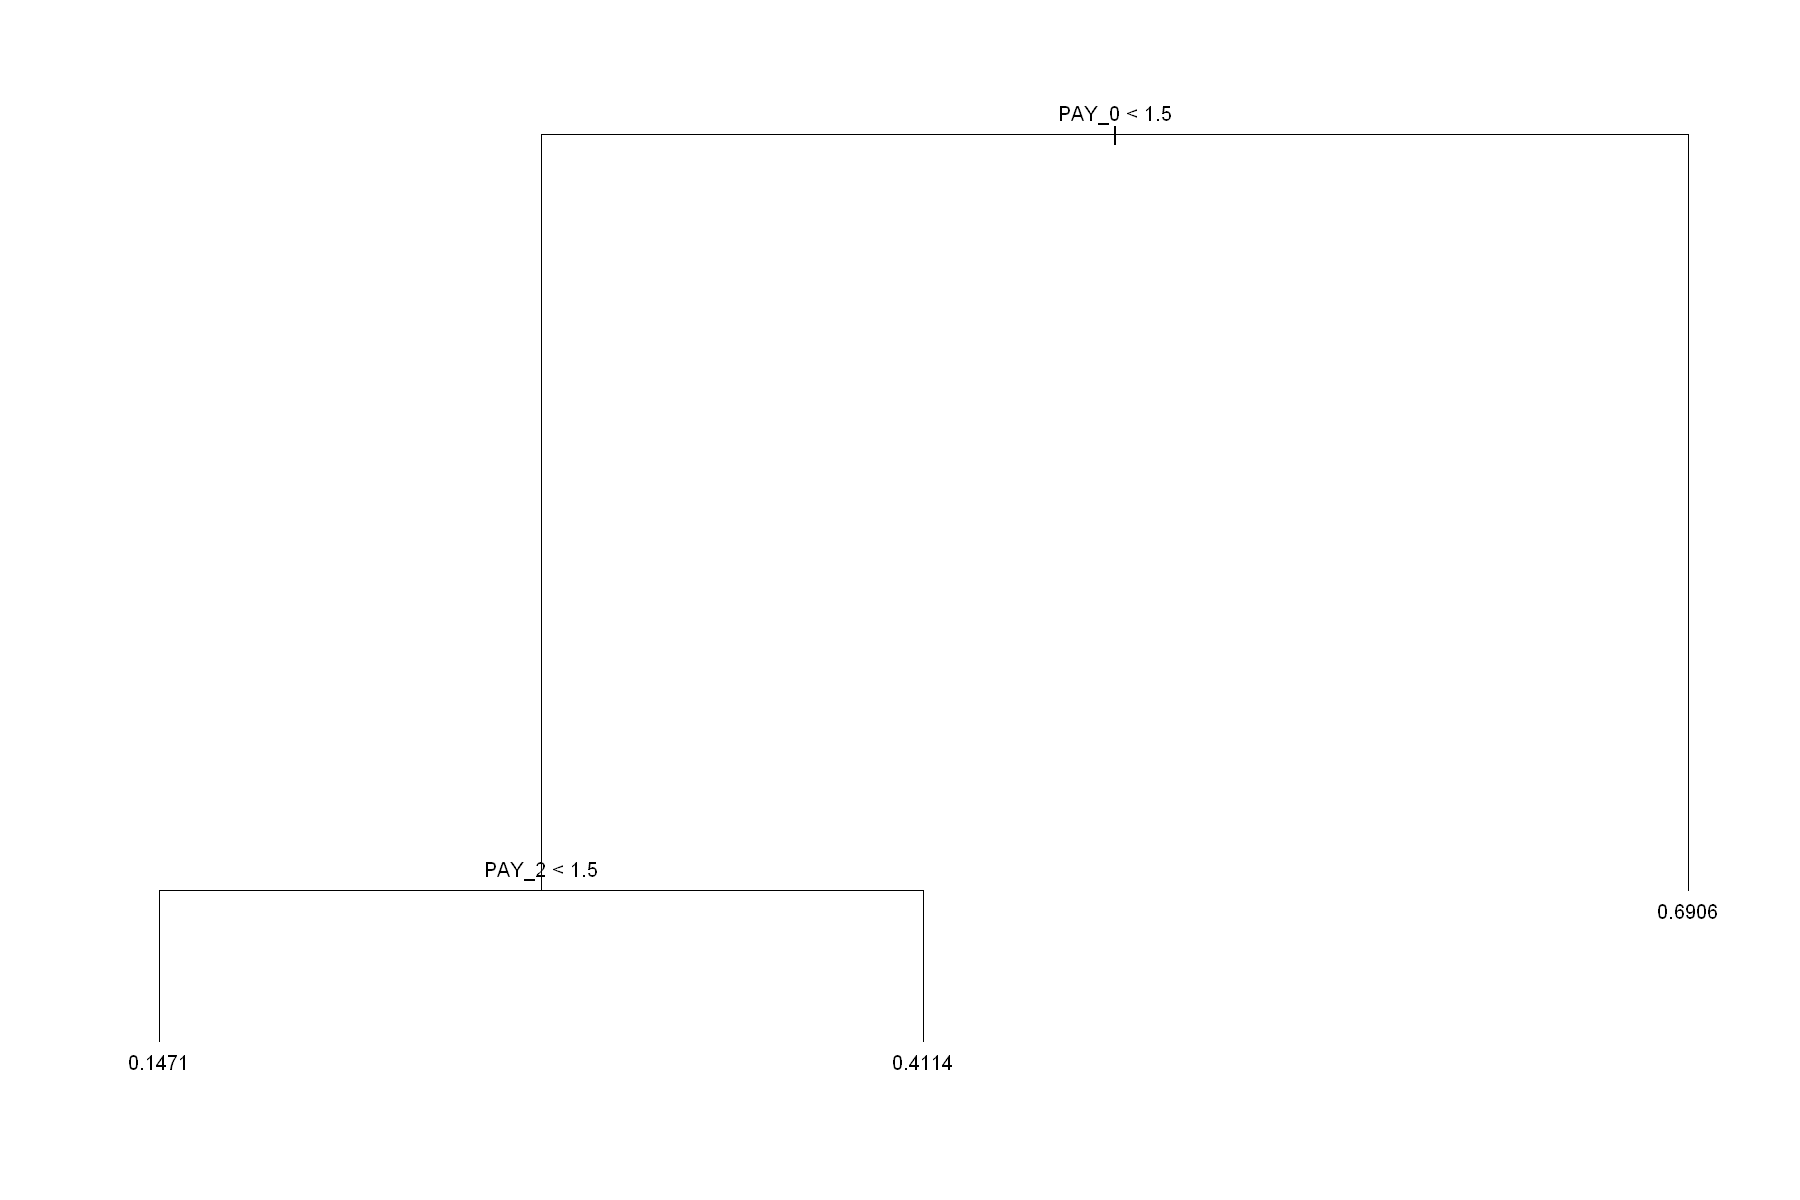

In [245]:
# Fit Decision Tree on train dataset
DecTree_SV <- tree(default.payment.next.month ~ EDUCATION + MARRIAGE + PAY_0 + PAY_2 + PAY_3 + PAY_5 + BILL_AMT1 + BILL_AMT3 + PAY_AMT1 + PAY_AMT2 + PAY_AMT3 + PAY_AMT6 + age_group, data=train)

# Show the Decision Tree
options(repr.plot.width=15, repr.plot.height=10)
plot(DecTree_SV)
text(DecTree_SV, pretty=0)

In [246]:
# Make prediction on test
pred_class4 <- predict(DecTree_SV, newdata=test)

# Confusion matrix
conf_mat4 <- table(pred_class4, test$default.payment.next.month)
conf_mat4

TP4 = conf_mat4[2, 2]  # 61
FP4 = conf_mat4[2, 1]  # 43
TN4 = conf_mat4[1, 1]  # 0
FN4 = conf_mat4[1, 2]  # 0

# Overall accuracy
acc4 <- (TP4 + TN4) / (TP4 + FP4 + TN4 + FN4)
print(paste('Accuracy =', acc))

# Error Type I
err_type1 <- FP4 / (TN4 + FP4)
print(paste('Error Type I =', err_type1))

# Error Type II
err_type2 <- FN4 / (TP4 + FN4)
print(paste('Error Type II =', err_type2))

                   
pred_class4            0    1
  0.147109876757507 4206  712
  0.411380597014925  278  166
  0.690611664295875  209  429

[1] "Accuracy = 0.811"
[1] "Error Type I = 0.0619982158786797"
[1] "Error Type II = 0.810933940774487"


In [247]:
# Prune the previous tree using error rate
set.seed(3)
cv_bt <- cv.tree(DecTree_SV)
cv_bt

$size
[1] 3 2 1

$dev
[1] 2007.633 2075.202 2417.785

$k
[1]      -Inf  68.49472 343.32722

$method
[1] "deviance"

attr(,"class")
[1] "prune"         "tree.sequence"

In [248]:
# Best tree size
min_idx <- which.min(cv_bt$dev)
tree_size <- cv_bt$size[min_idx]
tree_dev <- cv_bt$dev[min_idx]
tree_k <- cv_bt$k[min_idx]

print(paste0('Best tree size = ', tree_size))
print(paste0('Best Error = ', tree_dev))
print(paste0('Best alpha = ', tree_k))

[1] "Best tree size = 3"
[1] "Best Error = 2007.63348719888"
[1] "Best alpha = -Inf"


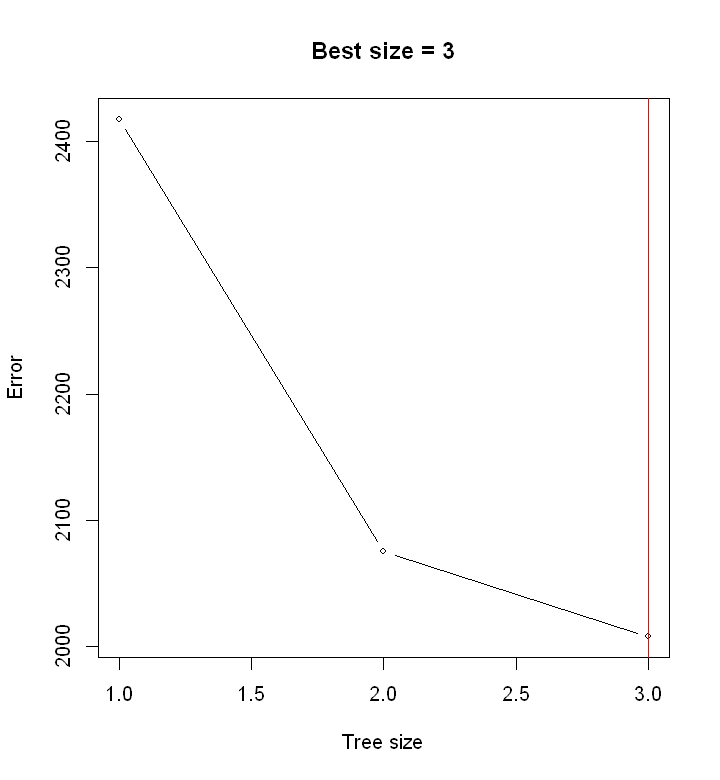

In [249]:
# Show the relationship between the size and the error of the tree
options(repr.plot.width=6, repr.plot.height=6.5)
plot(cv_bt$size, cv_bt$dev, type='b', cex=0.7,
     main=paste0('Best size = ', tree_size),
     ylab='Error', xlab='Tree size'
    )  # Tree size, number of nodes
abline(v=tree_size, col='red')  # Best tree size

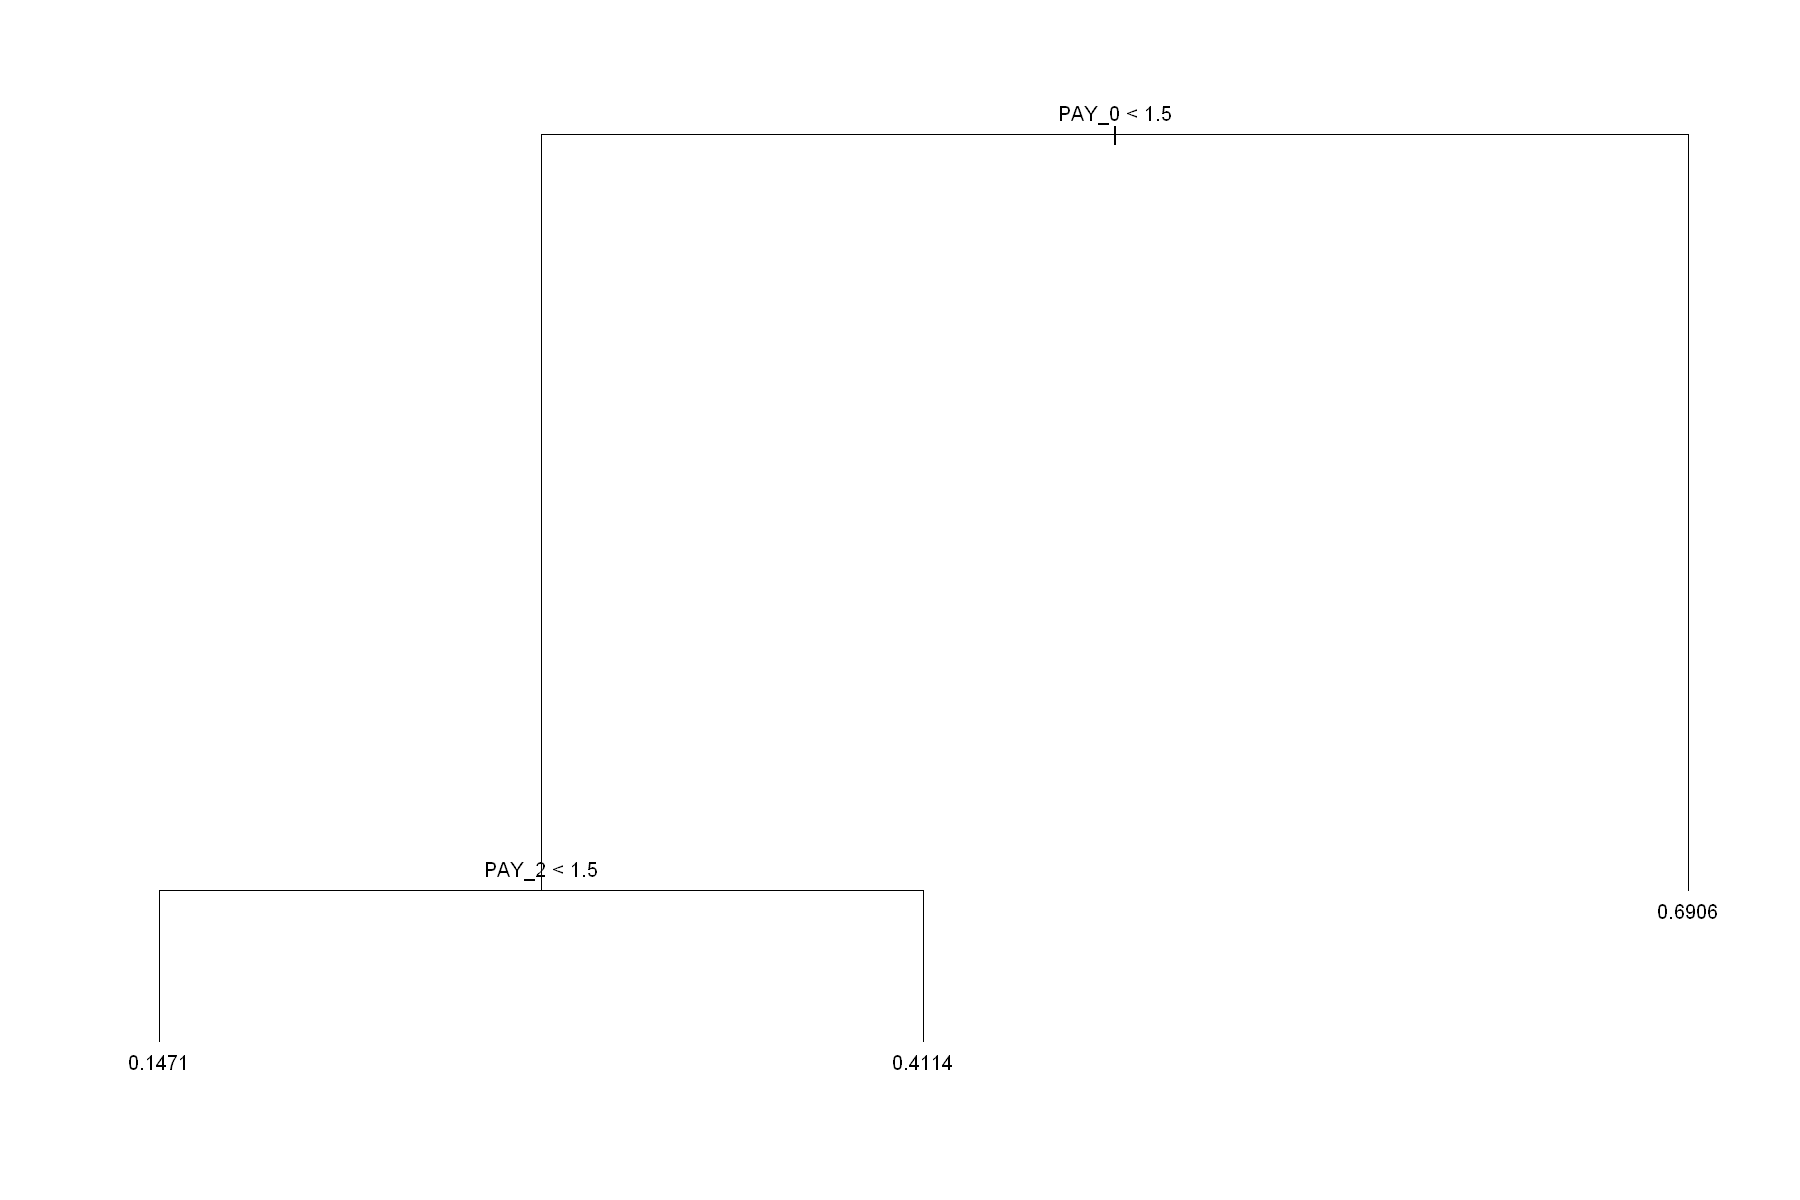

In [250]:
# Prune the tree
prune_rtree <- prune.tree(DecTree_SV, best=tree_size)

# Show the tree
options(repr.plot.width=15, repr.plot.height=10)
plot(prune_rtree)
text(prune_rtree, pretty=0)

In [251]:
# Check the performance of the pruned tree
pred_pruned4a <- predict(prune_rtree, newdata=test)

# Confusion matrix
conf_mat4a <- table(pred_pruned4a, test$default.payment.next.month)
conf_mat4a

TP4a = conf_mat4a[2, 2]  # 61
FP4a = conf_mat4a[2, 1]  # 43
TN4a = conf_mat4a[1, 1]  # 0
FN4a = conf_mat4a[1, 2]  # 0

# Overall accuracy
acc4a <- (TP4a + TN4a) / (TP4a + FP4a + TN4a + FN4a)
print(paste('Accuracy =', acc4a))

# Error Type I
err_type1 <- FP4a / (TN4a + FP4a)
print(paste('Error Type I =', err_type1))

# Error Type II
err_type2 <- FN4a / (TP4a + FN4a)
print(paste('Error Type II =', err_type2))

                   
pred_pruned4a          0    1
  0.147109876757507 4206  712
  0.411380597014925  278  166
  0.690611664295875  209  429

[1] "Accuracy = 0.815367400223797"
[1] "Error Type I = 0.0619982158786797"
[1] "Error Type II = 0.810933940774487"


##### All features

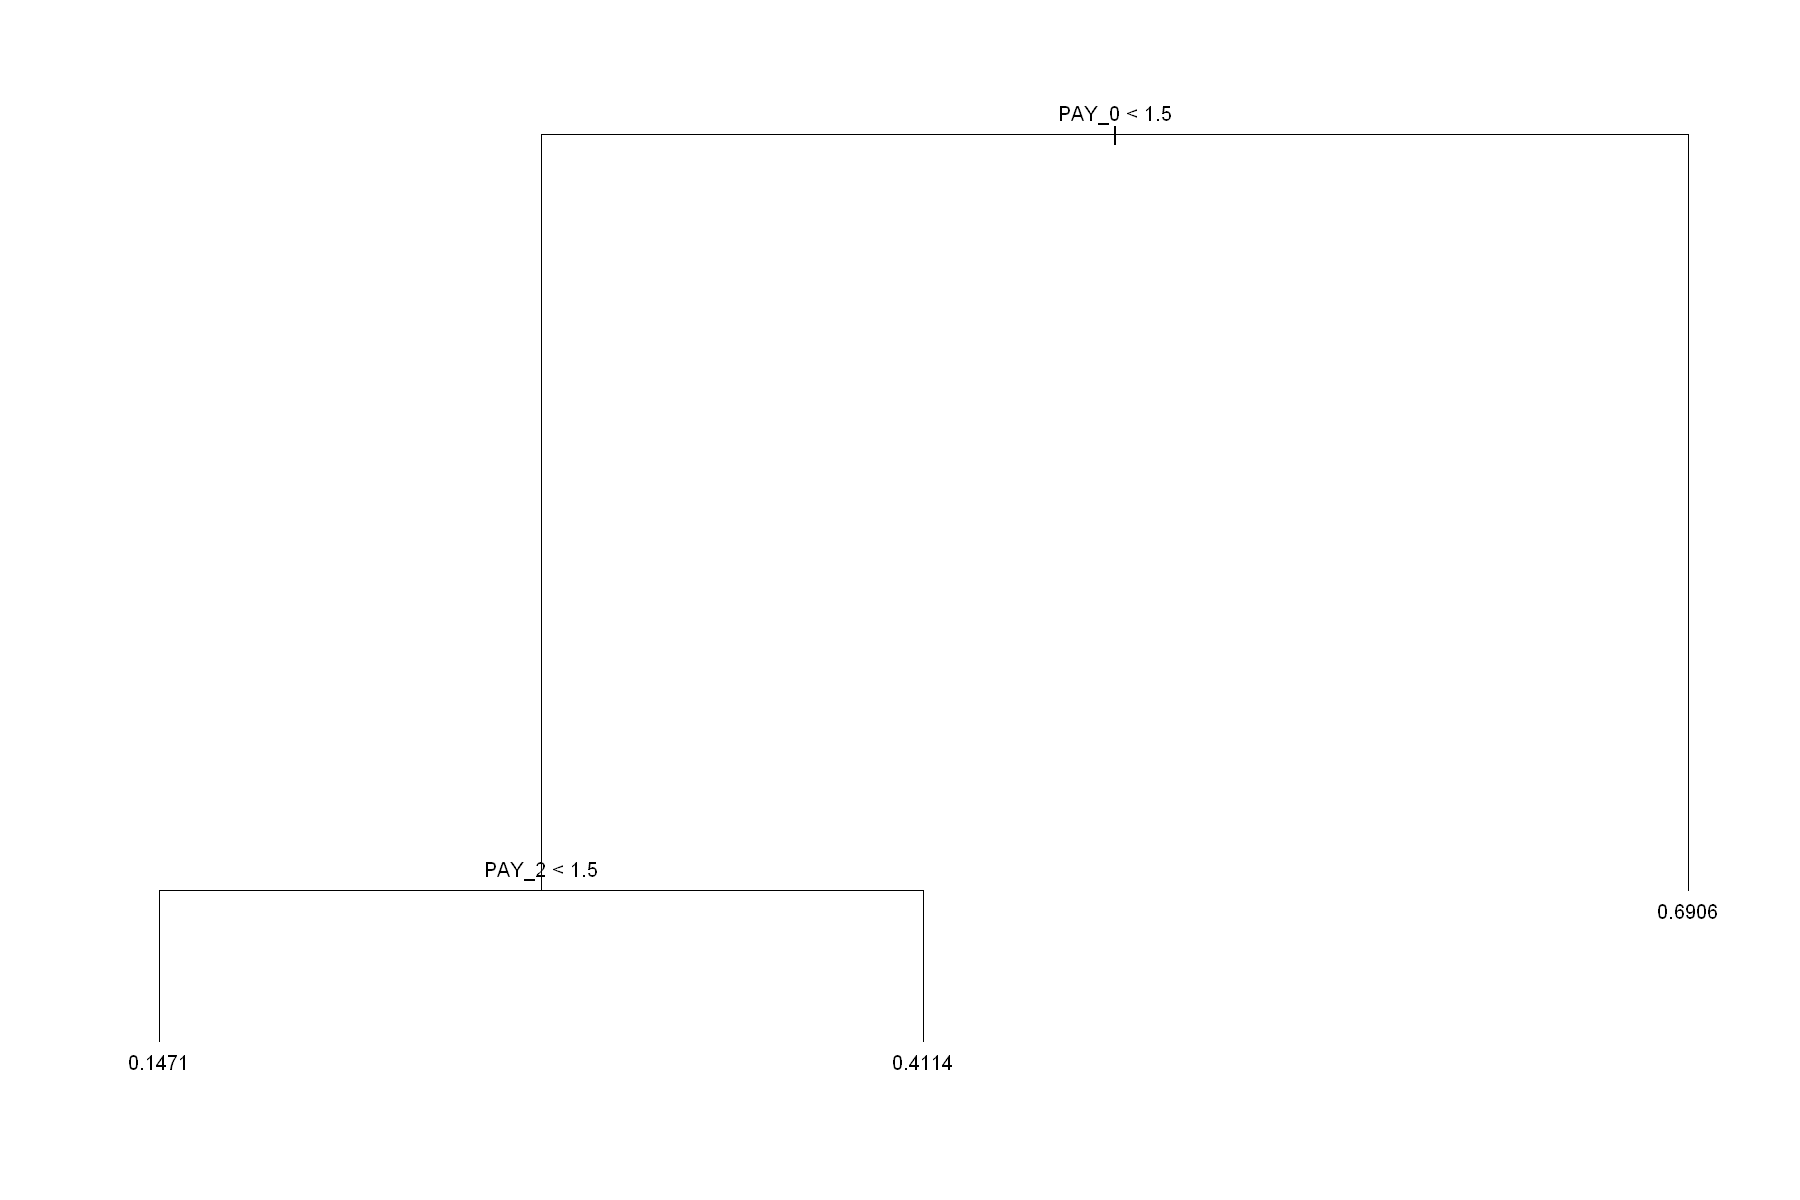

In [252]:
# Fit Decision Tree on train dataset
md_rtree <- tree(default.payment.next.month ~ ., data=train)

# Show the Decision Tree
options(repr.plot.width=15, repr.plot.height=10)
plot(md_rtree)
text(md_rtree, pretty=0)

In [253]:
# Make prediction on test
pred_class4b <- predict(md_rtree, newdata=test)

# Confusion matrix
conf_mat4b <- table(pred_class4b, test$default.payment.next.month)
conf_mat4b

TP4b = conf_mat4b[2, 2]  # 61
FP4b = conf_mat4b[2, 1]  # 43
TN4b = conf_mat4b[1, 1]  # 0
FN4b = conf_mat4b[1, 2]  # 0

# Overall accuracy
acc4b <- (TP4b + TN4b) / (TP4b + FP4b + TN4b + FN4b)
print(paste('Accuracy =', acc))

# Error Type I
err_type1 <- FP4b / (TN4b + FP4b)
print(paste('Error Type I =', err_type1))

# Error Type II
err_type2 <- FN4b / (TP4b + FN4b)
print(paste('Error Type II =', err_type2))

                   
pred_class4b           0    1
  0.147109876757507 4206  712
  0.411380597014925  278  166
  0.690611664295875  209  429

[1] "Accuracy = 0.811"
[1] "Error Type I = 0.0619982158786797"
[1] "Error Type II = 0.810933940774487"


In [254]:
# Prune the previous tree using error rate
set.seed(3)
cv_bt <- cv.tree(md_rtree)
cv_bt

$size
[1] 3 2 1

$dev
[1] 2007.633 2075.202 2417.785

$k
[1]      -Inf  68.49472 343.32722

$method
[1] "deviance"

attr(,"class")
[1] "prune"         "tree.sequence"

In [255]:
# Best tree size
min_idx <- which.min(cv_bt$dev)
tree_size <- cv_bt$size[min_idx]
tree_dev <- cv_bt$dev[min_idx]
tree_k <- cv_bt$k[min_idx]

print(paste0('Best tree size = ', tree_size))
print(paste0('Best Error = ', tree_dev))
print(paste0('Best alpha = ', tree_k))

[1] "Best tree size = 3"
[1] "Best Error = 2007.63348719888"
[1] "Best alpha = -Inf"


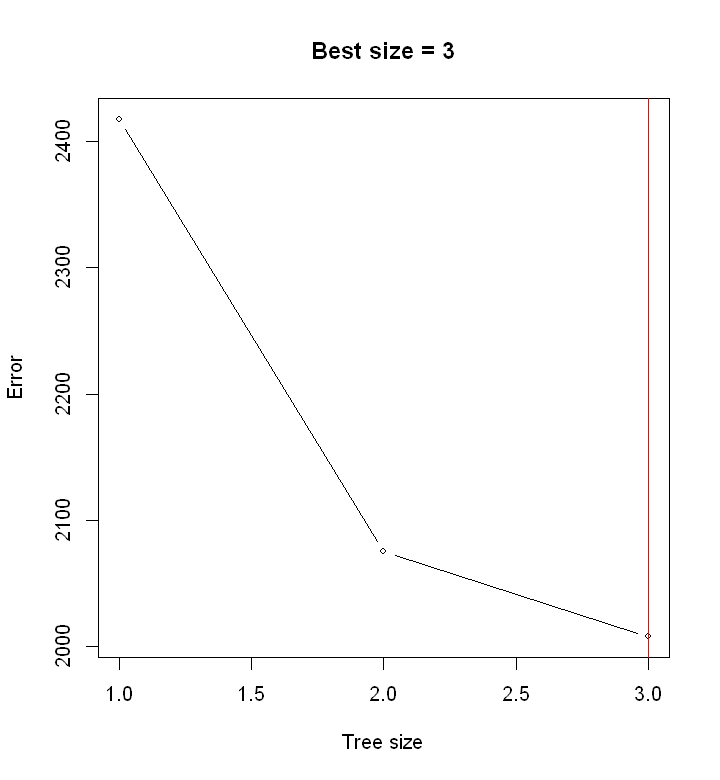

In [256]:
# Show the relationship between the size and the error of the tree
options(repr.plot.width=6, repr.plot.height=6.5)
plot(cv_bt$size, cv_bt$dev, type='b', cex=0.7,
     main=paste0('Best size = ', tree_size),
     ylab='Error', xlab='Tree size'
    )  # Tree size, number of nodes
abline(v=tree_size, col='red')  # Best tree size

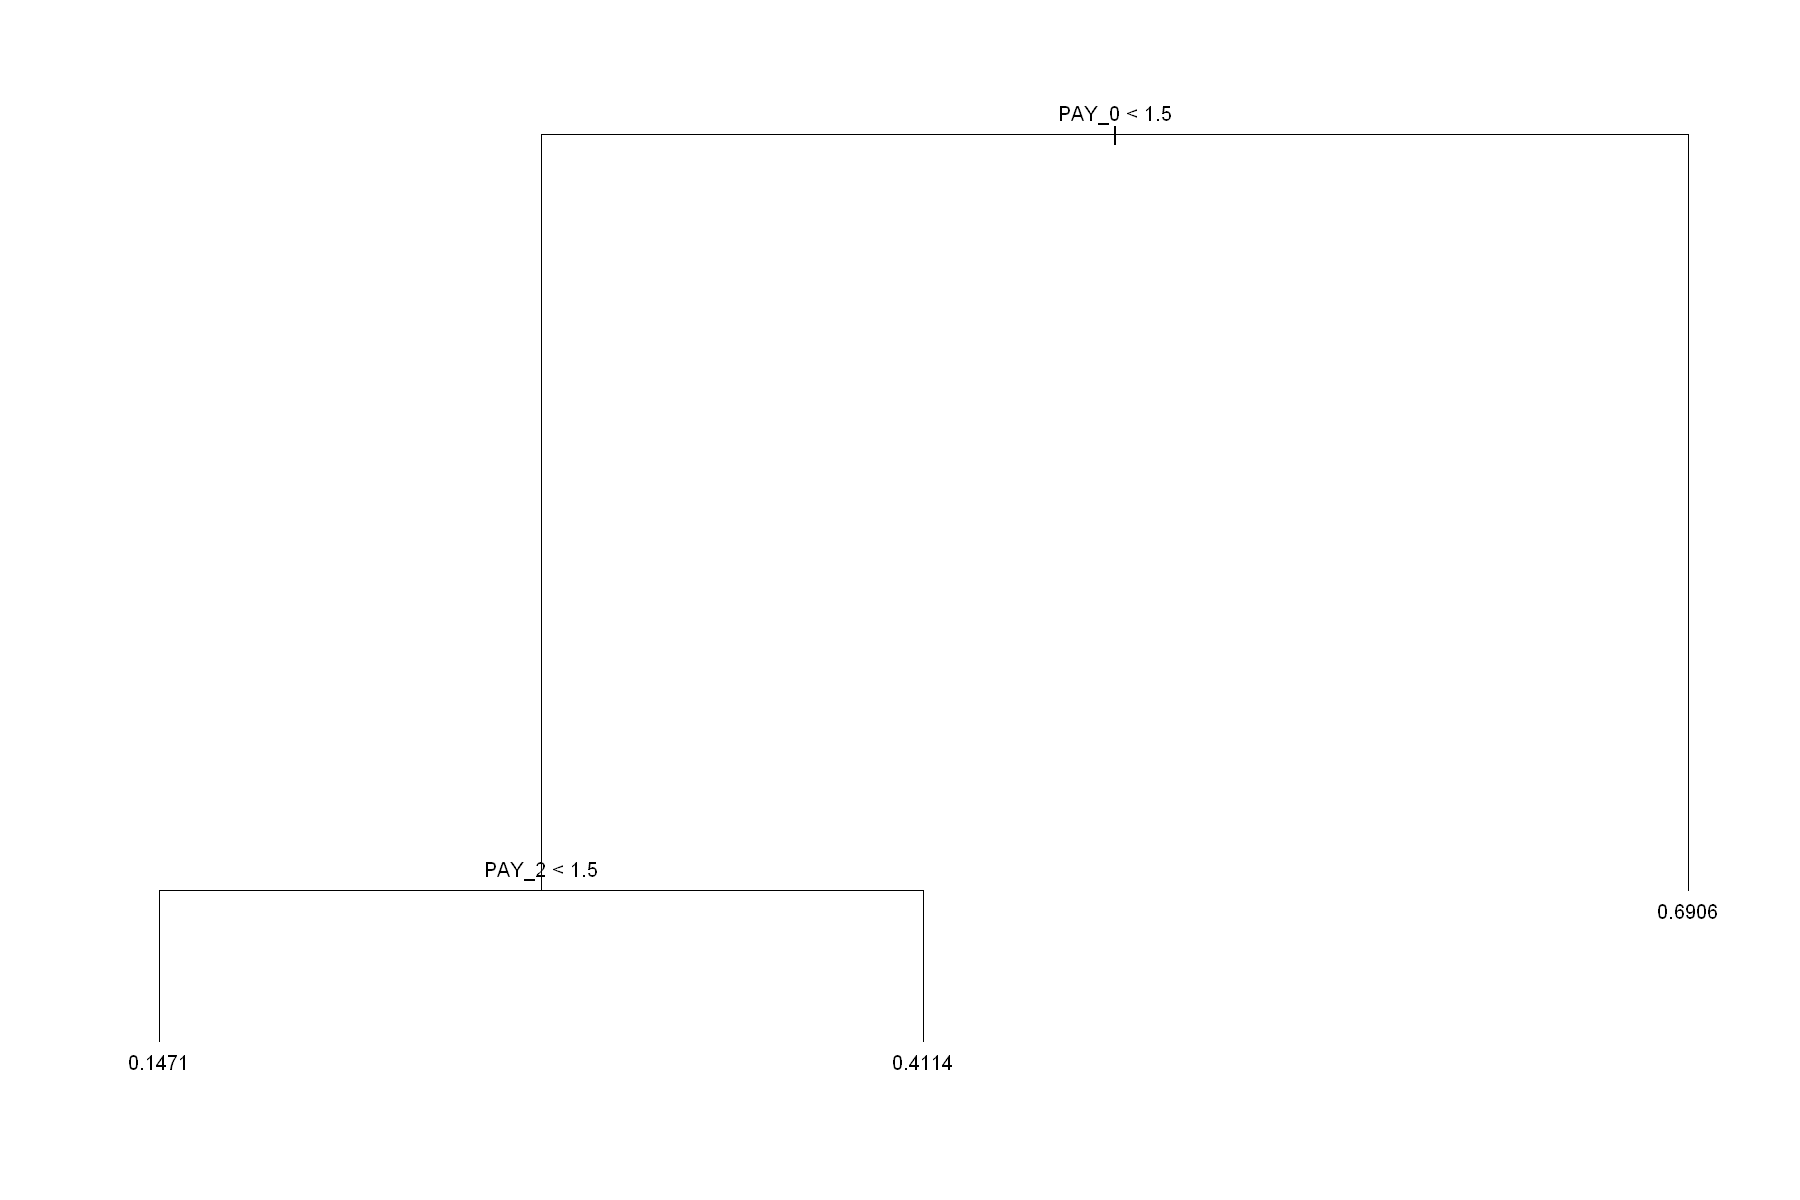

In [257]:
# Prune the tree
prune_rtree <- prune.tree(md_rtree, best=tree_size)

# Show the tree
options(repr.plot.width=15, repr.plot.height=10)
plot(prune_rtree)
text(prune_rtree, pretty=0)

In [258]:
# Check the performance of the pruned tree
pred_pruned4c <- predict(prune_rtree, newdata=test)

# Confusion matrix
conf_mat4c <- table(pred_pruned4c, test$default.payment.next.month)
conf_mat4c

TP4c = conf_mat4c[2, 2]  # 61
FP4c = conf_mat4c[2, 1]  # 43
TN4c = conf_mat4c[1, 1]  # 0
FN4c = conf_mat4c[1, 2]  # 0

# Overall accuracy
acc4c <- (TP4c + TN4c) / (TP4c + FP4c + TN4c + FN4c)
print(paste('Accuracy =', acc4c))

# Error Type I
err_type1 <- FP4c / (TN4c + FP4c)
print(paste('Error Type I =', err_type1))

# Error Type II
err_type2 <- FN4c / (TP4c + FN4c)
print(paste('Error Type II =', err_type2))

                   
pred_pruned4c          0    1
  0.147109876757507 4206  712
  0.411380597014925  278  166
  0.690611664295875  209  429

[1] "Accuracy = 0.815367400223797"
[1] "Error Type I = 0.0619982158786797"
[1] "Error Type II = 0.810933940774487"


### 5. Random Forest

##### Selected features

In [259]:
train$default.payment.next.month <- as.factor(train$default.payment.next.month) 
test$default.payment.next.month <- as.factor(test$default.payment.next.month) 

In [260]:
# Fit random forests model on train
set.seed(1)
RF_SV <- randomForest(default.payment.next.month ~ EDUCATION + MARRIAGE + PAY_0 + PAY_2 + PAY_3 + PAY_5 + BILL_AMT1 + BILL_AMT3 + PAY_AMT1 + PAY_AMT2 + PAY_AMT3 + PAY_AMT6 + age_group, data=train, mtry=8, importance=T)  # Default mtry = p/3

# Make prediction on test
pred_class5 <- predict(RF_SV, newdata=test)

# Confusion matrix
conf_mat5 <- table(pred_class5, test$default.payment.next.month)
conf_mat5

TP5 = conf_mat5[2, 2]  # 61
FP5 = conf_mat5[2, 1]  # 43
TN5 = conf_mat5[1, 1]  # 0
FN5 = conf_mat5[1, 2]  # 0

# Overall accuracy
acc5 <- (TP5 + TN5) / (TP5 + FP5 + TN5 + FN5)
print(paste('Accuracy =', acc))

# Error Type I
err_type1 <- FP5 / (TN5 + FP5)
print(paste('Error Type I =', err_type1))

# Error Type II
err_type2 <- FN5 / (TP5 + FN5)
print(paste('Error Type II =', err_type2))

           
pred_class5    0    1
          0 4360  828
          1  333  479

[1] "Accuracy = 0.811"
[1] "Error Type I = 0.070956744086938"
[1] "Error Type II = 0.633511859219587"


##### All features

In [261]:
# Fit random forests model on train
set.seed(1)
RF_AV <- randomForest(default.payment.next.month ~ ., data=train, mtry=8, importance=T)  # Default mtry = p/3

# Make prediction on test
pred_class5a <- predict(RF_AV, newdata=test)

# Confusion matrix
conf_mat5a <- table(pred_class5a, test$default.payment.next.month)
conf_mat5a

TP5a = conf_mat5a[2, 2]  # 61
FP5a = conf_mat5a[2, 1]  # 43
TN5a = conf_mat5a[1, 1]  # 0
FN5a = conf_mat5a[1, 2]  # 0

# Overall accuracy
acc5a <- (TP5a + TN5a) / (TP5a + FP5a + TN5a + FN5a)
print(paste('Accuracy =', acc5a))

# Error Type I
err_type1 <- FP5a / (TN5a + FP5a)
print(paste('Error Type I =', err_type1))

# Error Type II
err_type2 <- FN5a / (TP5a + FN5a)
print(paste('Error Type II =', err_type2))

            
pred_class5a    0    1
           0 4373  821
           1  320  486

[1] "Accuracy = 0.809833333333333"
[1] "Error Type I = 0.0681866609844449"
[1] "Error Type II = 0.628156082631982"


# Cross validation on Logistic Regression 

##### Selected features

In [277]:
new_credit_default <- rbind(train, test)
str(new_credit_default)

'data.frame':	20000 obs. of  24 variables:
 $ LIMIT_BAL                 : num  390000 60000 140000 50000 20000 50000 250000 320000 80000 30000 ...
 $ SEX                       : num  2 1 2 1 1 1 1 2 2 2 ...
 $ EDUCATION                 : num  2 1 2 1 2 3 2 2 2 2 ...
 $ MARRIAGE                  : num  2 2 1 2 2 2 2 2 2 2 ...
 $ PAY_0                     : num  2 0 0 2 0 0 0 -2 0 0 ...
 $ PAY_2                     : num  2 0 0 2 0 0 0 -2 0 0 ...
 $ PAY_3                     : num  2 0 0 2 0 0 0 -2 0 0 ...
 $ PAY_4                     : num  0 0 0 0 0 2 -1 -2 2 2 ...
 $ PAY_5                     : num  0 0 0 0 0 0 2 -2 2 0 ...
 $ PAY_6                     : num  0 2 0 -2 0 0 -1 -2 0 0 ...
 $ BILL_AMT1                 : num  160599 21387 108038 7881 20009 ...
 $ BILL_AMT2                 : num  151903 22416 110216 10415 20602 ...
 $ BILL_AMT3                 : num  145766 23444 84516 3997 21255 ...
 $ BILL_AMT4                 : num  132544 26038 72391 1047 19105 ...
 $ BILL_AMT5         

In [300]:
# Define training control
set.seed(123) 
train.control <- trainControl(method = "cv", number = 3)
# Train the model
model <- train(default.payment.next.month ~ EDUCATION + MARRIAGE + PAY_0 + PAY_2 + PAY_3 + PAY_5 + BILL_AMT1 + BILL_AMT3 + PAY_AMT1 + PAY_AMT2 + PAY_AMT3 + PAY_AMT6 + age_group, 
               data = new_credit_default, method = "glm",
               trControl = train.control, family=binomial())
# Summarize the results
print(model)

Generalized Linear Model 

20000 samples
   13 predictor
    2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (3 fold) 
Summary of sample sizes: 13333, 13334, 13333 
Resampling results:

  Accuracy  Kappa    
  0.80635   0.2547044



# Best model

In [264]:
Model <- c("Logistic regression (selected vars)", "Logistic regression (all vars)", 
           "LDA (selected vars)", "LDA (all)", "QDA (selected vars)", "QDA (all vars)",
           "Decision Tree (selected vars)",
           "Decision Tree (all vars)", 
           "Random Forest (selected vars)", "Random Forest (all vars)")
Evaluation <- c(acc1, acc1a, acc2, acc2a, acc3, acc3a, acc4, acc4b, acc5, acc5a)

BestModel <- data.frame(Model, Evaluation)
BestModel

Model,Evaluation
<chr>,<dbl>
Logistic regression (selected vars),0.8116667
Logistic regression (all vars),0.8100000
LDA (selected vars),0.8120000
LDA (all),0.8113333
QDA (selected vars),0.7640000
QDA (all vars),0.7238333
Decision Tree (selected vars),0.8153674
Decision Tree (all vars),0.8153674
Random Forest (selected vars),0.8065000


In [265]:
BestModel_sorted <- BestModel[order(-Evaluation),]
BestModel_sorted

,Model,Evaluation
,<chr>,<dbl>
7,Decision Tree (selected vars),0.8153674
8,Decision Tree (all vars),0.8153674
3,LDA (selected vars),0.8120000
1,Logistic regression (selected vars),0.8116667
4,LDA (all),0.8113333
2,Logistic regression (all vars),0.8100000
10,Random Forest (all vars),0.8098333
9,Random Forest (selected vars),0.8065000
5,QDA (selected vars),0.7640000


In [315]:
train$default.payment.next.month <- as.numeric(train$default.payment.next.month)
test$default.payment.next.month <- as.numeric(test$default.payment.next.month)

In [316]:
write.csv(new_credit_default,"C:/Users/ekelly/OneDrive - IESEG/Statistical and ML Marketing R/_Individual Project_/Send/new_credit_default.csv", row.names = FALSE)

In [317]:
write.csv(train,"C:/Users/ekelly/OneDrive - IESEG/Statistical and ML Marketing R/_Individual Project_/Send/train.csv", row.names = FALSE)

In [318]:
write.csv(test,"C:/Users/ekelly/OneDrive - IESEG/Statistical and ML Marketing R/_Individual Project_/Send/test.csv", row.names = FALSE)